# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.10.0+cu111
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive  Shareddrives


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [3]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

--2021-11-24 14:14:20--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  2.51MB/s    in 0.9s    

2021-11-24 14:14:21 (2.51 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


In [4]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [5]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    voc2ind = {}
    index = 0
    space = " "
    data = data.split()
    data = space.join(data)
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        if char not in voc2ind:
          voc2ind[char] = index
          index += 1


    ind2voc = {val: key for key, val in voc2ind.items()}

    eighty_percent = int(0.8 * len(data))
    train_text = data[:eighty_percent]
    test_text = data[eighty_percent:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)


#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [8]:
import math

class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.tokens = dataset['tokens']
        self.voc2ind = dataset['voc2ind']
        self.n = len(self.tokens) - (len(self.tokens) % batch_size) 
        self.data_batches = torch.LongTensor([self.voc2ind[self.tokens[i]] for i in range(self.n)]).view(batch_size, -1)
        self.unique_seqs = math.ceil((self.data_batches.shape[1] - 1) / self.sequence_length) * self.data_batches.shape[0]

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return self.unique_seqs
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        batch = idx % self.batch_size
        sequence = idx // self.batch_size

        seq_begin = sequence * self.sequence_length
        seq_end = seq_begin + self.sequence_length + 1
        selection = self.data_batches[batch][seq_begin:min(self.data_batches.shape[1], seq_end)]
        return selection[:-1], selection[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [38]:
TEMPERATURE = 0.7

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [10]:
TEMPERATURE = 0.7
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        max = output[0].argmax().long()
        outputs.append(max)
        output, hidden = model.inference(max, hidden, TEMPERATURE)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        sample = torch.multinomial(output[0], 1)
        sample = sample[0].long()
        outputs.append(sample)
        output, hidden = model.inference(sample, hidden, TEMPERATURE)
    return outputs

def beam_ranking(x):
  return x[3]

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beam = [([], output, hidden, 0)]
    for i in range(sequence_length):
      next_beam = []
      for curr in beam:
        samples = torch.multinomial(curr[1][0], beam_width, replacement=True)
        for sample_tensor in samples:
          sample = sample_tensor.long()
          score = curr[3] + torch.log(curr[1][0][sample])
          output, hidden = model.inference(sample, curr[2], TEMPERATURE)
          to_append = (curr[0] + [sample], output, hidden, score)
          next_beam.append(to_append)
        next_beam.sort(reverse=False, key=beam_ranking)
        beam = next_beam[:beam_width]
    return beam[0][0]


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)



# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [11]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([89, 512]) = 0MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([89, 512]) = 0MB
decoder.bias -> 	torch.Size([89]) = 0MB

Restored all variables
No new variables
Restored /content/checkpoints/000.pt
Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rwreat ailntand siavtd tnain.t the fare  aaasl  "H sn sa ke .  He said  "Win't yarry "til," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	essed the snt r aan

  1%|          | 2/195 [00:00<00:40,  4.74it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 1.527146


  6%|▌         | 12/195 [00:02<00:31,  5.82it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 3.169126


 11%|█▏        | 22/195 [00:03<00:29,  5.87it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 2.108395


 16%|█▋        | 32/195 [00:05<00:27,  5.87it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 1.798425


 22%|██▏       | 42/195 [00:07<00:25,  5.95it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 1.658885


 27%|██▋       | 52/195 [00:08<00:24,  5.88it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 1.569387


 32%|███▏      | 62/195 [00:10<00:22,  5.91it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 1.547875


 37%|███▋      | 72/195 [00:12<00:20,  5.88it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 1.527546


 42%|████▏     | 82/195 [00:14<00:19,  5.86it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 1.507010


 47%|████▋     | 92/195 [00:15<00:17,  5.89it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 1.512644


 52%|█████▏    | 102/195 [00:17<00:15,  5.93it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 1.514255


 57%|█████▋    | 112/195 [00:19<00:14,  5.70it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 1.497687


 63%|██████▎   | 122/195 [00:20<00:12,  5.87it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 1.524183


 68%|██████▊   | 132/195 [00:22<00:10,  5.97it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.517987


 73%|███████▎  | 142/195 [00:24<00:09,  5.76it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.510966


 78%|███████▊  | 152/195 [00:25<00:07,  5.91it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 1.513325


 83%|████████▎ | 162/195 [00:27<00:05,  5.84it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 1.484739


 88%|████████▊ | 172/195 [00:29<00:03,  5.93it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.481818


 93%|█████████▎| 182/195 [00:31<00:02,  5.91it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.479374


 98%|█████████▊| 192/195 [00:32<00:00,  5.89it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.503168


100%|██████████| 195/195 [00:33<00:00,  5.87it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rcreat oulntand soaved onain.t the core  eahsl  "I dm Ih ke .  He said  "Win's yausy "Iol," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ewsed hhe bnt   hore  hnd herry sa p d humbledore heck an o hhe cnk aeet yed ahet henl d ohe cheaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng hnd heenpeng hn hhe cigdle of hhe cerk hesh hnuues hn hagsmeade  "ur sfe helribee herent harr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:00,  3.22it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.494361


  6%|▌         | 12/195 [00:02<00:31,  5.81it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.520356


 11%|█▏        | 22/195 [00:03<00:29,  5.95it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.516956


 16%|█▋        | 32/195 [00:05<00:28,  5.80it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.527480


 22%|██▏       | 42/195 [00:07<00:26,  5.80it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.484684


 27%|██▋       | 52/195 [00:09<00:24,  5.82it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.552480


 32%|███▏      | 62/195 [00:10<00:22,  5.89it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.604545


 37%|███▋      | 72/195 [00:12<00:20,  5.88it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.496775


 42%|████▏     | 82/195 [00:14<00:19,  5.87it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.474864


 47%|████▋     | 92/195 [00:15<00:17,  5.85it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.474277


 52%|█████▏    | 102/195 [00:17<00:15,  5.88it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.467873


 57%|█████▋    | 112/195 [00:19<00:14,  5.85it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.455166


 63%|██████▎   | 122/195 [00:20<00:12,  5.82it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.503000


 68%|██████▊   | 132/195 [00:22<00:10,  5.89it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.499066


 73%|███████▎  | 142/195 [00:24<00:08,  5.91it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.473627


 78%|███████▊  | 152/195 [00:26<00:07,  5.78it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.470250


 83%|████████▎ | 162/195 [00:27<00:05,  5.87it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.510474


 88%|████████▊ | 172/195 [00:29<00:03,  5.94it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.565584


 93%|█████████▎| 182/195 [00:31<00:02,  5.90it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.472175


 98%|█████████▊| 192/195 [00:32<00:00,  5.96it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.457362


100%|██████████| 195/195 [00:33<00:00,  5.86it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rcroat audntand soaved ttain t the fose  oahsl  "I sm Ih t  .  "e said  "Ion'  yausy "til," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ows d toe stt   tlre  and tarry saap d humbledore weck tn o the cnk aiet yed thet horl d ohe cooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng hnd soenpeng hn the sigdle of the cork aash anuuet an tagsmeade  "ur sf  helrible terent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:45,  4.24it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.462368


  6%|▌         | 12/195 [00:02<00:31,  5.85it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.454584


 11%|█▏        | 22/195 [00:03<00:29,  5.88it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.445267


 16%|█▋        | 32/195 [00:05<00:27,  5.89it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.462471


 22%|██▏       | 42/195 [00:07<00:25,  5.92it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.450929


 27%|██▋       | 52/195 [00:08<00:24,  5.86it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.454223


 32%|███▏      | 62/195 [00:10<00:22,  5.87it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.456212


 37%|███▋      | 72/195 [00:12<00:20,  5.94it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.436031


 42%|████▏     | 82/195 [00:14<00:19,  5.84it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.420857


 47%|████▋     | 92/195 [00:15<00:17,  5.86it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.446358


 52%|█████▏    | 102/195 [00:17<00:15,  5.86it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.437072


 57%|█████▋    | 112/195 [00:19<00:14,  5.92it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.447867


 63%|██████▎   | 122/195 [00:20<00:12,  5.92it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.459839


 68%|██████▊   | 132/195 [00:22<00:10,  5.95it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.464150


 73%|███████▎  | 142/195 [00:24<00:09,  5.81it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.455177


 78%|███████▊  | 152/195 [00:25<00:07,  5.80it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.450894


 83%|████████▎ | 162/195 [00:27<00:05,  5.94it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.452620


 88%|████████▊ | 172/195 [00:29<00:03,  5.90it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.419922


 93%|█████████▎| 182/195 [00:31<00:02,  5.94it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.419005


 98%|█████████▊| 192/195 [00:32<00:00,  5.91it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.439764


100%|██████████| 195/195 [00:33<00:00,  5.87it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nhreat solntand soaved atain t the cosen oahsl  "I sm Ih r  .  "e said  "Io '  saury "Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	owsed the stt r tlre  and sarry saap d humbledore seck tn o hhe cnk ahet yed ahet honl d ohe cooaenh


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nen ng hnd soenpeng hn the sigdle of the sork aash anuuethan tagsmeade  "or sf  helrible terent harr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:45,  4.23it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.435408


  6%|▌         | 12/195 [00:02<00:31,  5.84it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.431135


 11%|█▏        | 22/195 [00:03<00:29,  5.87it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.428363


 16%|█▋        | 32/195 [00:05<00:28,  5.80it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.452833


 22%|██▏       | 42/195 [00:07<00:25,  5.91it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.421857


 27%|██▋       | 52/195 [00:09<00:24,  5.81it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.418079


 32%|███▏      | 62/195 [00:10<00:22,  5.81it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.429993


 37%|███▋      | 72/195 [00:12<00:21,  5.77it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.414810


 42%|████▏     | 82/195 [00:14<00:19,  5.90it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.404595


 47%|████▋     | 92/195 [00:15<00:17,  5.90it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.446877


 52%|█████▏    | 102/195 [00:17<00:15,  5.88it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.426135


 57%|█████▋    | 112/195 [00:19<00:14,  5.87it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.401610


 63%|██████▎   | 122/195 [00:20<00:12,  5.90it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.422954


 68%|██████▊   | 132/195 [00:22<00:10,  5.96it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.446761


 73%|███████▎  | 142/195 [00:24<00:08,  5.93it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.438419


 78%|███████▊  | 152/195 [00:25<00:07,  5.88it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.434761


 83%|████████▎ | 162/195 [00:27<00:05,  5.93it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.429273


 88%|████████▊ | 172/195 [00:29<00:03,  5.96it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.437073


 93%|█████████▎| 182/195 [00:31<00:02,  5.83it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.407110


 98%|█████████▊| 192/195 [00:32<00:00,  5.79it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.420013


100%|██████████| 195/195 [00:33<00:00,  5.86it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nhreat aolntand soaved atain t the case  owhsl  "I dm Ih t  .  "e said  "Io '  yaury "Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	owsed the ctt r alre  hnd tarry saap d humbledore weck tn o the cnk aiet ye  ahet horl d ohe caoaenh


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng hnd soenpeng hn the ciddle of the cork aash anuuetean tagwmeade  "ur af  wewrible tarent aarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:47,  4.07it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.423904


  6%|▌         | 12/195 [00:02<00:31,  5.87it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.418683


 11%|█▏        | 22/195 [00:03<00:29,  5.89it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.411245


 16%|█▋        | 32/195 [00:05<00:27,  5.89it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.443365


 22%|██▏       | 42/195 [00:07<00:25,  5.99it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.424299


 27%|██▋       | 52/195 [00:08<00:24,  5.90it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.396796


 32%|███▏      | 62/195 [00:10<00:22,  5.89it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.408345


 37%|███▋      | 72/195 [00:12<00:20,  5.92it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.398916


 42%|████▏     | 82/195 [00:14<00:19,  5.73it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.387512


 47%|████▋     | 92/195 [00:15<00:17,  5.86it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.402372


 52%|█████▏    | 102/195 [00:17<00:15,  5.83it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.401176


 57%|█████▋    | 112/195 [00:19<00:14,  5.84it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.391032


 63%|██████▎   | 122/195 [00:20<00:12,  5.74it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.415082


 68%|██████▊   | 132/195 [00:22<00:10,  5.92it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.420419


 73%|███████▎  | 142/195 [00:24<00:09,  5.84it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.420573


 78%|███████▊  | 152/195 [00:26<00:07,  5.75it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.410937


 83%|████████▎ | 162/195 [00:27<00:05,  5.78it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.396440


 88%|████████▊ | 172/195 [00:29<00:03,  5.85it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.376738


 93%|█████████▎| 182/195 [00:31<00:02,  5.92it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.378391


 98%|█████████▊| 192/195 [00:32<00:00,  5.91it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.396822


100%|██████████| 195/195 [00:33<00:00,  5.85it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreat sonntand soaved ttainst the cose  oshsk  "I dm ih r ".  "e said  "Io 't yaury,"Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed toe stt r tlren bnd tarry saap d tumbledore weck tn o the cnk aiet,ye  thet torl d ooe cooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nen ng and soenpeng in the siddle of the cork aashtanuietean tagwmeade  "or af  oewrible tarent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:46,  4.18it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.405625


  6%|▌         | 12/195 [00:02<00:31,  5.80it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.410986


 11%|█▏        | 22/195 [00:03<00:29,  5.87it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.408938


 16%|█▋        | 32/195 [00:05<00:27,  5.84it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.435573


 22%|██▏       | 42/195 [00:07<00:26,  5.77it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.402438


 27%|██▋       | 52/195 [00:08<00:24,  5.95it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.380894


 32%|███▏      | 62/195 [00:10<00:22,  5.92it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.395066


 37%|███▋      | 72/195 [00:12<00:20,  5.93it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.387180


 42%|████▏     | 82/195 [00:14<00:19,  5.90it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.374590


 47%|████▋     | 92/195 [00:15<00:17,  5.89it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.389862


 52%|█████▏    | 102/195 [00:17<00:15,  5.96it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.388878


 57%|█████▋    | 112/195 [00:19<00:14,  5.82it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.372337


 63%|██████▎   | 122/195 [00:20<00:12,  5.87it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.401222


 68%|██████▊   | 132/195 [00:22<00:10,  5.93it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.411274


 73%|███████▎  | 142/195 [00:24<00:09,  5.75it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.408547


 78%|███████▊  | 152/195 [00:25<00:07,  5.87it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.395526


 83%|████████▎ | 162/195 [00:27<00:05,  5.89it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.388088


 88%|████████▊ | 172/195 [00:29<00:03,  5.88it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.388865


 93%|█████████▎| 182/195 [00:31<00:02,  5.92it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.377737


 98%|█████████▊| 192/195 [00:32<00:00,  6.01it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.391850


100%|██████████| 195/195 [00:33<00:00,  5.87it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat sunntand soaved tnain t the care  osask  "I dm th r ".  "e said  "Io 't yaury, wor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	oss d the stt r tlre  bnd tarry saad d humbledore weck tn o the cnk otet,ye  ahet horl d ohe caoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng and soenpeng hn the saddle of the sork aashtanuaemean tagwmeade  "rr af  oewrible sarent aarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:46,  4.11it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.398809


  6%|▌         | 12/195 [00:02<00:31,  5.90it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.385894


 11%|█▏        | 22/195 [00:03<00:29,  5.84it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.386313


 16%|█▋        | 32/195 [00:05<00:27,  5.91it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.408450


 22%|██▏       | 42/195 [00:07<00:25,  5.96it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.409284


 27%|██▋       | 52/195 [00:08<00:24,  5.94it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.384640


 32%|███▏      | 62/195 [00:10<00:22,  5.91it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.385227


 37%|███▋      | 72/195 [00:12<00:20,  5.87it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.382868


 42%|████▏     | 82/195 [00:14<00:19,  5.88it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.365675


 47%|████▋     | 92/195 [00:15<00:17,  5.89it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.378531


 52%|█████▏    | 102/195 [00:17<00:15,  5.97it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.379340


 57%|█████▋    | 112/195 [00:19<00:13,  5.95it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.360034


 63%|██████▎   | 122/195 [00:20<00:12,  5.82it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.379819


 68%|██████▊   | 132/195 [00:22<00:10,  5.84it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.399150


 73%|███████▎  | 142/195 [00:24<00:09,  5.88it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.391754


 78%|███████▊  | 152/195 [00:25<00:07,  5.83it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.385205


 83%|████████▎ | 162/195 [00:27<00:05,  5.91it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.380756


 88%|████████▊ | 172/195 [00:29<00:03,  5.96it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.362391


 93%|█████████▎| 182/195 [00:30<00:02,  5.83it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.358135


 98%|█████████▊| 192/195 [00:32<00:00,  6.03it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.379795


100%|██████████| 195/195 [00:33<00:00,  5.88it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreat stlntand soaved ttain t the sare  osask  "I dm th r ".  "e said  "Io 't yauky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	oss d the stt r tare  and tarry saad d humbledore seck tn o the cnk otet ye  ahat torl d ohe saoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ne  ng a d soenpeng hn the saddle of the sorknaashtanaaetean tagwmeade  "rr af  oewrible sarent aarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:47,  4.05it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.396360


  6%|▌         | 12/195 [00:02<00:31,  5.86it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.379050


 11%|█▏        | 22/195 [00:03<00:29,  5.83it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.377385


 16%|█▋        | 32/195 [00:05<00:27,  5.98it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.394744


 22%|██▏       | 42/195 [00:07<00:26,  5.77it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.405642


 27%|██▋       | 52/195 [00:09<00:24,  5.85it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.374166


 32%|███▏      | 62/195 [00:10<00:22,  5.94it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.374819


 37%|███▋      | 72/195 [00:12<00:20,  5.88it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.370982


 42%|████▏     | 82/195 [00:14<00:19,  5.93it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.356353


 47%|████▋     | 92/195 [00:15<00:17,  5.84it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.370561


 52%|█████▏    | 102/195 [00:17<00:15,  5.90it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.372747


 57%|█████▋    | 112/195 [00:19<00:14,  5.87it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.353127


 63%|██████▎   | 122/195 [00:20<00:12,  5.83it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.368265


 68%|██████▊   | 132/195 [00:22<00:10,  5.85it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.397645


 73%|███████▎  | 142/195 [00:24<00:08,  5.92it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.385382


 78%|███████▊  | 152/195 [00:26<00:07,  5.93it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.374363


 83%|████████▎ | 162/195 [00:27<00:05,  5.97it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.359822


 88%|████████▊ | 172/195 [00:29<00:03,  5.86it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.352787


 93%|█████████▎| 182/195 [00:31<00:02,  5.96it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.347210


 98%|█████████▊| 192/195 [00:32<00:00,  5.79it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.375149


100%|██████████| 195/195 [00:33<00:00,  5.85it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreat stlntand sotved ttain t the sare  oaask  "I dm th r ".  "e said  "Io 't yauky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	oss d the stt r tore  hnd tarry saad d humbledore aeck tn o the snk otet ye  that torl d ohe saoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nir ng a d soanpeng hn the saddle of the sorknaashtanaietean tagwmeade  "or af  oewrible torent aarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:44,  4.36it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.386053


  6%|▌         | 12/195 [00:02<00:31,  5.83it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.374984


 11%|█▏        | 22/195 [00:03<00:29,  5.79it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.373483


 16%|█▋        | 32/195 [00:05<00:27,  5.85it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.383882


 22%|██▏       | 42/195 [00:07<00:26,  5.84it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.367957


 27%|██▋       | 52/195 [00:09<00:24,  5.91it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.354659


 32%|███▏      | 62/195 [00:10<00:22,  5.81it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.369010


 37%|███▋      | 72/195 [00:12<00:20,  5.92it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.367285


 42%|████▏     | 82/195 [00:14<00:18,  5.96it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.354558


 47%|████▋     | 92/195 [00:15<00:17,  5.89it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.364465


 52%|█████▏    | 102/195 [00:17<00:15,  5.86it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.367040


 57%|█████▋    | 112/195 [00:19<00:14,  5.90it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.349837


 63%|██████▎   | 122/195 [00:20<00:12,  5.90it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.358117


 68%|██████▊   | 132/195 [00:22<00:10,  5.88it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.387098


 73%|███████▎  | 142/195 [00:24<00:09,  5.82it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.381562


 78%|███████▊  | 152/195 [00:25<00:07,  5.84it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.374801


 83%|████████▎ | 162/195 [00:27<00:05,  5.82it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.351799


 88%|████████▊ | 172/195 [00:29<00:03,  5.81it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.339301


 93%|█████████▎| 182/195 [00:31<00:02,  5.81it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.340961


 98%|█████████▊| 192/195 [00:32<00:00,  5.89it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.364940


100%|██████████| 195/195 [00:33<00:00,  5.86it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreet stlntand sotved ttain.t the sare  aaask  "I tl th r,".  "e said  "Io 't yauky  tor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	oss d the stt r tare  and tarry saad d humbledore aeck tn o the cnk otet,ye  that torl d ahe saoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nir ng a d seenpeng hn the saddle of the carknaashtanaaetean tagwmeade  "or afe oewrible tarent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:46,  4.18it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.378201


  6%|▌         | 12/195 [00:02<00:31,  5.85it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.368753


 11%|█▏        | 22/195 [00:03<00:29,  5.89it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.364157


 16%|█▋        | 32/195 [00:05<00:27,  5.93it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.378890


 22%|██▏       | 42/195 [00:07<00:26,  5.87it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.370438


 27%|██▋       | 52/195 [00:08<00:24,  5.79it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.354926


 32%|███▏      | 62/195 [00:10<00:22,  5.95it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.365193


 37%|███▋      | 72/195 [00:12<00:20,  5.86it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.357977


 42%|████▏     | 82/195 [00:14<00:19,  5.81it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.344251


 47%|████▋     | 92/195 [00:15<00:17,  5.91it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.358996


 52%|█████▏    | 102/195 [00:17<00:15,  5.89it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.361440


 57%|█████▋    | 112/195 [00:19<00:14,  5.85it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.338976


 63%|██████▎   | 122/195 [00:20<00:12,  5.72it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.351127


 68%|██████▊   | 132/195 [00:22<00:10,  5.83it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.374043


 73%|███████▎  | 142/195 [00:24<00:08,  5.92it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.367991


 78%|███████▊  | 152/195 [00:26<00:07,  5.92it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.361600


 83%|████████▎ | 162/195 [00:27<00:05,  5.74it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.351347


 88%|████████▊ | 172/195 [00:29<00:03,  5.79it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.337505


 93%|█████████▎| 182/195 [00:31<00:02,  5.87it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.337161


 98%|█████████▊| 192/195 [00:32<00:00,  5.90it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.356733


100%|██████████| 195/195 [00:33<00:00,  5.85it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreet stlntand totved ttain t the sare  aaask  "I tl th r ".  "e said  "Io 't yauky  tor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	oss d the stt r tore  hnd tarry saad d humbledore aeck tn o the cnk otethye  toat horl d ohe caoaeoe


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nir ng h d seenpeng hn the caddle of the carknaaghtanaaet an tagwmeade  "or afe oewrible torent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:48,  4.00it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.381723


  6%|▌         | 12/195 [00:02<00:30,  5.97it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.365191


 11%|█▏        | 22/195 [00:03<00:30,  5.75it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.364991


 16%|█▋        | 32/195 [00:05<00:27,  5.85it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.375261


 22%|██▏       | 42/195 [00:07<00:26,  5.73it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.365244


 27%|██▋       | 52/195 [00:09<00:24,  5.76it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.345396


 32%|███▏      | 62/195 [00:10<00:22,  5.85it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.353105


 37%|███▋      | 72/195 [00:12<00:20,  5.91it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.349651


 42%|████▏     | 82/195 [00:14<00:19,  5.83it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.343221


 47%|████▋     | 92/195 [00:15<00:17,  5.91it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.357239


 52%|█████▏    | 102/195 [00:17<00:15,  5.85it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.362432


 57%|█████▋    | 112/195 [00:19<00:14,  5.84it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.342527


 63%|██████▎   | 122/195 [00:20<00:12,  5.90it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.351661


 68%|██████▊   | 132/195 [00:22<00:10,  5.94it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.367426


 73%|███████▎  | 142/195 [00:24<00:09,  5.87it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.361773


 78%|███████▊  | 152/195 [00:26<00:07,  5.82it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.355338


 83%|████████▎ | 162/195 [00:27<00:05,  5.93it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.340079


 88%|████████▊ | 172/195 [00:29<00:03,  5.92it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.330104


 93%|█████████▎| 182/195 [00:31<00:02,  5.78it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.333333


 98%|█████████▊| 192/195 [00:32<00:00,  5.85it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.351674


100%|██████████| 195/195 [00:33<00:00,  5.85it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreet stlntand totved atain.t the cose  aaask  "I tl th r ".  "e said  "Io 't tauky  tor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r aore  and tarry saad d humbledore aeck tn o the cnk otcthye  toat honl d the cooaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring t d srenpeng hn the coddle of the corknaaghtanoiet an tagwmeade  "or afe oewrible torent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:46,  4.11it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.374214


  6%|▌         | 12/195 [00:02<00:31,  5.83it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.359773


 11%|█▏        | 22/195 [00:03<00:29,  5.88it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.364143


 16%|█▋        | 32/195 [00:05<00:27,  5.94it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.386741


 22%|██▏       | 42/195 [00:07<00:25,  5.89it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.357225


 27%|██▋       | 52/195 [00:08<00:24,  5.81it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.344736


 32%|███▏      | 62/195 [00:10<00:22,  5.97it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.349675


 37%|███▋      | 72/195 [00:12<00:20,  5.93it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.344581


 42%|████▏     | 82/195 [00:14<00:19,  5.89it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.337956


 47%|████▋     | 92/195 [00:15<00:17,  5.83it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.350974


 52%|█████▏    | 102/195 [00:17<00:15,  5.86it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.350165


 57%|█████▋    | 112/195 [00:19<00:13,  5.98it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.331978


 63%|██████▎   | 122/195 [00:20<00:12,  5.83it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.343758


 68%|██████▊   | 132/195 [00:22<00:10,  5.89it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.368399


 73%|███████▎  | 142/195 [00:24<00:09,  5.84it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.362793


 78%|███████▊  | 152/195 [00:25<00:07,  5.79it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.353623


 83%|████████▎ | 162/195 [00:27<00:05,  5.79it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.335857


 88%|████████▊ | 172/195 [00:29<00:03,  5.96it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.324653


 93%|█████████▎| 182/195 [00:31<00:02,  5.90it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.329295


 98%|█████████▊| 192/195 [00:32<00:00,  5.95it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.347073


100%|██████████| 195/195 [00:33<00:00,  5.87it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreet stlntand tetved atain.t the case  eaasl  "I tm th r ".  "e said  "Io 't tauky  tor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oore  and tarry saad d humbledore aeck tn o the cnk otctlye  toat horl d the caoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring t d srenpeng hn the coddle of the cark aaghtanoiet an tagwmeade  "or afe oewrible tarent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:48,  4.00it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.368486


  6%|▌         | 12/195 [00:02<00:30,  5.94it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.358766


 11%|█▏        | 22/195 [00:03<00:29,  5.89it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.348522


 16%|█▋        | 32/195 [00:05<00:27,  5.87it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.369270


 22%|██▏       | 42/195 [00:07<00:26,  5.76it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.354073


 27%|██▋       | 52/195 [00:08<00:24,  5.92it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.340793


 32%|███▏      | 62/195 [00:10<00:22,  5.93it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.348629


 37%|███▋      | 72/195 [00:12<00:20,  5.91it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.345426


 42%|████▏     | 82/195 [00:14<00:19,  5.84it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.337687


 47%|████▋     | 92/195 [00:15<00:17,  5.85it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.352354


 52%|█████▏    | 102/195 [00:17<00:15,  5.92it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.352028


 57%|█████▋    | 112/195 [00:19<00:13,  5.94it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.329428


 63%|██████▎   | 122/195 [00:20<00:12,  5.81it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.341022


 68%|██████▊   | 132/195 [00:22<00:10,  5.74it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.366651


 73%|███████▎  | 142/195 [00:24<00:09,  5.85it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.357517


 78%|███████▊  | 152/195 [00:26<00:07,  5.85it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.349582


 83%|████████▎ | 162/195 [00:27<00:05,  5.86it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.333850


 88%|████████▊ | 172/195 [00:29<00:03,  5.79it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.324271


 93%|█████████▎| 182/195 [00:31<00:02,  5.93it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.326555


 98%|█████████▊| 192/195 [00:32<00:00,  5.92it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.342999


100%|██████████| 195/195 [00:33<00:00,  5.85it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	nsreet stlntand tetved atain.t the case  eaasl  "I tm th r ".  "e said  "Ion't tauky  tor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r aore  and tarry saad d aumbledore aeck tn o the cnk otetlye  toat horl d the caoaene


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring t d seenpeng hn the coddle of the cark aaghtanoeet an tagwmeade  "or ane wawrible tarent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:46,  4.18it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.366742


  6%|▌         | 12/195 [00:02<00:31,  5.83it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.350589


 11%|█▏        | 22/195 [00:03<00:29,  5.80it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.349533


 16%|█▋        | 32/195 [00:05<00:27,  5.89it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.365571


 22%|██▏       | 42/195 [00:07<00:25,  6.00it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.350716


 27%|██▋       | 52/195 [00:08<00:24,  5.77it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.338113


 32%|███▏      | 62/195 [00:10<00:22,  5.86it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.342698


 37%|███▋      | 72/195 [00:12<00:20,  5.88it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.338967


 42%|████▏     | 82/195 [00:14<00:19,  5.85it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.333004


 47%|████▋     | 92/195 [00:15<00:17,  5.87it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.341953


 52%|█████▏    | 102/195 [00:17<00:15,  5.91it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.346285


 57%|█████▋    | 112/195 [00:19<00:14,  5.85it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.325589


 63%|██████▎   | 122/195 [00:20<00:12,  5.92it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.335458


 68%|██████▊   | 132/195 [00:22<00:10,  5.73it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.362575


 73%|███████▎  | 142/195 [00:24<00:09,  5.85it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.355558


 78%|███████▊  | 152/195 [00:25<00:07,  5.87it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.343816


 83%|████████▎ | 162/195 [00:27<00:05,  5.98it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.330703


 88%|████████▊ | 172/195 [00:29<00:03,  5.84it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.323543


 93%|█████████▎| 182/195 [00:31<00:02,  5.91it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.323750


 98%|█████████▊| 192/195 [00:32<00:00,  5.90it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.339825


100%|██████████| 195/195 [00:33<00:00,  5.87it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet stlntond teaved atain.t the sase  eaasl  "I tm se r ".  "e said  "Ion't tauky  tor,  said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oare  and tarry saad d aumbledore aeck tn o the snk otetlye  toat horl d the saoaent


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring ttd seenpeng hn the caddle of the cark aaghtanoeet an tagwmeade  "or ane wawrible tarent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:46,  4.11it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.361969


  6%|▌         | 12/195 [00:02<00:31,  5.89it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.347404


 11%|█▏        | 22/195 [00:03<00:29,  5.94it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.346148


 16%|█▋        | 32/195 [00:05<00:27,  5.91it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.365427


 22%|██▏       | 42/195 [00:07<00:25,  6.00it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.349191


 27%|██▋       | 52/195 [00:09<00:24,  5.87it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.335302


 32%|███▏      | 62/195 [00:10<00:23,  5.77it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.340358


 37%|███▋      | 72/195 [00:12<00:21,  5.84it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.336067


 42%|████▏     | 82/195 [00:14<00:19,  5.82it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.329484


 47%|████▋     | 92/195 [00:15<00:17,  5.80it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.339092


 52%|█████▏    | 102/195 [00:17<00:15,  5.85it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.344148


 57%|█████▋    | 112/195 [00:19<00:13,  5.93it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.323146


 63%|██████▎   | 122/195 [00:20<00:12,  5.93it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.332773


 68%|██████▊   | 132/195 [00:22<00:10,  5.89it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.358599


 73%|███████▎  | 142/195 [00:24<00:09,  5.85it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.351781


 78%|███████▊  | 152/195 [00:26<00:07,  5.94it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.339986


 83%|████████▎ | 162/195 [00:27<00:05,  5.83it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.327114


 88%|████████▊ | 172/195 [00:29<00:04,  5.74it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.320458


 93%|█████████▎| 182/195 [00:31<00:02,  5.77it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.321782


 98%|█████████▊| 192/195 [00:32<00:00,  5.92it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.337566


100%|██████████| 195/195 [00:33<00:00,  5.85it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet stlntond teaved atain.t the sase  eaisl  "I tm searn".  "e said  "Ion't tanky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oare  and tarry saaded aumbledore aeck tnto the snp otetlye  toat horl d the saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seanpeng hn the saddle of the cark aaghtanoaet an tagwmeade  "or ane wawrible tarent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:47,  4.02it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.356156


  6%|▌         | 12/195 [00:02<00:31,  5.84it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.344405


 11%|█▏        | 22/195 [00:03<00:29,  5.96it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.340524


 16%|█▋        | 32/195 [00:05<00:27,  5.96it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.357681


 22%|██▏       | 42/195 [00:07<00:26,  5.80it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.344135


 27%|██▋       | 52/195 [00:08<00:24,  5.76it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.332789


 32%|███▏      | 62/195 [00:10<00:22,  5.93it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.337456


 37%|███▋      | 72/195 [00:12<00:20,  5.89it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.335929


 42%|████▏     | 82/195 [00:14<00:19,  5.80it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.326849


 47%|████▋     | 92/195 [00:15<00:17,  5.83it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.337016


 52%|█████▏    | 102/195 [00:17<00:15,  5.92it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.341630


 57%|█████▋    | 112/195 [00:19<00:14,  5.82it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.321871


 63%|██████▎   | 122/195 [00:20<00:12,  5.90it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.331601


 68%|██████▊   | 132/195 [00:22<00:10,  5.81it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.357859


 73%|███████▎  | 142/195 [00:24<00:09,  5.87it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.347877


 78%|███████▊  | 152/195 [00:25<00:07,  5.84it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.339238


 83%|████████▎ | 162/195 [00:27<00:05,  6.03it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.322617


 88%|████████▊ | 172/195 [00:29<00:03,  5.85it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.316836


 93%|█████████▎| 182/195 [00:31<00:02,  5.97it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.317310


 98%|█████████▊| 192/195 [00:32<00:00,  5.91it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.335745


100%|██████████| 195/195 [00:33<00:00,  5.88it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet stlntond teaved atain.t the sase  eaisl  "I tm searn".  "e said  "Ion't tanky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oare  and tarry saaded aumbledore aeck tnto the snp otetoye  toat horl d the saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	niring atd seanpeng hn the saddle of the cork aaghtanoaet an tagwmeade  "or ane wawrible tarent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:47,  4.09it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.352462


  6%|▌         | 12/195 [00:02<00:31,  5.88it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.341976


 11%|█▏        | 22/195 [00:03<00:29,  5.84it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.341083


 16%|█▋        | 32/195 [00:05<00:27,  5.90it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.360423


 22%|██▏       | 42/195 [00:07<00:26,  5.80it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.342607


 27%|██▋       | 52/195 [00:09<00:24,  5.81it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.329414


 32%|███▏      | 62/195 [00:10<00:22,  5.85it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.334555


 37%|███▋      | 72/195 [00:12<00:21,  5.74it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.330500


 42%|████▏     | 82/195 [00:14<00:19,  5.91it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.323519


 47%|████▋     | 92/195 [00:15<00:17,  5.96it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.332620


 52%|█████▏    | 102/195 [00:17<00:15,  5.86it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.338495


 57%|█████▋    | 112/195 [00:19<00:14,  5.72it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.320444


 63%|██████▎   | 122/195 [00:20<00:12,  5.87it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.329104


 68%|██████▊   | 132/195 [00:22<00:10,  5.92it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.353402


 73%|███████▎  | 142/195 [00:24<00:09,  5.80it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.344585


 78%|███████▊  | 152/195 [00:26<00:07,  5.88it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.336482


 83%|████████▎ | 162/195 [00:27<00:05,  5.89it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.320715


 88%|████████▊ | 172/195 [00:29<00:03,  5.87it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.316333


 93%|█████████▎| 182/195 [00:31<00:02,  5.96it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.315215


 98%|█████████▊| 192/195 [00:32<00:00,  5.74it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.333107


100%|██████████| 195/195 [00:33<00:00,  5.84it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet dtlntond teaved atain.t the sase  eaisl  "I tm sharn".  "e said  "Ion't tanky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oare  and tarry saaded aumbledore aeck tn o the snp otetoye  aoat horl d the saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ner ng atd seanpeng hn the saddle of the cork aaghtanaaet an tagwmeade  "ir ane wawrible tarent tarr


Input	 help, but there was nobody to be see

  1%|          | 1/195 [00:00<01:00,  3.19it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.352171


  6%|▌         | 12/195 [00:02<00:30,  5.92it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.341373


 11%|█▏        | 22/195 [00:03<00:29,  5.83it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.335282


 16%|█▋        | 32/195 [00:05<00:28,  5.79it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.350333


 22%|██▏       | 42/195 [00:07<00:26,  5.83it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.337607


 27%|██▋       | 52/195 [00:09<00:24,  5.87it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.327450


 32%|███▏      | 62/195 [00:10<00:22,  5.89it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.334545


 37%|███▋      | 72/195 [00:12<00:20,  5.91it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.330821


 42%|████▏     | 82/195 [00:14<00:19,  5.79it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.323469


 47%|████▋     | 92/195 [00:15<00:17,  5.92it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.330387


 52%|█████▏    | 102/195 [00:17<00:16,  5.79it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.335968


 57%|█████▋    | 112/195 [00:19<00:14,  5.78it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.317670


 63%|██████▎   | 122/195 [00:21<00:12,  5.79it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.326960


 68%|██████▊   | 132/195 [00:22<00:10,  5.91it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.352596


 73%|███████▎  | 142/195 [00:24<00:08,  5.96it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.343012


 78%|███████▊  | 152/195 [00:26<00:07,  5.95it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.334501


 83%|████████▎ | 162/195 [00:27<00:05,  5.92it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.318134


 88%|████████▊ | 172/195 [00:29<00:03,  5.86it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.314253


 93%|█████████▎| 182/195 [00:31<00:02,  5.81it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.312701


 98%|█████████▊| 192/195 [00:32<00:00,  5.94it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.330928


100%|██████████| 195/195 [00:33<00:00,  5.84it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreet dtlntond teaved atain t the sase  eoisl  "I tm shar,".  "e said  "Ion't tanky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oare  and tarry saaded aumbledore aeck tn o the snp otetoye  aoat horl d the saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ner ng atd seanpeng hn the caddle of the cork aagh anaaet an tagwmeade  "ir ane wawrible tarent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:47,  4.07it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.349241


  6%|▌         | 12/195 [00:02<00:31,  5.81it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.339319


 11%|█▏        | 22/195 [00:03<00:30,  5.69it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.332542


 16%|█▋        | 32/195 [00:05<00:27,  5.83it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.345943


 22%|██▏       | 42/195 [00:07<00:26,  5.86it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.334135


 27%|██▋       | 52/195 [00:09<00:25,  5.67it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.325319


 32%|███▏      | 62/195 [00:10<00:22,  5.81it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.334195


 37%|███▋      | 72/195 [00:12<00:21,  5.80it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.329019


 42%|████▏     | 82/195 [00:14<00:19,  5.87it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.321111


 47%|████▋     | 92/195 [00:15<00:17,  5.78it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.328013


 52%|█████▏    | 102/195 [00:17<00:15,  5.81it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.333377


 57%|█████▋    | 112/195 [00:19<00:14,  5.88it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.316336


 63%|██████▎   | 122/195 [00:21<00:12,  5.85it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.324451


 68%|██████▊   | 132/195 [00:22<00:10,  5.96it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.349496


 73%|███████▎  | 142/195 [00:24<00:09,  5.85it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.342080


 78%|███████▊  | 152/195 [00:26<00:07,  5.87it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.334668


 83%|████████▎ | 162/195 [00:27<00:05,  5.95it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.315716


 88%|████████▊ | 172/195 [00:29<00:03,  5.91it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.315298


 93%|█████████▎| 182/195 [00:31<00:02,  6.00it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.310623


 98%|█████████▊| 192/195 [00:32<00:00,  5.84it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.328609


100%|██████████| 195/195 [00:33<00:00,  5.84it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat dtlntond teaved atain t the case  eoisl  "I tm shari".  "e said  "Ion't yanky  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oare  and tarry saaded aumbledore aeck tn o the snp otctlye  aoat horl d the saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ner ng atd saanpeng hn the caddle of the cark aagh anaaet an tagwmeade  "ir ane oalrible tarent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:47,  4.09it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.347294


  6%|▌         | 12/195 [00:02<00:31,  5.86it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.337343


 11%|█▏        | 22/195 [00:03<00:29,  5.82it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.330608


 16%|█▋        | 32/195 [00:05<00:27,  5.90it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.342773


 22%|██▏       | 42/195 [00:07<00:25,  5.97it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.330967


 27%|██▋       | 52/195 [00:08<00:24,  5.91it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.321713


 32%|███▏      | 62/195 [00:10<00:22,  5.98it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.331727


 37%|███▋      | 72/195 [00:12<00:21,  5.82it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.327531


 42%|████▏     | 82/195 [00:14<00:19,  5.79it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.317685


 47%|████▋     | 92/195 [00:15<00:17,  5.93it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.326533


 52%|█████▏    | 102/195 [00:17<00:15,  5.92it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.332388


 57%|█████▋    | 112/195 [00:19<00:13,  5.94it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.314942


 63%|██████▎   | 122/195 [00:20<00:12,  5.80it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.323179


 68%|██████▊   | 132/195 [00:22<00:10,  5.89it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.348944


 73%|███████▎  | 142/195 [00:24<00:09,  5.84it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.339636


 78%|███████▊  | 152/195 [00:25<00:07,  5.94it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.334004


 83%|████████▎ | 162/195 [00:27<00:05,  5.75it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.313210


 88%|████████▊ | 172/195 [00:29<00:03,  5.91it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.315766


 93%|█████████▎| 182/195 [00:31<00:02,  5.84it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.308499


 98%|█████████▊| 192/195 [00:32<00:00,  5.89it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.326598


100%|██████████| 195/195 [00:33<00:00,  5.85it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat dtlntond teaved atain t the case  eohsl  "I tm soari".  "e said  "Ion't yanry  tor," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oare  and tarry saaded aumbledore aeck tn o the snk otctlye  aoat horl d the saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ner ng atd saanpeng hn the caddle of the cark aagh anaaet an tagwmeade  "ir ane oalrible tarent tarr


Input	 help, but there was nobody to be see

  1%|          | 2/195 [00:00<00:45,  4.21it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.345387


  6%|▌         | 12/195 [00:02<00:31,  5.86it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.335639


 11%|█▏        | 22/195 [00:03<00:28,  5.99it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.329661


 16%|█▋        | 32/195 [00:05<00:27,  5.84it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.341854


 22%|██▏       | 42/195 [00:07<00:26,  5.84it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.328478


 27%|██▋       | 52/195 [00:09<00:24,  5.87it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.318836


 32%|███▏      | 62/195 [00:10<00:22,  5.93it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.329199


 37%|███▋      | 72/195 [00:12<00:21,  5.83it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.325201


 42%|████▏     | 82/195 [00:14<00:19,  5.90it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.315643


 47%|████▋     | 92/195 [00:15<00:17,  5.91it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.324533


 52%|█████▏    | 102/195 [00:17<00:15,  5.88it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.330489


 57%|█████▋    | 112/195 [00:19<00:13,  5.97it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.311774


 63%|██████▎   | 122/195 [00:20<00:12,  5.89it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.322128


 68%|██████▊   | 132/195 [00:22<00:10,  5.81it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.347626


 73%|███████▎  | 142/195 [00:24<00:09,  5.88it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.337627


 78%|███████▊  | 152/195 [00:26<00:07,  5.81it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.332708


 83%|████████▎ | 162/195 [00:27<00:05,  5.93it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.311926


 88%|████████▊ | 172/195 [00:29<00:03,  5.90it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.313616


 93%|█████████▎| 182/195 [00:31<00:02,  5.85it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.306636


 98%|█████████▊| 192/195 [00:32<00:00,  5.87it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.324356


100%|██████████| 195/195 [00:33<00:00,  5.85it/s]


Input	a great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rsreat dtlntond teavid atain t the case  eohsl  "I tm soari .  "e said  "Ion't yanry  Ior," said Har


Input	rossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ossed the stt r oare  and tarry waaded aumbledore aeck tn o the snk otctlye  aoat horl d the saoaena


Input	ivering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ner ng atd saanpeng hn the caddle of the cark aagh anaaet an tagwmeade  "ir ane oalrible tarent tarr


Input	 help, but there was nobody to be see

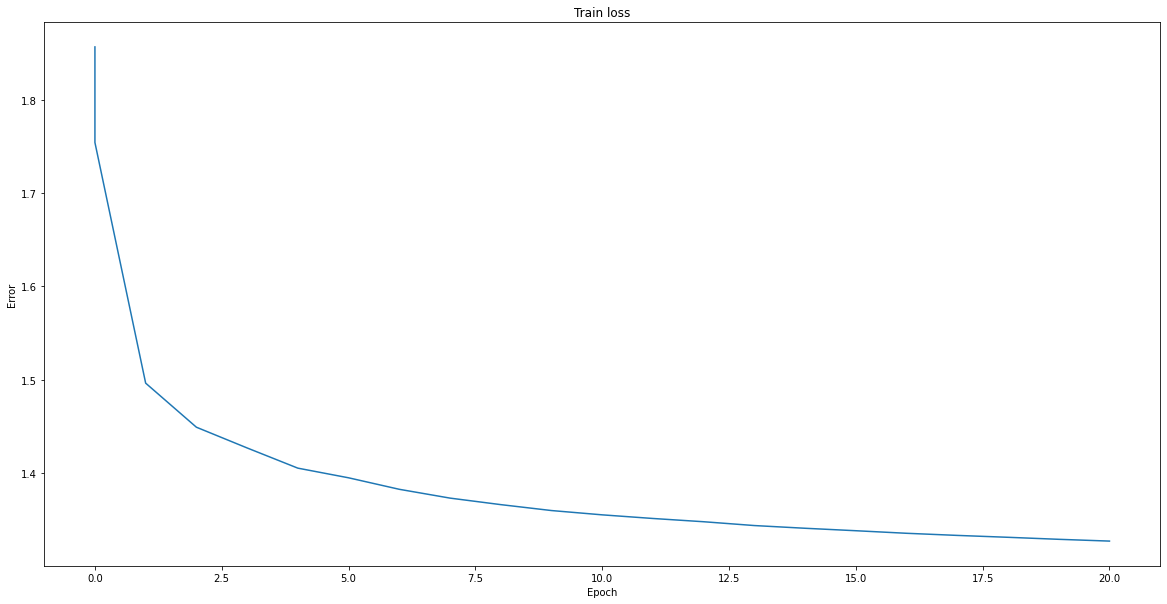

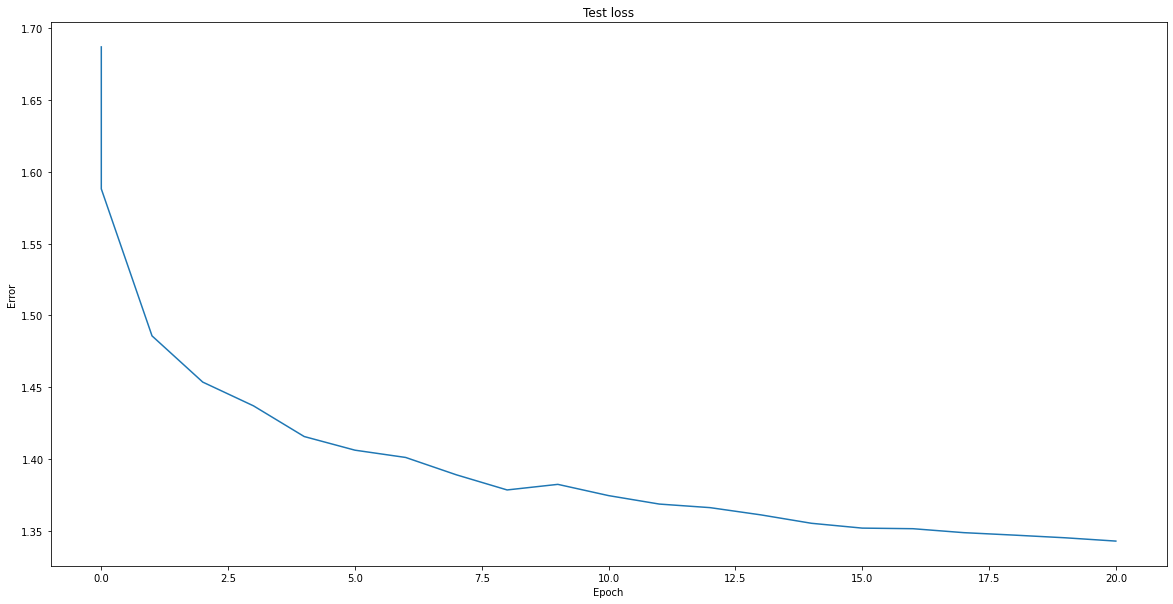

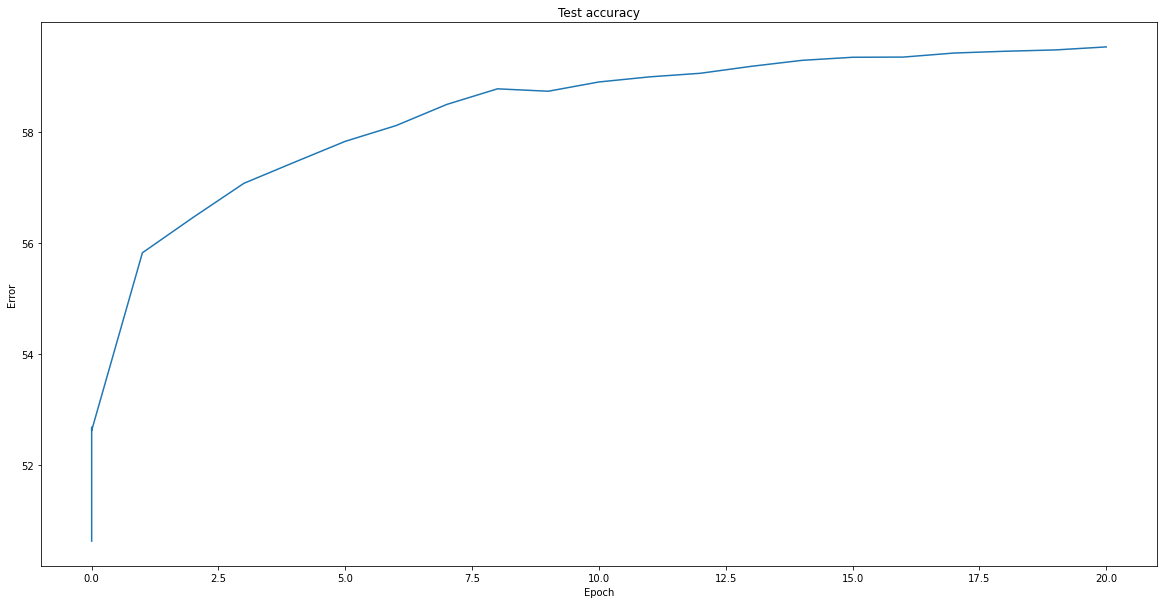

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

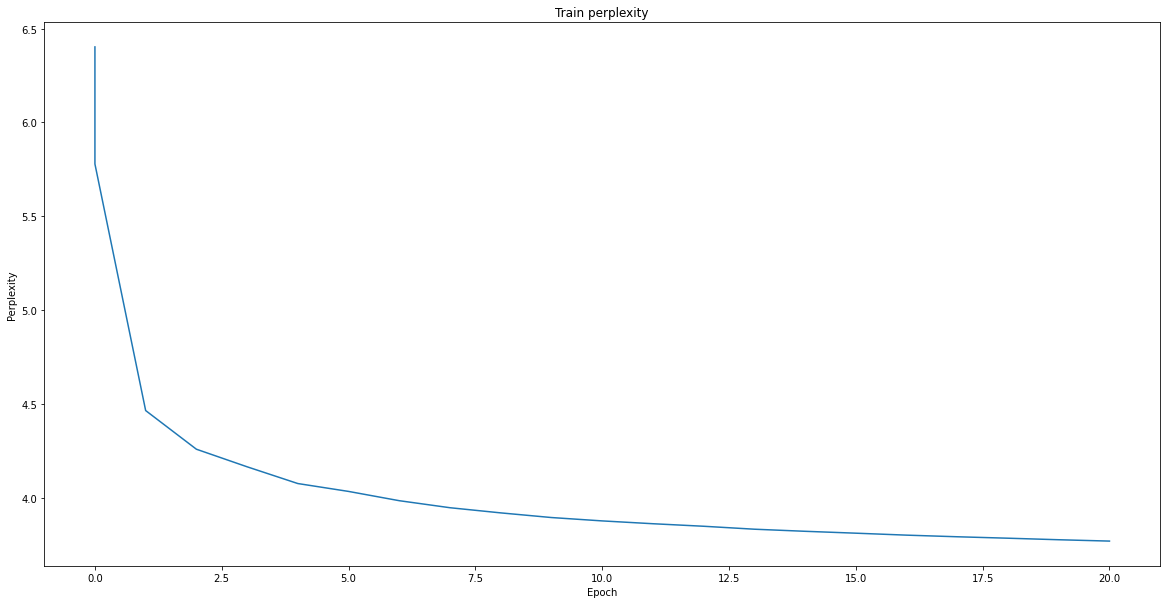

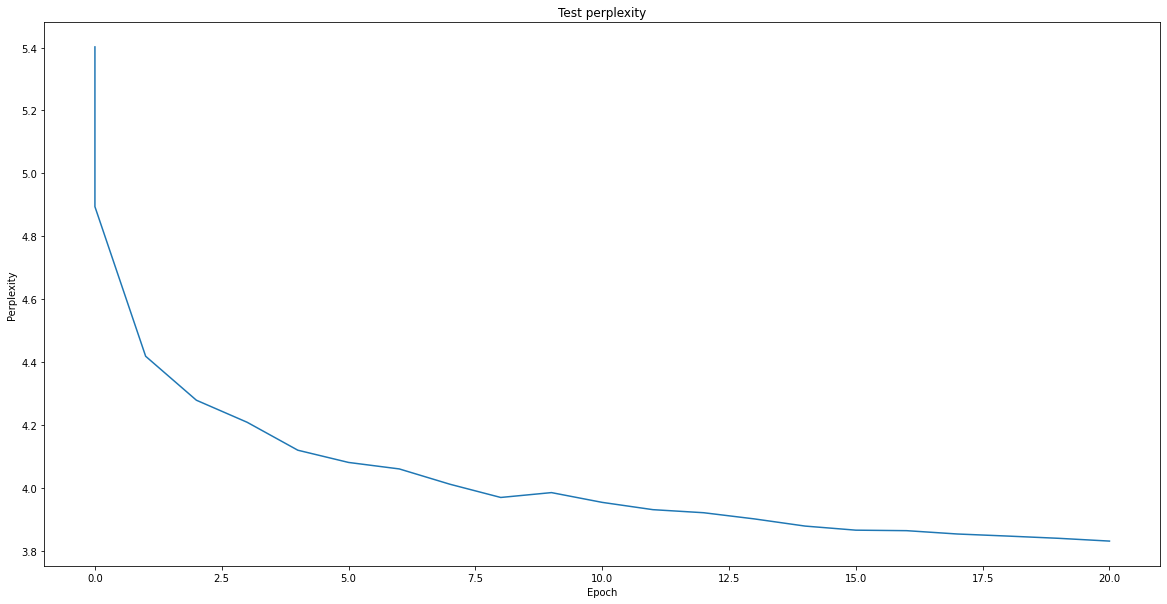

Train Perplexity:  3.770137292174661
Test Perplexity:  3.830595088343281


In [ ]:
LOG_PATH = DATA_PATH + 'logs/log.pkl'
train_loss, test_loss, test_accuracy = pt_util.read_log(LOG_PATH, ([], [], []))
epochs, plogn = zip(*train_loss)
train_perplexity = np.exp(plogn)
pt_util.plot(epochs, train_perplexity, 'Train perplexity', 'Epoch', 'Perplexity')
epochs, plogn = zip(*test_loss)
test_perplexity = np.exp(plogn)
pt_util.plot(epochs, test_perplexity, 'Test perplexity', 'Epoch', 'Perplexity')
print("Train Perplexity: ", train_perplexity[-1])
print("Test Perplexity: ",test_perplexity[-1])

#Part 7: Experiments

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the start of the staff the staff the staff the staff the staff the stairs and the start of the stairs and the start of the stairs and the start of the stairs and the start of the stairs and the start of 
generated with sample	 Harry Potter and the pordrit, the twins were head looked at the eld what had had just not had to say at the elf after Harry to the family. "I think then he say and turn years at left, I should see her wand to do the drig
generated with sample	 Harry Potter and then to make it already to take the grounds, and the corred day enormous care and shop at Hermione had to stafted the end of the forest of the two arm of the shadow of the band. As the mad look told him 
generated with sample	 Harry Potter and the ground. "You don't be stunn, there was so that this were be all before the vaguar would be up and disapport. Moody was so that mind be as the first that the best after the way the master and it saw i
generated with sample	 Harr

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



# Part 8.1: Training on a different text corpus - The Lord Of The Rings

In [50]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'LOTR.txt')):
    os.chdir(BASE_PATH)
    !cp LOTR.txt /content
os.chdir('/content')

In [44]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    voc2ind = {}
    index = 0
    space = " "
    data = data.split()
    data = space.join(data)
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    for char in data:
        if char not in voc2ind:
          voc2ind[char] = index
          index += 1


    ind2voc = {val: key for key, val in voc2ind.items()}

    eighty_percent = int(0.8 * len(data))
    train_text = data[:eighty_percent]
    test_text = data[eighty_percent:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'LOTR_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'LOTR_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'LOTR.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

In [45]:
import math

class LOTRDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(LOTRDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.tokens = dataset['tokens']
        self.voc2ind = dataset['voc2ind']
        self.n = len(self.tokens) - (len(self.tokens) % batch_size) 
        self.data_batches = torch.LongTensor([self.voc2ind[self.tokens[i]] for i in range(self.n)]).view(batch_size, -1)
        self.unique_seqs = math.ceil((self.data_batches.shape[1] - 1) / self.sequence_length) * self.data_batches.shape[0]

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return self.unique_seqs
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        batch = idx % self.batch_size
        sequence = idx // self.batch_size

        seq_begin = sequence * self.sequence_length
        seq_end = seq_begin + self.sequence_length + 1
        selection = self.data_batches[batch][seq_begin:min(self.data_batches.shape[1], seq_end)]
        return selection[:-1], selection[1:]

    def vocab_size(self):
        return len(self.vocab)

Using device cuda
num workers: 2
Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	Aê8l*DDpmCCP*//Z*lZDDUDC5mz_I7i8lZ:úP*lC?C7ZáCCz75Dîl:mB:CCpCCûZZUU?77DpmCC"ú44A=?j7á7;Z5zSl:ZzCCCll


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	CDîmS*/"uBp/ZÉúê*B:GBpûlCCJJZjE45llKD4**:DDpGv::nlSZP4PDBlKQCCCScbKëlGFjDúABK4l:UUéáéPUB:CáéD*CJ;-Dé



Test set: Average loss: 19.2969, Accuracy: 2407/512000 (0%)



  3%|▎         | 2/79 [00:00<00:16,  4.54it/s]

Train Epoch: 0 [0/20224 (0%)]	Loss: 19.189873


 15%|█▌        | 12/79 [00:02<00:11,  5.88it/s]

Train Epoch: 0 [2560/20224 (13%)]	Loss: 10.807328


 28%|██▊       | 22/79 [00:03<00:09,  5.76it/s]

Train Epoch: 0 [5120/20224 (25%)]	Loss: 5.622723


 41%|████      | 32/79 [00:05<00:07,  5.88it/s]

Train Epoch: 0 [7680/20224 (38%)]	Loss: 3.751060


 53%|█████▎    | 42/79 [00:07<00:06,  5.87it/s]

Train Epoch: 0 [10240/20224 (51%)]	Loss: 2.889617


 66%|██████▌   | 52/79 [00:08<00:04,  5.84it/s]

Train Epoch: 0 [12800/20224 (63%)]	Loss: 3.117789


 78%|███████▊  | 62/79 [00:10<00:02,  5.77it/s]

Train Epoch: 0 [15360/20224 (76%)]	Loss: 3.257946


 91%|█████████ | 72/79 [00:12<00:01,  5.81it/s]

Train Epoch: 0 [17920/20224 (89%)]	Loss: 3.451625


100%|██████████| 79/79 [00:13<00:00,  5.79it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 hen wond.Ghet winlil ooong   se salltl  aand wot mirwn lorr   'Io,  said Gipppn. aaat ao, ''nd ffer


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	ehilh wlead wans. ooattd op tuf err thi lirle  'os on woened otoogg rf otlldt  Borfotgttofdcooll ,of



Test set: Average loss: 2.6173, Accuracy: 204737/512000 (40%)

Saved /content/checkpoints_lord_of_the_rings2/000.pt

generated max		 Gandalf looked at Frodo. 'And whilled be befain dered bere of and whilled be of and befen thing and befen thing and beled in the leat it wat ithing and meled of the willl ear brodow no dread whilled be beled bere of and whil
gen

  3%|▎         | 2/79 [00:00<00:18,  4.15it/s]

Train Epoch: 1 [0/20224 (0%)]	Loss: 2.626167


 15%|█▌        | 12/79 [00:02<00:11,  5.74it/s]

Train Epoch: 1 [2560/20224 (13%)]	Loss: 2.255881


 28%|██▊       | 22/79 [00:03<00:09,  5.83it/s]

Train Epoch: 1 [5120/20224 (25%)]	Loss: 1.997295


 41%|████      | 32/79 [00:05<00:07,  5.88it/s]

Train Epoch: 1 [7680/20224 (38%)]	Loss: 1.961786


 53%|█████▎    | 42/79 [00:07<00:06,  5.74it/s]

Train Epoch: 1 [10240/20224 (51%)]	Loss: 1.866274


 66%|██████▌   | 52/79 [00:09<00:04,  5.89it/s]

Train Epoch: 1 [12800/20224 (63%)]	Loss: 2.320705


 78%|███████▊  | 62/79 [00:10<00:02,  5.75it/s]

Train Epoch: 1 [15360/20224 (76%)]	Loss: 2.054397


 91%|█████████ | 72/79 [00:12<00:01,  5.82it/s]

Train Epoch: 1 [17920/20224 (89%)]	Loss: 2.124796


100%|██████████| 79/79 [00:13<00:00,  5.77it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 héy haid ihat iaahas aiong   se hadhtr  taid hot iaaht iiari  'Iot' said iippin. iao  hoai''td haer


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	hiith hieetiiirssttitttd tpototherd the hatl   'os ht iiemed tiiiigess tinidt  Tottotghshfetiapth hf



Test set: Average loss: 2.1674, Accuracy: 213387/512000 (42%)

Saved /content/checkpoints_lord_of_the_rings2/001.pt

generated max		 Gandalf looked at Frodo. 'I have that it in his had in a his had in a his had in a his had in a his had in a his had in a his had in a his had in a his had in a his had in a his had in a his had in a his had in a his had in 
gen

  1%|▏         | 1/79 [00:00<00:25,  3.07it/s]

Train Epoch: 2 [0/20224 (0%)]	Loss: 2.137868


 15%|█▌        | 12/79 [00:02<00:11,  5.83it/s]

Train Epoch: 2 [2560/20224 (13%)]	Loss: 2.057058


 28%|██▊       | 22/79 [00:03<00:09,  5.96it/s]

Train Epoch: 2 [5120/20224 (25%)]	Loss: 1.969473


 41%|████      | 32/79 [00:05<00:07,  5.90it/s]

Train Epoch: 2 [7680/20224 (38%)]	Loss: 1.888640


 53%|█████▎    | 42/79 [00:07<00:06,  5.85it/s]

Train Epoch: 2 [10240/20224 (51%)]	Loss: 2.291176


 66%|██████▌   | 52/79 [00:09<00:04,  5.86it/s]

Train Epoch: 2 [12800/20224 (63%)]	Loss: 1.984173


 78%|███████▊  | 62/79 [00:10<00:02,  5.82it/s]

Train Epoch: 2 [15360/20224 (76%)]	Loss: 1.892087


 91%|█████████ | 72/79 [00:12<00:01,  5.74it/s]

Train Epoch: 2 [17920/20224 (89%)]	Loss: 1.805173


100%|██████████| 79/79 [00:13<00:00,  5.79it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 her waid thet te las aoeng   se sadntr, aand tot teadt aoer   'Iot  said Gippin. aaot aet ''nd tner


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	theth trett tarss testtd tn trtteentthe tetl   'es tt weemed taoonged  tanedt  Tottotth on thallh af



Test set: Average loss: 1.8312, Accuracy: 246828/512000 (48%)

Saved /content/checkpoints_lord_of_the_rings2/002.pt

generated max		 Gandalf looked at Frodo. 'I have the ened the there there there there there there there there there there there there there there there there there there there there there there there there there there there there there ther
gen

  3%|▎         | 2/79 [00:00<00:16,  4.66it/s]

Train Epoch: 3 [0/20224 (0%)]	Loss: 1.809769


 15%|█▌        | 12/79 [00:02<00:11,  5.70it/s]

Train Epoch: 3 [2560/20224 (13%)]	Loss: 1.770957


 28%|██▊       | 22/79 [00:03<00:09,  5.85it/s]

Train Epoch: 3 [5120/20224 (25%)]	Loss: 1.763302


 41%|████      | 32/79 [00:05<00:08,  5.82it/s]

Train Epoch: 3 [7680/20224 (38%)]	Loss: 1.786880


 53%|█████▎    | 42/79 [00:07<00:06,  5.86it/s]

Train Epoch: 3 [10240/20224 (51%)]	Loss: 1.736570


 66%|██████▌   | 52/79 [00:08<00:04,  5.86it/s]

Train Epoch: 3 [12800/20224 (63%)]	Loss: 1.702107


 78%|███████▊  | 62/79 [00:10<00:02,  5.90it/s]

Train Epoch: 3 [15360/20224 (76%)]	Loss: 1.687342


 91%|█████████ | 72/79 [00:12<00:01,  5.91it/s]

Train Epoch: 3 [17920/20224 (89%)]	Loss: 1.651476


100%|██████████| 79/79 [00:13<00:00,  5.80it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  said thet ie was aoeng   se sadntr. aans wot ti ht toer   'Io,  said Gippin. aaot hot ''nd wver


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	tiith hreet toredttoartd wp tutteen the hisl   'ot tt weemed ttoangery atlent  Tottotce tf thoulh of



Test set: Average loss: 1.6363, Accuracy: 268173/512000 (52%)

Saved /content/checkpoints_lord_of_the_rings2/003.pt

generated max		 Gandalf looked at Frodo. 'I have the Ents of the Ents of the hill have the hill have the hill not the light and his hand and his hand and his hand and his hand and his hand and his hand and his hand and his hand and his hand
gen

  1%|▏         | 1/79 [00:00<00:24,  3.15it/s]

Train Epoch: 4 [0/20224 (0%)]	Loss: 1.616570


 15%|█▌        | 12/79 [00:02<00:11,  5.85it/s]

Train Epoch: 4 [2560/20224 (13%)]	Loss: 1.711494


 28%|██▊       | 22/79 [00:03<00:09,  5.70it/s]

Train Epoch: 4 [5120/20224 (25%)]	Loss: 1.831995


 41%|████      | 32/79 [00:05<00:08,  5.80it/s]

Train Epoch: 4 [7680/20224 (38%)]	Loss: 1.837679


 53%|█████▎    | 42/79 [00:07<00:06,  5.85it/s]

Train Epoch: 4 [10240/20224 (51%)]	Loss: 1.662895


 66%|██████▌   | 52/79 [00:09<00:04,  5.85it/s]

Train Epoch: 4 [12800/20224 (63%)]	Loss: 1.709286


 78%|███████▊  | 62/79 [00:10<00:02,  5.84it/s]

Train Epoch: 4 [15360/20224 (76%)]	Loss: 1.691873


 91%|█████████ | 72/79 [00:12<00:01,  5.68it/s]

Train Epoch: 4 [17920/20224 (89%)]	Loss: 1.722572


100%|██████████| 79/79 [00:13<00:00,  5.76it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  haid ahet ii his aa ng   he hadntd. aand het mi hs arad   'To,  haid Gippin. aao  iea ''nd hven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	teich hreat aorss aaaned ap aehteen the hill   Tot is iiemed taoange l aalvnci Tortetce af mporl. of



Test set: Average loss: 1.7553, Accuracy: 252881/512000 (49%)

generated max		 Gandalf looked at Frodo. 'The is a his and his and his and his and his and his and his and his and his and his and his and his and his and his and his and his and his and his and his and his and his and his and his and his a
generated sample	 Gandalf looked at Frodo. 'And Pippe and

  3%|▎         | 2/79 [00:00<00:19,  3.99it/s]

Train Epoch: 5 [0/20224 (0%)]	Loss: 1.731643


 15%|█▌        | 12/79 [00:02<00:11,  5.80it/s]

Train Epoch: 5 [2560/20224 (13%)]	Loss: 1.650066


 28%|██▊       | 22/79 [00:03<00:09,  5.84it/s]

Train Epoch: 5 [5120/20224 (25%)]	Loss: 1.587549


 41%|████      | 32/79 [00:05<00:08,  5.87it/s]

Train Epoch: 5 [7680/20224 (38%)]	Loss: 1.627769


 53%|█████▎    | 42/79 [00:07<00:06,  5.92it/s]

Train Epoch: 5 [10240/20224 (51%)]	Loss: 1.599341


 66%|██████▌   | 52/79 [00:09<00:04,  5.83it/s]

Train Epoch: 5 [12800/20224 (63%)]	Loss: 1.877289


 78%|███████▊  | 62/79 [00:10<00:02,  5.75it/s]

Train Epoch: 5 [15360/20224 (76%)]	Loss: 1.817878


 91%|█████████ | 72/79 [00:12<00:01,  5.87it/s]

Train Epoch: 5 [17920/20224 (89%)]	Loss: 1.744978


100%|██████████| 79/79 [00:13<00:00,  5.77it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  aaid thet ta was aoang   ae sadntd, aand het aa st aoer   'Tot  haid Gippin  aaat aot 'Ind hner


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	taach aaeat aarss aasred ap aufteen the lasls  'et ut weemed taoange s aanent, Io tetne af saaulh af



Test set: Average loss: 1.6367, Accuracy: 265235/512000 (52%)

generated max		 Gandalf looked at Frodo. 'The light a so far a more said the land and his little and his and his and a little and his and his and a little and his and his and his and a little and his and his and his and a little and his and
generated sample	 Gandalf looked at Frodo. He said his lo

  3%|▎         | 2/79 [00:00<00:16,  4.58it/s]

Train Epoch: 6 [0/20224 (0%)]	Loss: 1.604681


 15%|█▌        | 12/79 [00:02<00:11,  5.79it/s]

Train Epoch: 6 [2560/20224 (13%)]	Loss: 1.614596


 28%|██▊       | 22/79 [00:03<00:09,  5.88it/s]

Train Epoch: 6 [5120/20224 (25%)]	Loss: 1.571633


 41%|████      | 32/79 [00:05<00:08,  5.78it/s]

Train Epoch: 6 [7680/20224 (38%)]	Loss: 1.555171


 53%|█████▎    | 42/79 [00:07<00:06,  5.87it/s]

Train Epoch: 6 [10240/20224 (51%)]	Loss: 1.496206


 66%|██████▌   | 52/79 [00:09<00:04,  5.78it/s]

Train Epoch: 6 [12800/20224 (63%)]	Loss: 1.503949


 78%|███████▊  | 62/79 [00:10<00:02,  5.85it/s]

Train Epoch: 6 [15360/20224 (76%)]	Loss: 1.553998


 91%|█████████ | 72/79 [00:12<00:01,  5.93it/s]

Train Epoch: 6 [17920/20224 (89%)]	Loss: 1.570766


100%|██████████| 79/79 [00:13<00:00,  5.79it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  waid toet wa was ao ng   se sadntd. aans wot ma ss aoed   'Io,  said Gippin  aaot hot 'Ind wnen


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	taalh aaeat aorsstaaaned wp auhween the sasl   Tot un waemed taoange y aalent  Iowtotse tf taaulh af



Test set: Average loss: 1.5770, Accuracy: 271710/512000 (53%)

Saved /content/checkpoints_lord_of_the_rings2/006.pt

generated max		 Gandalf looked at Frodo. 'I am and his for a while to the land of the land said the land was a said the land and said the land was a said the land and said the land was a said the land and said the land was a said the land a
gen

  3%|▎         | 2/79 [00:00<00:19,  3.93it/s]

Train Epoch: 7 [0/20224 (0%)]	Loss: 1.548425


 15%|█▌        | 12/79 [00:02<00:11,  5.91it/s]

Train Epoch: 7 [2560/20224 (13%)]	Loss: 1.544946


 28%|██▊       | 22/79 [00:03<00:09,  5.91it/s]

Train Epoch: 7 [5120/20224 (25%)]	Loss: 1.513588


 41%|████      | 32/79 [00:05<00:07,  5.88it/s]

Train Epoch: 7 [7680/20224 (38%)]	Loss: 1.527254


 53%|█████▎    | 42/79 [00:07<00:06,  5.82it/s]

Train Epoch: 7 [10240/20224 (51%)]	Loss: 1.469105


 66%|██████▌   | 52/79 [00:09<00:04,  5.82it/s]

Train Epoch: 7 [12800/20224 (63%)]	Loss: 1.487134


 78%|███████▊  | 62/79 [00:10<00:02,  5.88it/s]

Train Epoch: 7 [15360/20224 (76%)]	Loss: 1.493717


 91%|█████████ | 72/79 [00:12<00:01,  5.77it/s]

Train Epoch: 7 [17920/20224 (89%)]	Loss: 1.504701


100%|██████████| 79/79 [00:13<00:00,  5.77it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  said thet te sas ao ng   se sadntd. aans tot ta ss aoed   'Tot  said Gippin. aaot sot 'Ind tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	taath treat srrssttoased tp tehteen the sasls  Tet tt weemed tooange s atlent  Tottotse tf tooulh of



Test set: Average loss: 1.4995, Accuracy: 281461/512000 (55%)

Saved /content/checkpoints_lord_of_the_rings2/007.pt

generated max		 Gandalf looked at Frodo. 'I do not know the trees of the stood and strange the said the said. 'The said the said the said. 'The said the said the said. 'The said the said the said. 'The said the said the said. 'The said the 
gen

  3%|▎         | 2/79 [00:00<00:18,  4.22it/s]

Train Epoch: 8 [0/20224 (0%)]	Loss: 1.470267


 15%|█▌        | 12/79 [00:02<00:11,  5.77it/s]

Train Epoch: 8 [2560/20224 (13%)]	Loss: 1.481071


 28%|██▊       | 22/79 [00:03<00:09,  5.83it/s]

Train Epoch: 8 [5120/20224 (25%)]	Loss: 1.532797


 41%|████      | 32/79 [00:05<00:08,  5.87it/s]

Train Epoch: 8 [7680/20224 (38%)]	Loss: 1.528868


 53%|█████▎    | 42/79 [00:07<00:06,  5.72it/s]

Train Epoch: 8 [10240/20224 (51%)]	Loss: 1.481764


 66%|██████▌   | 52/79 [00:09<00:04,  5.85it/s]

Train Epoch: 8 [12800/20224 (63%)]	Loss: 1.506068


 78%|███████▊  | 62/79 [00:10<00:02,  5.83it/s]

Train Epoch: 8 [15360/20224 (76%)]	Loss: 1.500617


 91%|█████████ | 72/79 [00:12<00:01,  5.95it/s]

Train Epoch: 8 [17920/20224 (89%)]	Loss: 1.489009


100%|██████████| 79/79 [00:13<00:00,  5.78it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  said thet ie sas aoing   se sadntd. aand tot ti ss aoed.  'Io,  said Gippin. aaot hot  Ind tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	tieth treat srrsstoiased tp tehween the sosls  Tot tt ieemed toiange s atlent  Tottotse tf tooulh of



Test set: Average loss: 1.4824, Accuracy: 283498/512000 (55%)

Saved /content/checkpoints_lord_of_the_rings2/008.pt

generated max		 Gandalf looked at Frodo. 'I do not know the trees of the light of the short of the short of the short of the short of the short of the short of the short of the short of the short of the short of the short of the short of th
gen

  3%|▎         | 2/79 [00:00<00:16,  4.63it/s]

Train Epoch: 9 [0/20224 (0%)]	Loss: 1.452231


 15%|█▌        | 12/79 [00:02<00:11,  5.71it/s]

Train Epoch: 9 [2560/20224 (13%)]	Loss: 1.448433


 28%|██▊       | 22/79 [00:03<00:09,  5.85it/s]

Train Epoch: 9 [5120/20224 (25%)]	Loss: 1.467859


 41%|████      | 32/79 [00:05<00:08,  5.87it/s]

Train Epoch: 9 [7680/20224 (38%)]	Loss: 1.500973


 53%|█████▎    | 42/79 [00:07<00:06,  5.90it/s]

Train Epoch: 9 [10240/20224 (51%)]	Loss: 1.621874


 66%|██████▌   | 52/79 [00:09<00:04,  5.86it/s]

Train Epoch: 9 [12800/20224 (63%)]	Loss: 1.516293


 78%|███████▊  | 62/79 [00:10<00:02,  5.87it/s]

Train Epoch: 9 [15360/20224 (76%)]	Loss: 1.491251


 91%|█████████ | 72/79 [00:12<00:01,  5.78it/s]

Train Epoch: 9 [17920/20224 (89%)]	Loss: 1.481018


100%|██████████| 79/79 [00:13<00:00,  5.78it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  said thet ia was aoing   se sadntd. aand tot taawt aoar.  'Iot  said Gippin  aaot hot  Ind tver


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	thath treet srrs twifred ap aehween the sasls  Tet tt ieemed toaange y atlenc  Tottotse tf toarlh af



Test set: Average loss: 1.4662, Accuracy: 285425/512000 (56%)

Saved /content/checkpoints_lord_of_the_rings2/009.pt

generated max		 Gandalf looked at Frodo. 'I have the remained the said the light of the light of the light of the light of the light of the light of the light of the light of the light of the light of the light of the light of the light of 
gen

  3%|▎         | 2/79 [00:00<00:18,  4.09it/s]

Train Epoch: 10 [0/20224 (0%)]	Loss: 1.437638


 15%|█▌        | 12/79 [00:02<00:11,  5.81it/s]

Train Epoch: 10 [2560/20224 (13%)]	Loss: 1.431274


 28%|██▊       | 22/79 [00:03<00:09,  5.90it/s]

Train Epoch: 10 [5120/20224 (25%)]	Loss: 1.426909


 41%|████      | 32/79 [00:05<00:08,  5.69it/s]

Train Epoch: 10 [7680/20224 (38%)]	Loss: 1.456434


 53%|█████▎    | 42/79 [00:07<00:06,  5.90it/s]

Train Epoch: 10 [10240/20224 (51%)]	Loss: 1.411764


 66%|██████▌   | 52/79 [00:09<00:04,  5.88it/s]

Train Epoch: 10 [12800/20224 (63%)]	Loss: 1.422570


 78%|███████▊  | 62/79 [00:10<00:02,  5.85it/s]

Train Epoch: 10 [15360/20224 (76%)]	Loss: 1.441640


 91%|█████████ | 72/79 [00:12<00:01,  5.88it/s]

Train Epoch: 10 [17920/20224 (89%)]	Loss: 1.461237


100%|██████████| 79/79 [00:13<00:00,  5.76it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  said thet wa sas aaing   se sadntd. aand wot saass aoad.  'Iot  said Gippin. aaot sot  Ind wven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	taath areat srrs twiased ap aafween the sasls  Tot tt weemed toaange s atnenc  Tottotse af soarlh af



Test set: Average loss: 1.4745, Accuracy: 283555/512000 (55%)

generated max		 Gandalf looked at Frodo. 'I am said Gandalf and had said that was a stair. `I am saw that the said that was a start and start and start and start and start and start and start and start and start and start and start and star
generated sample	 Gandalf looked at Frodo. 'He is not fol

  1%|▏         | 1/79 [00:00<00:25,  3.09it/s]

Train Epoch: 11 [0/20224 (0%)]	Loss: 1.443206


 15%|█▌        | 12/79 [00:02<00:11,  5.84it/s]

Train Epoch: 11 [2560/20224 (13%)]	Loss: 1.456875


 28%|██▊       | 22/79 [00:03<00:09,  5.84it/s]

Train Epoch: 11 [5120/20224 (25%)]	Loss: 1.472347


 41%|████      | 32/79 [00:05<00:07,  5.93it/s]

Train Epoch: 11 [7680/20224 (38%)]	Loss: 1.487134


 53%|█████▎    | 42/79 [00:07<00:06,  5.87it/s]

Train Epoch: 11 [10240/20224 (51%)]	Loss: 1.446052


 66%|██████▌   | 52/79 [00:09<00:04,  5.85it/s]

Train Epoch: 11 [12800/20224 (63%)]	Loss: 1.438354


 78%|███████▊  | 62/79 [00:10<00:02,  5.84it/s]

Train Epoch: 11 [15360/20224 (76%)]	Loss: 1.440400


 91%|█████████ | 72/79 [00:12<00:01,  5.90it/s]

Train Epoch: 11 [17920/20224 (89%)]	Loss: 1.446735


100%|██████████| 79/79 [00:13<00:00,  5.76it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  said thet ta was aoing   se sadntd. aand tot ta ws aoad.  'Iot  said Gippin. aaot tot  Ind tver


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	tiath treat srrs twiared tp aefween the tatls  Tot tt weemed toiange y atnenc  Tottotse tf toarlh af



Test set: Average loss: 1.4419, Accuracy: 289042/512000 (56%)

Saved /content/checkpoints_lord_of_the_rings2/011.pt

generated max		 Gandalf looked at Frodo. 'I do not know that it was a long the way to the strange to the strange to the strange to the strange to the strange to the strange to the strange to the strange to the strange to the strange to the 
gen

  3%|▎         | 2/79 [00:00<00:16,  4.81it/s]

Train Epoch: 12 [0/20224 (0%)]	Loss: 1.410912


 15%|█▌        | 12/79 [00:02<00:11,  5.81it/s]

Train Epoch: 12 [2560/20224 (13%)]	Loss: 1.406229


 28%|██▊       | 22/79 [00:03<00:09,  5.85it/s]

Train Epoch: 12 [5120/20224 (25%)]	Loss: 1.422737


 41%|████      | 32/79 [00:05<00:07,  5.88it/s]

Train Epoch: 12 [7680/20224 (38%)]	Loss: 1.452426


 53%|█████▎    | 42/79 [00:07<00:06,  5.91it/s]

Train Epoch: 12 [10240/20224 (51%)]	Loss: 1.418915


 66%|██████▌   | 52/79 [00:08<00:04,  5.88it/s]

Train Epoch: 12 [12800/20224 (63%)]	Loss: 1.405622


 78%|███████▊  | 62/79 [00:10<00:02,  5.74it/s]

Train Epoch: 12 [15360/20224 (76%)]	Loss: 1.465815


 91%|█████████ | 72/79 [00:12<00:01,  5.85it/s]

Train Epoch: 12 [17920/20224 (89%)]	Loss: 1.453733


100%|██████████| 79/79 [00:13<00:00,  5.81it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  said thet ta was aaing   se sadhtd. atnd tot ta ws aoad.  'Iot  said Gippin. aaot tot 'Ind tver


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	theth treat trrs toifded tp aehween the satls  Tot tt weemed tooange y atlenc, Tottotse tf toarle of



Test set: Average loss: 1.4426, Accuracy: 288952/512000 (56%)

generated max		 Gandalf looked at Frodo. 'I have to the trees of the words of the woods of the soon of the stood and his hand and the shadows of the shadows of the stood and his hand and the stood and his hand and his hand and his hand and 
generated sample	 Gandalf looked at Frodo. Frodo was good

  1%|▏         | 1/79 [00:00<00:25,  3.07it/s]

Train Epoch: 13 [0/20224 (0%)]	Loss: 1.412004


 15%|█▌        | 12/79 [00:02<00:11,  5.82it/s]

Train Epoch: 13 [2560/20224 (13%)]	Loss: 1.394646


 28%|██▊       | 22/79 [00:03<00:09,  5.79it/s]

Train Epoch: 13 [5120/20224 (25%)]	Loss: 1.397186


 41%|████      | 32/79 [00:05<00:08,  5.83it/s]

Train Epoch: 13 [7680/20224 (38%)]	Loss: 1.429839


 53%|█████▎    | 42/79 [00:07<00:06,  5.86it/s]

Train Epoch: 13 [10240/20224 (51%)]	Loss: 1.396352


 66%|██████▌   | 52/79 [00:09<00:04,  5.96it/s]

Train Epoch: 13 [12800/20224 (63%)]	Loss: 1.400527


 78%|███████▊  | 62/79 [00:10<00:02,  5.87it/s]

Train Epoch: 13 [15360/20224 (76%)]	Loss: 1.416375


 91%|█████████ | 72/79 [00:12<00:01,  5.82it/s]

Train Epoch: 13 [17920/20224 (89%)]	Loss: 1.434857


100%|██████████| 79/79 [00:13<00:00,  5.77it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  said thet ta was aaing   se sadhtd. aand tot ta ws aoad.  'Iot  said Gippin. aaot tot 'Ind tver


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	theth treat trre twifded tp arfween the tatls  Tot tt weemed ttaange y ttlent, Tottotse tf ttarlh af



Test set: Average loss: 1.4399, Accuracy: 288945/512000 (56%)

generated max		 Gandalf looked at Frodo. 'I would not the trees and the trees of the trees of the trees of the trees of the trees of the trees of the trees of the trees of the trees of the trees of the trees of the trees of the trees and th
generated sample	 Gandalf looked at Frodo. The first were

  3%|▎         | 2/79 [00:00<00:19,  3.94it/s]

Train Epoch: 14 [0/20224 (0%)]	Loss: 1.410792


 15%|█▌        | 12/79 [00:02<00:11,  5.85it/s]

Train Epoch: 14 [2560/20224 (13%)]	Loss: 1.389911


 28%|██▊       | 22/79 [00:03<00:09,  5.83it/s]

Train Epoch: 14 [5120/20224 (25%)]	Loss: 1.396180


 41%|████      | 32/79 [00:05<00:08,  5.80it/s]

Train Epoch: 14 [7680/20224 (38%)]	Loss: 1.430982


 53%|█████▎    | 42/79 [00:07<00:06,  5.80it/s]

Train Epoch: 14 [10240/20224 (51%)]	Loss: 1.420116


 66%|██████▌   | 52/79 [00:09<00:04,  5.74it/s]

Train Epoch: 14 [12800/20224 (63%)]	Loss: 1.400796


 78%|███████▊  | 62/79 [00:10<00:02,  5.82it/s]

Train Epoch: 14 [15360/20224 (76%)]	Loss: 1.408090


 91%|█████████ | 72/79 [00:12<00:01,  5.81it/s]

Train Epoch: 14 [17920/20224 (89%)]	Loss: 1.417337


100%|██████████| 79/79 [00:13<00:00,  5.76it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  said thet wa was aaing   se sadntd. aand tot ta ws aoad.  'Iot  said Gippin. aaot tot 'Ind tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	taeth treat sors twifded tp aafween the satls  Tot tt weemed toaange y atlenc, Tottotse tf toaule af



Test set: Average loss: 1.4221, Accuracy: 291033/512000 (57%)

Saved /content/checkpoints_lord_of_the_rings2/014.pt

generated max		 Gandalf looked at Frodo. 'I would not say to the took of the water, and the way of the water to the stars of the water. The was a start and the start of the stars of the water. The was a start and the start of the stars of t
gen

  3%|▎         | 2/79 [00:00<00:16,  4.72it/s]

Train Epoch: 15 [0/20224 (0%)]	Loss: 1.392773


 15%|█▌        | 12/79 [00:02<00:11,  5.75it/s]

Train Epoch: 15 [2560/20224 (13%)]	Loss: 1.384846


 28%|██▊       | 22/79 [00:03<00:09,  5.78it/s]

Train Epoch: 15 [5120/20224 (25%)]	Loss: 1.397430


 41%|████      | 32/79 [00:05<00:08,  5.79it/s]

Train Epoch: 15 [7680/20224 (38%)]	Loss: 1.412540


 53%|█████▎    | 42/79 [00:07<00:06,  5.83it/s]

Train Epoch: 15 [10240/20224 (51%)]	Loss: 1.386490


 66%|██████▌   | 52/79 [00:08<00:04,  5.84it/s]

Train Epoch: 15 [12800/20224 (63%)]	Loss: 1.379973


 78%|███████▊  | 62/79 [00:10<00:02,  5.88it/s]

Train Epoch: 15 [15360/20224 (76%)]	Loss: 1.398853


 91%|█████████ | 72/79 [00:12<00:01,  5.84it/s]

Train Epoch: 15 [17920/20224 (89%)]	Loss: 1.411716


100%|██████████| 79/79 [00:13<00:00,  5.79it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  said thet ta was aaing   se sadhtd. aand tot ta ws aoad.  'Iot  said Gippin. aaot tot 'Ind tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	taeth treat sors twiaded tp aafween the tatls  Tot tt weemed toaange y atlent, Tottotse tf toaulh af



Test set: Average loss: 1.4163, Accuracy: 291974/512000 (57%)

Saved /content/checkpoints_lord_of_the_rings2/015.pt

generated max		 Gandalf looked at Frodo. 'I would not say to the trees of the water, and the trees of the water that they were the trees of the water that they were the trees of the water that they were the trees of the trees of the water. 
gen

  3%|▎         | 2/79 [00:00<00:18,  4.21it/s]

Train Epoch: 16 [0/20224 (0%)]	Loss: 1.386704


 15%|█▌        | 12/79 [00:02<00:11,  5.80it/s]

Train Epoch: 16 [2560/20224 (13%)]	Loss: 1.369558


 28%|██▊       | 22/79 [00:03<00:09,  5.71it/s]

Train Epoch: 16 [5120/20224 (25%)]	Loss: 1.383335


 41%|████      | 32/79 [00:05<00:08,  5.69it/s]

Train Epoch: 16 [7680/20224 (38%)]	Loss: 1.439823


 53%|█████▎    | 42/79 [00:07<00:06,  5.78it/s]

Train Epoch: 16 [10240/20224 (51%)]	Loss: 1.390088


 66%|██████▌   | 52/79 [00:09<00:04,  5.89it/s]

Train Epoch: 16 [12800/20224 (63%)]	Loss: 1.394639


 78%|███████▊  | 62/79 [00:10<00:02,  5.95it/s]

Train Epoch: 16 [15360/20224 (76%)]	Loss: 1.393898


 91%|█████████ | 72/79 [00:12<00:01,  5.90it/s]

Train Epoch: 16 [17920/20224 (89%)]	Loss: 1.400645


100%|██████████| 79/79 [00:13<00:00,  5.75it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  said thet ta was aoing   se saghtd. aand tot te ws aoad   'Iot  said Gippin. aaot tot 'Ind tver


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	theth treat sorsstwifded tp aafween the tatls  Tot tt ieemed ttiange y ttlent, Tottotse tf ttoule af



Test set: Average loss: 1.4085, Accuracy: 292802/512000 (57%)

Saved /content/checkpoints_lord_of_the_rings2/016.pt

generated max		 Gandalf looked at Frodo. 'I would not say to the to the took of the took of the trees of the world and the way to the stood and the water to the stood and the water to the stood and the water that they saw that they saw that
gen

  3%|▎         | 2/79 [00:00<00:18,  4.10it/s]

Train Epoch: 17 [0/20224 (0%)]	Loss: 1.379457


 15%|█▌        | 12/79 [00:02<00:11,  5.92it/s]

Train Epoch: 17 [2560/20224 (13%)]	Loss: 1.369384


 28%|██▊       | 22/79 [00:03<00:09,  5.82it/s]

Train Epoch: 17 [5120/20224 (25%)]	Loss: 1.371487


 41%|████      | 32/79 [00:05<00:08,  5.83it/s]

Train Epoch: 17 [7680/20224 (38%)]	Loss: 1.408494


 53%|█████▎    | 42/79 [00:07<00:06,  5.82it/s]

Train Epoch: 17 [10240/20224 (51%)]	Loss: 1.354519


 66%|██████▌   | 52/79 [00:09<00:04,  5.87it/s]

Train Epoch: 17 [12800/20224 (63%)]	Loss: 1.370972


 78%|███████▊  | 62/79 [00:10<00:02,  5.83it/s]

Train Epoch: 17 [15360/20224 (76%)]	Loss: 1.392713


 91%|█████████ | 72/79 [00:12<00:01,  5.82it/s]

Train Epoch: 17 [17920/20224 (89%)]	Loss: 1.394993


100%|██████████| 79/79 [00:13<00:00,  5.78it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  said thet ta was aoing   se saghtd. aand tot te ws aoad   'Iot  said Gippin. aaot tot 'Ind tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	theth treat sorsstwifded tp aefween themtatls  Tot tt weemed toiongedy ttlent, Tottotse tf tooulh af



Test set: Average loss: 1.4037, Accuracy: 293572/512000 (57%)

Saved /content/checkpoints_lord_of_the_rings2/017.pt

generated max		 Gandalf looked at Frodo. 'I would not say to the to the took of the took of the took of the took of the took of the towers that they were to the took of the took of the towers that they were to the top of the towers that the
gen

  3%|▎         | 2/79 [00:00<00:15,  4.83it/s]

Train Epoch: 18 [0/20224 (0%)]	Loss: 1.374779


 15%|█▌        | 12/79 [00:02<00:11,  5.85it/s]

Train Epoch: 18 [2560/20224 (13%)]	Loss: 1.369366


 28%|██▊       | 22/79 [00:03<00:09,  5.87it/s]

Train Epoch: 18 [5120/20224 (25%)]	Loss: 1.376582


 41%|████      | 32/79 [00:05<00:08,  5.85it/s]

Train Epoch: 18 [7680/20224 (38%)]	Loss: 1.391680


 53%|█████▎    | 42/79 [00:07<00:06,  5.96it/s]

Train Epoch: 18 [10240/20224 (51%)]	Loss: 1.355421


 66%|██████▌   | 52/79 [00:08<00:04,  5.71it/s]

Train Epoch: 18 [12800/20224 (63%)]	Loss: 1.357202


 78%|███████▊  | 62/79 [00:10<00:02,  5.83it/s]

Train Epoch: 18 [15360/20224 (76%)]	Loss: 1.375978


 91%|█████████ | 72/79 [00:12<00:01,  5.77it/s]

Train Epoch: 18 [17920/20224 (89%)]	Loss: 1.397948


100%|██████████| 79/79 [00:13<00:00,  5.80it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  said thet ta was aaing   se sadned. aand tot ta ws aoad   'Iot  said Gippin. aaot tot  Ind tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	taeth taeat aorsstaiaded ap aafween the satls  Tot tt ieemed toaangedy atlent, Tottotse tf toaule af



Test set: Average loss: 1.4173, Accuracy: 291246/512000 (57%)

generated max		 Gandalf looked at Frodo. 'I would not say to the to take that it was a foot, and then they was a long and the way of the trees and the trees of the way of the trees of the way of the trees and the trees of the way of the tre
generated sample	 Gandalf looked at Frodo. `I can riden t

  3%|▎         | 2/79 [00:00<00:19,  4.03it/s]

Train Epoch: 19 [0/20224 (0%)]	Loss: 1.388958


 15%|█▌        | 12/79 [00:02<00:11,  5.83it/s]

Train Epoch: 19 [2560/20224 (13%)]	Loss: 1.373982


 28%|██▊       | 22/79 [00:03<00:09,  5.93it/s]

Train Epoch: 19 [5120/20224 (25%)]	Loss: 1.372532


 41%|████      | 32/79 [00:05<00:08,  5.86it/s]

Train Epoch: 19 [7680/20224 (38%)]	Loss: 1.402145


 53%|█████▎    | 42/79 [00:07<00:06,  5.96it/s]

Train Epoch: 19 [10240/20224 (51%)]	Loss: 1.344941


 66%|██████▌   | 52/79 [00:09<00:04,  5.88it/s]

Train Epoch: 19 [12800/20224 (63%)]	Loss: 1.362131


 78%|███████▊  | 62/79 [00:10<00:02,  5.81it/s]

Train Epoch: 19 [15360/20224 (76%)]	Loss: 1.368728


 91%|█████████ | 72/79 [00:12<00:01,  5.69it/s]

Train Epoch: 19 [17920/20224 (89%)]	Loss: 1.394211


100%|██████████| 79/79 [00:13<00:00,  5.76it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  said thet ta was aoing   se sagned. aand tot te ws aoad   'Iot  said Gippin. aaot tot  Ind tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	theth treat sors  aifded tp aefween the tatl   Tot tt ieemed toiongedy atlent, Tottotse tf tooule af



Test set: Average loss: 1.3900, Accuracy: 295521/512000 (58%)

Saved /content/checkpoints_lord_of_the_rings2/019.pt

generated max		 Gandalf looked at Frodo. 'I would not say to the to the top of the Enemy and the way of the woods of the way of the towers of the hobbits of the water they stood and the tower the stood and the water they saw the things of t
gen

  1%|▏         | 1/79 [00:00<00:24,  3.12it/s]

Train Epoch: 20 [0/20224 (0%)]	Loss: 1.361956


 15%|█▌        | 12/79 [00:02<00:11,  5.79it/s]

Train Epoch: 20 [2560/20224 (13%)]	Loss: 1.361761


 28%|██▊       | 22/79 [00:03<00:09,  5.80it/s]

Train Epoch: 20 [5120/20224 (25%)]	Loss: 1.366070


 41%|████      | 32/79 [00:05<00:08,  5.80it/s]

Train Epoch: 20 [7680/20224 (38%)]	Loss: 1.399897


 53%|█████▎    | 42/79 [00:07<00:06,  5.85it/s]

Train Epoch: 20 [10240/20224 (51%)]	Loss: 1.343428


 66%|██████▌   | 52/79 [00:09<00:04,  5.71it/s]

Train Epoch: 20 [12800/20224 (63%)]	Loss: 1.363163


 78%|███████▊  | 62/79 [00:10<00:02,  5.87it/s]

Train Epoch: 20 [15360/20224 (76%)]	Loss: 1.362794


 91%|█████████ | 72/79 [00:12<00:01,  5.62it/s]

Train Epoch: 20 [17920/20224 (89%)]	Loss: 1.390914


100%|██████████| 79/79 [00:13<00:00,  5.72it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  said thet ta was aoing   se sagned. aand tot ha ws aoad   'Iot  said Gippin. aaot tot  Ind tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	theth taeat hare  aiaded tp aahween the hatl   Tot tt ieemed ttiangedy atnent, Tottotse if ttaule af



Test set: Average loss: 1.3955, Accuracy: 294141/512000 (57%)

generated max		 Gandalf looked at Frodo. 'I have had not singing the time to the way of the hills of the way of the hills of the hills of the hills and the water they saw that they had not still the water they saw the things they had been t
generated sample	 Gandalf looked at Frodo. If it range th

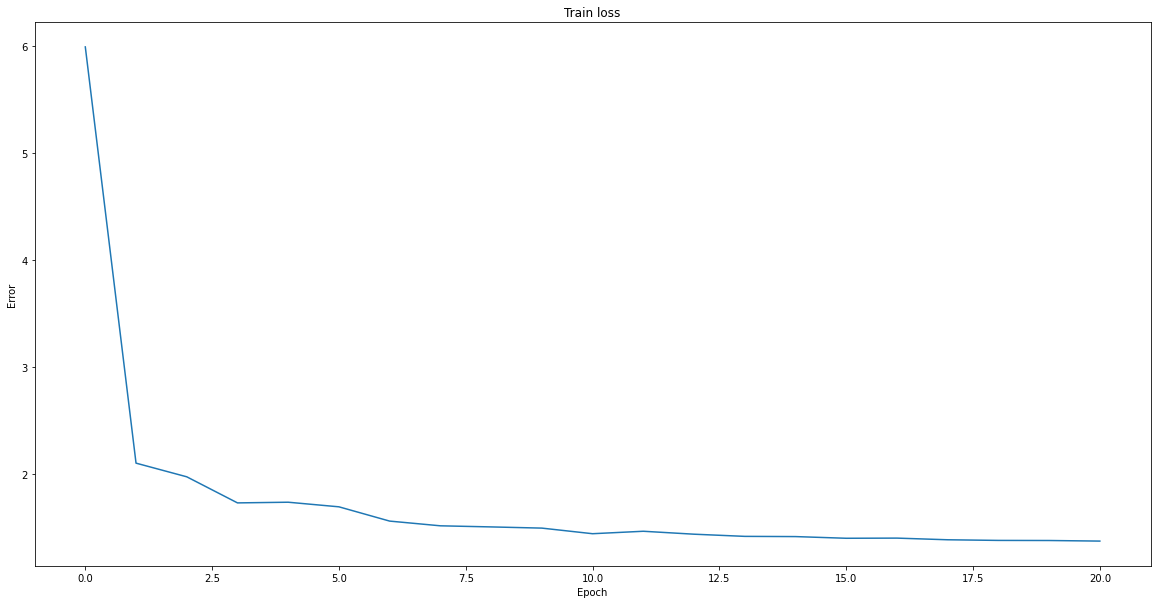

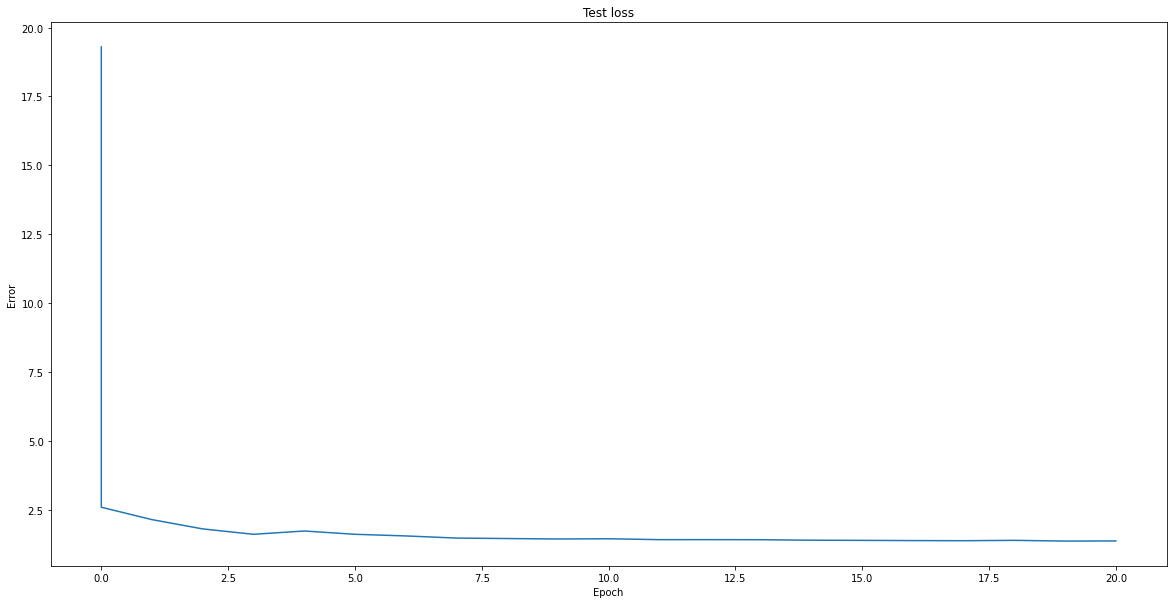

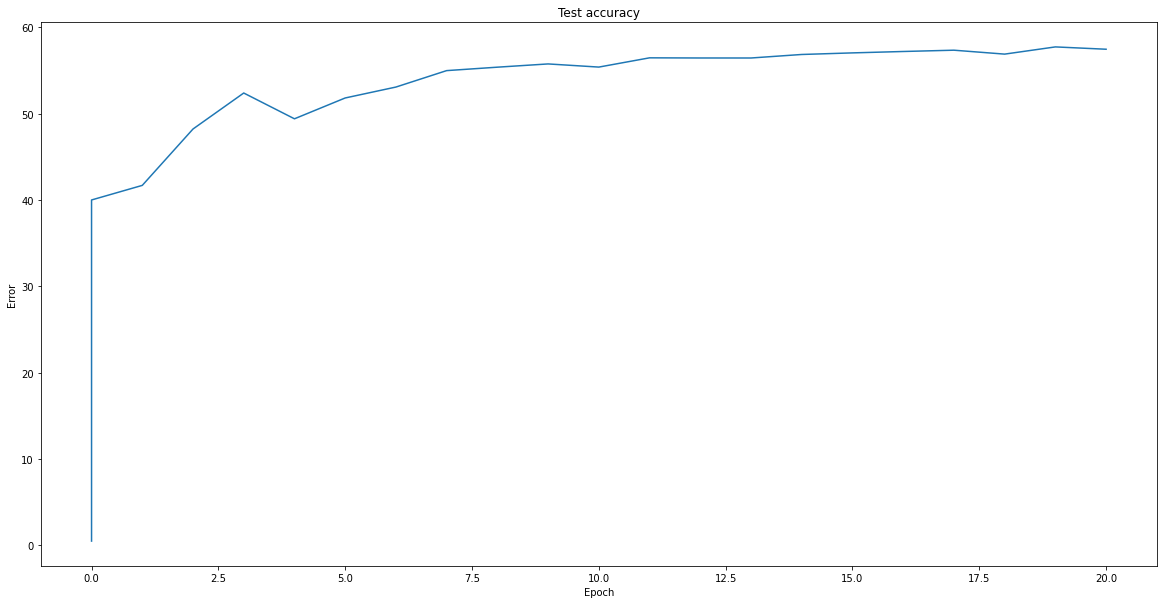

In [ ]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log_LOTR3.pkl'


    data_train = LOTRDataset(DATA_PATH + 'LOTR_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = LOTRDataset(DATA_PATH + 'LOTR_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_lord_of_the_rings2')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_lord_of_the_rings2/%03d.pt' % epoch)
            seed_words = 'Gandalf looked at Frodo.'
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_lord_of_the_rings2/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Frodo and Sam'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Frodo and Sam and the water they saw the things they had been the trees and the trees and the trees and the trees and the trees and the trees and the trees and the trees and the trees and the trees and the trees a
generated with sample	 Frodo and Sam in the hobbit-_said. And the time tales a tunnelt of his left for a hour of a hand. Mand it with the last for it was a had they had words. They had not be seen the winder. 'What it is go,' said Ganda
generated with sample	 Frodo and Sam. There was a stiff in the bowers of the North-ten. As that in a great and strength this water, and turning they had a blending his eyes and the side, and they had been blue an old name of first the t
generated with sample	 Frodo and Samuch a did not valling the battle and the old the think battle became the trees were to parts of the line and filled in the line days, and the wind in the strees of water that and faither fiulting and 
generated with sample	 Frodo and Sam. The said, to the 

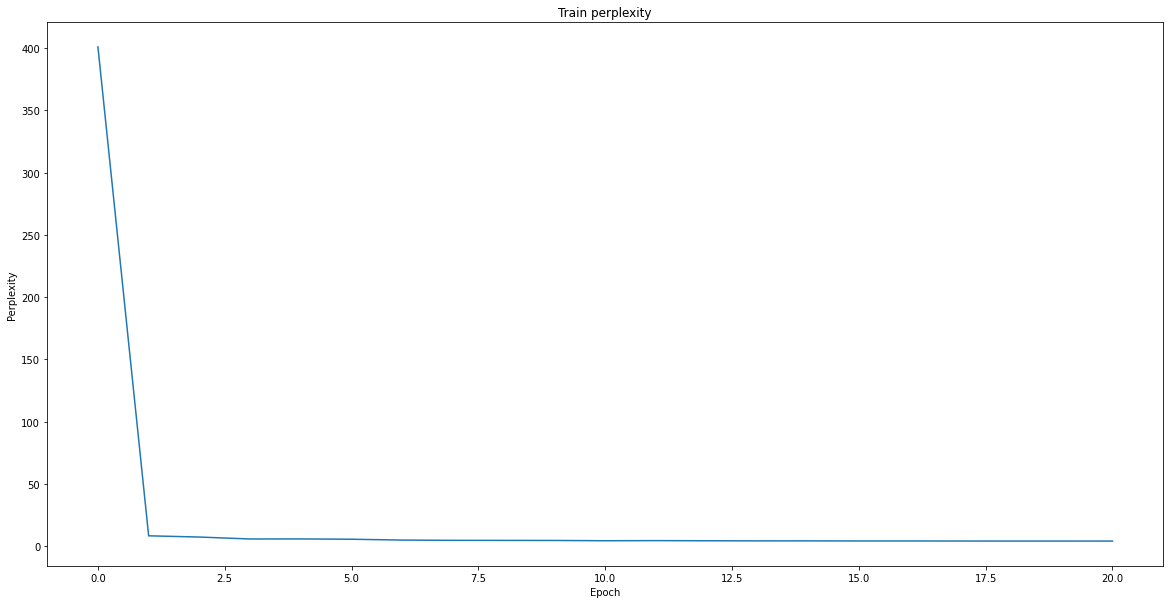

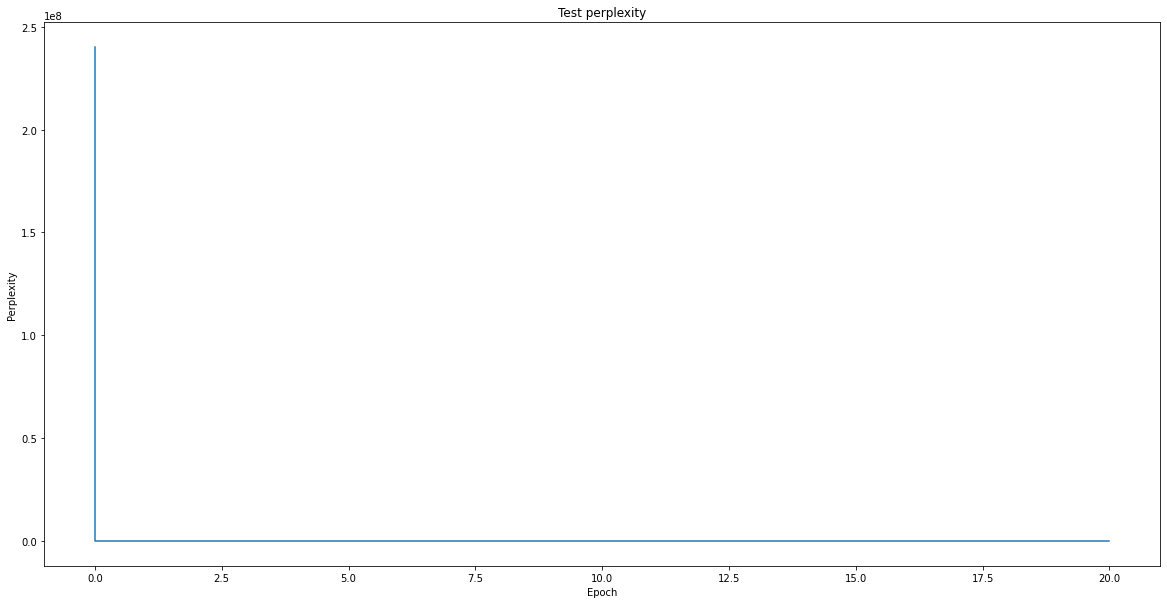

Train Perplexity:  3.953166715789003
Test Perplexity:  4.036804635051754


In [ ]:
LOG_PATH = DATA_PATH + 'logs/log_LOTR3.pkl'
train_loss, test_loss, test_accuracy = pt_util.read_log(LOG_PATH, ([], [], []))
epochs, plogn = zip(*train_loss)
train_perplexity = np.exp(plogn)
pt_util.plot(epochs, train_perplexity, 'Train perplexity', 'Epoch', 'Perplexity')
epochs, plogn = zip(*test_loss)
test_perplexity = np.exp(plogn)
pt_util.plot(epochs, test_perplexity, 'Test perplexity', 'Epoch', 'Perplexity')
print("Train Perplexity: ", train_perplexity[-1])
print("Test Perplexity: ",test_perplexity[-1])

#Part 8.2: Using an LSTM

In [52]:
TEMPERATURE = 0.7

class LSTMLOTRNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(LSTMLOTRNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, 2, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.lstm(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


Using device cuda
num workers: 2
Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	z??B???*:ssssss:2Gz::***sss:6/z/îzz"GGGGsszs7sseee*CCz:zzóBsssssszzszzznnssêNN?uÉÉ–OOeee***u:*7ss::B


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	::cGGîîîîî***::NNz*a::z((sssss::::::::22::::::5::::::::ÉzD(((******7::::*hs::::::ezee""ëzzz**Cîssszz



Test set: Average loss: 4.8187, Accuracy: 5022/512000 (1%)



  1%|▏         | 1/79 [00:00<00:33,  2.31it/s]

Train Epoch: 0 [0/20224 (0%)]	Loss: 4.817433


 14%|█▍        | 11/79 [00:03<00:23,  2.85it/s]

Train Epoch: 0 [2560/20224 (13%)]	Loss: 3.120345


 27%|██▋       | 21/79 [00:07<00:20,  2.85it/s]

Train Epoch: 0 [5120/20224 (25%)]	Loss: 2.431726


 39%|███▉      | 31/79 [00:10<00:16,  2.85it/s]

Train Epoch: 0 [7680/20224 (38%)]	Loss: 2.262084


 52%|█████▏    | 41/79 [00:14<00:13,  2.84it/s]

Train Epoch: 0 [10240/20224 (51%)]	Loss: 2.085639


 65%|██████▍   | 51/79 [00:17<00:09,  2.84it/s]

Train Epoch: 0 [12800/20224 (63%)]	Loss: 2.022631


 77%|███████▋  | 61/79 [00:21<00:06,  2.84it/s]

Train Epoch: 0 [15360/20224 (76%)]	Loss: 1.968962


 90%|████████▉ | 71/79 [00:24<00:02,  2.83it/s]

Train Epoch: 0 [17920/20224 (89%)]	Loss: 1.929241


100%|██████████| 79/79 [00:27<00:00,  2.85it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 her said thet te sas to ng   sa sadhtn  aand tot te st aoar   'Io   said tippin  a ot tos  'nd tner


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	tieth treat tole  aoare  tn te  err the wasl   'oe tn ttene  ttoenge l taned   'o totn  af ttaul  of



Test set: Average loss: 1.8534, Accuracy: 238123/512000 (47%)

Saved /content/lstm_lotr_checkpoints/000.pt

generated max		 Frodo and Sam the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was 
generated sample	 Frod

  1%|▏         | 1/79 [00:00<00:38,  2.01it/s]

Train Epoch: 1 [0/20224 (0%)]	Loss: 1.879090


 14%|█▍        | 11/79 [00:04<00:23,  2.83it/s]

Train Epoch: 1 [2560/20224 (13%)]	Loss: 1.821142


 27%|██▋       | 21/79 [00:07<00:20,  2.87it/s]

Train Epoch: 1 [5120/20224 (25%)]	Loss: 1.779732


 39%|███▉      | 31/79 [00:11<00:16,  2.86it/s]

Train Epoch: 1 [7680/20224 (38%)]	Loss: 1.783533


 52%|█████▏    | 41/79 [00:14<00:13,  2.84it/s]

Train Epoch: 1 [10240/20224 (51%)]	Loss: 1.704564


 65%|██████▍   | 51/79 [00:18<00:09,  2.86it/s]

Train Epoch: 1 [12800/20224 (63%)]	Loss: 1.709098


 77%|███████▋  | 61/79 [00:21<00:06,  2.86it/s]

Train Epoch: 1 [15360/20224 (76%)]	Loss: 1.705031


 90%|████████▉ | 71/79 [00:25<00:02,  2.82it/s]

Train Epoch: 1 [17920/20224 (89%)]	Loss: 1.704266


100%|██████████| 79/79 [00:27<00:00,  2.82it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  waid Ghet te was ao ng   se sadhtn  a nd aot ae wn aoer   'Io,  said Gippin  a ot aot  Tnd tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	teeth aoeat tore tooar d op te heen the wasl   'ot wn weemed ttoonger, atnent  To totne of toaut  of



Test set: Average loss: 1.6519, Accuracy: 262170/512000 (51%)

Saved /content/lstm_lotr_checkpoints/001.pt

generated max		 Frodo and Sam and the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the was the 
generated sample	 Frod

  1%|▏         | 1/79 [00:00<00:38,  2.01it/s]

Train Epoch: 2 [0/20224 (0%)]	Loss: 1.659634


 14%|█▍        | 11/79 [00:04<00:24,  2.82it/s]

Train Epoch: 2 [2560/20224 (13%)]	Loss: 1.626176


 27%|██▋       | 21/79 [00:07<00:20,  2.83it/s]

Train Epoch: 2 [5120/20224 (25%)]	Loss: 1.611201


 39%|███▉      | 31/79 [00:11<00:17,  2.82it/s]

Train Epoch: 2 [7680/20224 (38%)]	Loss: 1.634403


 52%|█████▏    | 41/79 [00:14<00:13,  2.84it/s]

Train Epoch: 2 [10240/20224 (51%)]	Loss: 1.625652


 65%|██████▍   | 51/79 [00:18<00:09,  2.85it/s]

Train Epoch: 2 [12800/20224 (63%)]	Loss: 1.580060


 77%|███████▋  | 61/79 [00:21<00:06,  2.85it/s]

Train Epoch: 2 [15360/20224 (76%)]	Loss: 1.593693


 90%|████████▉ | 71/79 [00:25<00:02,  2.82it/s]

Train Epoch: 2 [17920/20224 (89%)]	Loss: 1.603931


100%|██████████| 79/79 [00:28<00:00,  2.82it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  waid Ghet ha was aoing   se sanntd  a nd aot aarwn aoar   'Tot  said Gippin  a othaoa  Tnd tnen


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	taach areat trrs taoared ap aeeween the wasls  'ot an aaemed tooangery aanent  Tortotse tf taaul  of



Test set: Average loss: 1.5827, Accuracy: 265559/512000 (52%)

Saved /content/lstm_lotr_checkpoints/002.pt

generated max		 Frodo and Sam and the was a great the was a great the was a great the was a great the was a great the was a great the was a great the was a great the was a great the was a great the was a great the was a great the 
generated sample	 Frod

  1%|▏         | 1/79 [00:00<00:39,  1.96it/s]

Train Epoch: 3 [0/20224 (0%)]	Loss: 1.580191


 14%|█▍        | 11/79 [00:04<00:24,  2.81it/s]

Train Epoch: 3 [2560/20224 (13%)]	Loss: 1.554240


 27%|██▋       | 21/79 [00:07<00:20,  2.82it/s]

Train Epoch: 3 [5120/20224 (25%)]	Loss: 1.526044


 39%|███▉      | 31/79 [00:11<00:16,  2.83it/s]

Train Epoch: 3 [7680/20224 (38%)]	Loss: 1.543110


 52%|█████▏    | 41/79 [00:14<00:13,  2.83it/s]

Train Epoch: 3 [10240/20224 (51%)]	Loss: 1.502948


 65%|██████▍   | 51/79 [00:18<00:09,  2.81it/s]

Train Epoch: 3 [12800/20224 (63%)]	Loss: 1.546447


 77%|███████▋  | 61/79 [00:21<00:06,  2.83it/s]

Train Epoch: 3 [15360/20224 (76%)]	Loss: 1.519975


 90%|████████▉ | 71/79 [00:25<00:02,  2.81it/s]

Train Epoch: 3 [17920/20224 (89%)]	Loss: 1.531728


100%|██████████| 79/79 [00:28<00:00,  2.82it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  waid thet we was aoing   se sadntd  a nd tot aarwn aoar,  'Tot  said Gippin  a othiot  Ind tnen


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	tiich aoeat arrs taoared ap aehween the wasls  'ot in waemed ttoangery aanentl Towwotse tf aoaul  of



Test set: Average loss: 1.5118, Accuracy: 276589/512000 (54%)

Saved /content/lstm_lotr_checkpoints/003.pt

generated max		 Frodo and Sam and said the road and said the road and said the road and said the road and said the road and said the road and said the road and said the road and said the road and said the road and said the road an
generated sample	 Frod

  1%|▏         | 1/79 [00:00<00:38,  2.02it/s]

Train Epoch: 4 [0/20224 (0%)]	Loss: 1.504474


 14%|█▍        | 11/79 [00:04<00:24,  2.81it/s]

Train Epoch: 4 [2560/20224 (13%)]	Loss: 1.496387


 27%|██▋       | 21/79 [00:07<00:20,  2.81it/s]

Train Epoch: 4 [5120/20224 (25%)]	Loss: 1.481594


 39%|███▉      | 31/79 [00:11<00:16,  2.83it/s]

Train Epoch: 4 [7680/20224 (38%)]	Loss: 1.501657


 52%|█████▏    | 41/79 [00:14<00:13,  2.84it/s]

Train Epoch: 4 [10240/20224 (51%)]	Loss: 1.463441


 65%|██████▍   | 51/79 [00:18<00:09,  2.83it/s]

Train Epoch: 4 [12800/20224 (63%)]	Loss: 1.468461


 77%|███████▋  | 61/79 [00:21<00:06,  2.82it/s]

Train Epoch: 4 [15360/20224 (76%)]	Loss: 1.483908


 90%|████████▉ | 71/79 [00:25<00:02,  2.82it/s]

Train Epoch: 4 [17920/20224 (89%)]	Loss: 1.486479


100%|██████████| 79/79 [00:28<00:00,  2.81it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  waid.thet te was aowng   se sadntd  aand tot tarws toer,  'Tot  said Gippin. a ot tot 'Ind tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	tiech treyt tars tooased ap tefween the watls  Tot wt weemed ttoangery atnent  Towtotse tf toaul  of



Test set: Average loss: 1.4686, Accuracy: 284116/512000 (55%)

Saved /content/lstm_lotr_checkpoints/004.pt

generated max		 Frodo and Sam and the trees of the water of the water of the water of the water of the water of the water of the water of the water of the water of the water of the water of the water of the water of the water of t
generated sample	 Frod

  1%|▏         | 1/79 [00:00<00:38,  2.00it/s]

Train Epoch: 5 [0/20224 (0%)]	Loss: 1.458354


 14%|█▍        | 11/79 [00:04<00:24,  2.82it/s]

Train Epoch: 5 [2560/20224 (13%)]	Loss: 1.447303


 27%|██▋       | 21/79 [00:07<00:20,  2.82it/s]

Train Epoch: 5 [5120/20224 (25%)]	Loss: 1.450966


 39%|███▉      | 31/79 [00:11<00:17,  2.82it/s]

Train Epoch: 5 [7680/20224 (38%)]	Loss: 1.480541


 52%|█████▏    | 41/79 [00:14<00:13,  2.84it/s]

Train Epoch: 5 [10240/20224 (51%)]	Loss: 1.422649


 65%|██████▍   | 51/79 [00:18<00:09,  2.84it/s]

Train Epoch: 5 [12800/20224 (63%)]	Loss: 1.434242


 77%|███████▋  | 61/79 [00:21<00:06,  2.83it/s]

Train Epoch: 5 [15360/20224 (76%)]	Loss: 1.452271


 90%|████████▉ | 71/79 [00:25<00:02,  2.84it/s]

Train Epoch: 5 [17920/20224 (89%)]	Loss: 1.489700


100%|██████████| 79/79 [00:28<00:00,  2.81it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  waid,toat ta was aowng   se sadned  aand tot aarws aoer,  'Tot  said Fippin. aaot aot 'Ind tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	tiach treyt aars taoarid an aefteen toe watls  Tot in weemed tooange y aalentl Tottotse tf tooul ,af



Test set: Average loss: 1.4603, Accuracy: 283442/512000 (55%)

generated max		 Frodo and Sam and the road and the road and the road and the road and the road and the road and the road and the road and the road and the road and the road and the road and the road and the road and the road and t
generated sample	 Frodo and Sam and to un to the Mourn. Tooker the 

  1%|▏         | 1/79 [00:00<00:38,  2.04it/s]

Train Epoch: 6 [0/20224 (0%)]	Loss: 1.448126


 14%|█▍        | 11/79 [00:04<00:24,  2.82it/s]

Train Epoch: 6 [2560/20224 (13%)]	Loss: 1.412632


 27%|██▋       | 21/79 [00:07<00:20,  2.84it/s]

Train Epoch: 6 [5120/20224 (25%)]	Loss: 1.422405


 39%|███▉      | 31/79 [00:11<00:16,  2.85it/s]

Train Epoch: 6 [7680/20224 (38%)]	Loss: 1.486700


 52%|█████▏    | 41/79 [00:14<00:13,  2.84it/s]

Train Epoch: 6 [10240/20224 (51%)]	Loss: 1.411246


 65%|██████▍   | 51/79 [00:18<00:09,  2.81it/s]

Train Epoch: 6 [12800/20224 (63%)]	Loss: 1.425661


 77%|███████▋  | 61/79 [00:21<00:06,  2.81it/s]

Train Epoch: 6 [15360/20224 (76%)]	Loss: 1.418288


 90%|████████▉ | 71/79 [00:25<00:02,  2.81it/s]

Train Epoch: 6 [17920/20224 (89%)]	Loss: 1.451353


100%|██████████| 79/79 [00:28<00:00,  2.81it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  waid thet te was aoing   se sadned  aand tot te ws aoerl  'Tot  said Fippin. aaot tot 'Ind tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	tiech treyt aare taoavid ap tyfteen the layl   Tot it weemed ttoange y atlentl To totse tf toaul  of



Test set: Average loss: 1.4268, Accuracy: 289215/512000 (56%)

Saved /content/lstm_lotr_checkpoints/006.pt

generated max		 Frodo and Sam and the land of the Ring of the Ring of the Ring of the Ring of the Ring of the Ring of the Ring of the Ring of the Ring of the Ring of the Ring of the Ring of the Ring of the Ring of the Ring of the 
generated sample	 Frod

  1%|▏         | 1/79 [00:00<00:39,  1.97it/s]

Train Epoch: 7 [0/20224 (0%)]	Loss: 1.413652


 14%|█▍        | 11/79 [00:04<00:24,  2.79it/s]

Train Epoch: 7 [2560/20224 (13%)]	Loss: 1.394075


 27%|██▋       | 21/79 [00:07<00:20,  2.82it/s]

Train Epoch: 7 [5120/20224 (25%)]	Loss: 1.396017


 39%|███▉      | 31/79 [00:11<00:16,  2.84it/s]

Train Epoch: 7 [7680/20224 (38%)]	Loss: 1.503761


 52%|█████▏    | 41/79 [00:14<00:13,  2.80it/s]

Train Epoch: 7 [10240/20224 (51%)]	Loss: 1.412807


 65%|██████▍   | 51/79 [00:18<00:09,  2.82it/s]

Train Epoch: 7 [12800/20224 (63%)]	Loss: 1.399900


 77%|███████▋  | 61/79 [00:21<00:06,  2.85it/s]

Train Epoch: 7 [15360/20224 (76%)]	Loss: 1.406398


 90%|████████▉ | 71/79 [00:25<00:02,  2.84it/s]

Train Epoch: 7 [17920/20224 (89%)]	Loss: 1.420755


100%|██████████| 79/79 [00:28<00:00,  2.81it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  wawd thet te was aoing   se sadhed  aand tot te ws toer   'Tot  said Fippin  'aot tot  Tnd tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	tiech treyt tare toeartd tp tefteen the watl   Tot it weemed ttoange y ttlent  Tottotse tf ttaul  of



Test set: Average loss: 1.4280, Accuracy: 290424/512000 (57%)

Saved /content/lstm_lotr_checkpoints/007.pt

generated max		 Frodo and Sam to the land of the River that the water of the Ring of the Ring of the Ring of the Ring of the Ring of the Ring of the Ring of the Ring of the Ring of the Ring of the Ring of the Ring of the Ring of t
generated sample	 Frod

  1%|▏         | 1/79 [00:00<00:38,  2.02it/s]

Train Epoch: 8 [0/20224 (0%)]	Loss: 1.412156


 14%|█▍        | 11/79 [00:04<00:24,  2.81it/s]

Train Epoch: 8 [2560/20224 (13%)]	Loss: 1.379402


 27%|██▋       | 21/79 [00:07<00:20,  2.85it/s]

Train Epoch: 8 [5120/20224 (25%)]	Loss: 1.395442


 39%|███▉      | 31/79 [00:11<00:16,  2.83it/s]

Train Epoch: 8 [7680/20224 (38%)]	Loss: 1.436579


 52%|█████▏    | 41/79 [00:14<00:13,  2.83it/s]

Train Epoch: 8 [10240/20224 (51%)]	Loss: 1.374620


 65%|██████▍   | 51/79 [00:18<00:09,  2.82it/s]

Train Epoch: 8 [12800/20224 (63%)]	Loss: 1.380825


 77%|███████▋  | 61/79 [00:21<00:06,  2.83it/s]

Train Epoch: 8 [15360/20224 (76%)]	Loss: 1.396857


 90%|████████▉ | 71/79 [00:25<00:02,  2.83it/s]

Train Epoch: 8 [17920/20224 (89%)]	Loss: 1.414296


100%|██████████| 79/79 [00:28<00:00,  2.81it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  wawd.thet te was toing   se sadhed. aand tot te ws toerl  'Tot  said Fippin. 'aot tot  Tnd tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	tiech treyt tare toiared tp tefteen the tatl   Tot tt weemed tooange y ttlentl To totse tf ttaul  of



Test set: Average loss: 1.4099, Accuracy: 292017/512000 (57%)

Saved /content/lstm_lotr_checkpoints/008.pt

generated max		 Frodo and Sam to the trees. The trees of the Ring of the Ring of the Ring of the Ring. The trees of the Ring of the Ring of the Ring of the Ring. The trees of the Ring of the Ring of the Ring of the Ring. The trees
generated sample	 Frod

  1%|▏         | 1/79 [00:00<00:38,  2.03it/s]

Train Epoch: 9 [0/20224 (0%)]	Loss: 1.394024


 14%|█▍        | 11/79 [00:04<00:24,  2.83it/s]

Train Epoch: 9 [2560/20224 (13%)]	Loss: 1.370200


 27%|██▋       | 21/79 [00:07<00:20,  2.82it/s]

Train Epoch: 9 [5120/20224 (25%)]	Loss: 1.412048


 39%|███▉      | 31/79 [00:11<00:17,  2.81it/s]

Train Epoch: 9 [7680/20224 (38%)]	Loss: 1.414128


 52%|█████▏    | 41/79 [00:14<00:13,  2.82it/s]

Train Epoch: 9 [10240/20224 (51%)]	Loss: 1.358157


 65%|██████▍   | 51/79 [00:18<00:09,  2.85it/s]

Train Epoch: 9 [12800/20224 (63%)]	Loss: 1.376630


 77%|███████▋  | 61/79 [00:21<00:06,  2.81it/s]

Train Epoch: 9 [15360/20224 (76%)]	Loss: 1.375079


 90%|████████▉ | 71/79 [00:25<00:02,  2.80it/s]

Train Epoch: 9 [17920/20224 (89%)]	Loss: 1.405613


100%|██████████| 79/79 [00:28<00:00,  2.81it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  wawd toet te was aowng   se sadhed  aand tot te ws noerl  'Tot  said Fippin. 'aot tot  Ind tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	thech toeyt tare  ooared tp tafteen the satl   Tot it weemed tooange y tolent  Towtotse tf toaul  of



Test set: Average loss: 1.4005, Accuracy: 292371/512000 (57%)

Saved /content/lstm_lotr_checkpoints/009.pt

generated max		 Frodo and Sam took the trees of the south of the Road was the stood that the wall of the south of the Road was the stood that the wall of the south of the Road was the stood that the wall of the south of the Road w
generated sample	 Frod

  1%|▏         | 1/79 [00:00<00:38,  2.03it/s]

Train Epoch: 10 [0/20224 (0%)]	Loss: 1.382563


 14%|█▍        | 11/79 [00:04<00:24,  2.79it/s]

Train Epoch: 10 [2560/20224 (13%)]	Loss: 1.373654


 27%|██▋       | 21/79 [00:07<00:20,  2.82it/s]

Train Epoch: 10 [5120/20224 (25%)]	Loss: 1.385185


 39%|███▉      | 31/79 [00:11<00:17,  2.82it/s]

Train Epoch: 10 [7680/20224 (38%)]	Loss: 1.399561


 52%|█████▏    | 41/79 [00:14<00:13,  2.84it/s]

Train Epoch: 10 [10240/20224 (51%)]	Loss: 1.346642


 65%|██████▍   | 51/79 [00:18<00:09,  2.81it/s]

Train Epoch: 10 [12800/20224 (63%)]	Loss: 1.387292


 77%|███████▋  | 61/79 [00:21<00:06,  2.79it/s]

Train Epoch: 10 [15360/20224 (76%)]	Loss: 1.373468


 90%|████████▉ | 71/79 [00:25<00:02,  2.79it/s]

Train Epoch: 10 [17920/20224 (89%)]	Loss: 1.389901


100%|██████████| 79/79 [00:28<00:00,  2.80it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  wawd.thet te was aoing   se sadhed. aand tot te ss noarl  'Iot  said Fippin. 'Iot tot  Ind tven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	teech treyt tare toearid tp tefteen the satl   Tot wt weemed toaangery ttnent  Towtotse tf tuaul  of



Test set: Average loss: 1.3811, Accuracy: 295328/512000 (58%)

Saved /content/lstm_lotr_checkpoints/010.pt

generated max		 Frodo and Sam to the sun of the sun that the water of the sun was stood the stone of the sunlight of the sun that the water of the sun was stood the stone of the sunlight of the sun that the water of the sun was st
generated sample	 Frod

  1%|▏         | 1/79 [00:00<00:37,  2.07it/s]

Train Epoch: 11 [0/20224 (0%)]	Loss: 1.363563


 14%|█▍        | 11/79 [00:04<00:24,  2.79it/s]

Train Epoch: 11 [2560/20224 (13%)]	Loss: 1.359232


 27%|██▋       | 21/79 [00:07<00:20,  2.80it/s]

Train Epoch: 11 [5120/20224 (25%)]	Loss: 1.372379


 39%|███▉      | 31/79 [00:11<00:17,  2.81it/s]

Train Epoch: 11 [7680/20224 (38%)]	Loss: 1.391074


 52%|█████▏    | 41/79 [00:14<00:13,  2.78it/s]

Train Epoch: 11 [10240/20224 (51%)]	Loss: 1.344897


 65%|██████▍   | 51/79 [00:18<00:10,  2.79it/s]

Train Epoch: 11 [12800/20224 (63%)]	Loss: 1.355768


 77%|███████▋  | 61/79 [00:21<00:06,  2.82it/s]

Train Epoch: 11 [15360/20224 (76%)]	Loss: 1.361274


 90%|████████▉ | 71/79 [00:25<00:02,  2.80it/s]

Train Epoch: 11 [17920/20224 (89%)]	Loss: 1.374595


100%|██████████| 79/79 [00:28<00:00,  2.80it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  wawd thet te was aoing   se sadhed  aand tot te ws aoer   'Iot  said Gippin. 'aot tot  Ind Iver


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	teech treyt tare  oeared tp tefteen the satl   Tet it weemed torange y ttlent  Towtotse tf toaul  tf



Test set: Average loss: 1.3932, Accuracy: 294563/512000 (58%)

generated max		 Frodo and Sam to the south of the Shire that they were the tree of the Elves of the Elves and the tree the road the road the road the road the road the road the road the road the road the road the road the road the
generated sample	 Frodo and Sam up the war of the foot but the echo

  1%|▏         | 1/79 [00:00<00:38,  2.03it/s]

Train Epoch: 12 [0/20224 (0%)]	Loss: 1.377735


 14%|█▍        | 11/79 [00:04<00:24,  2.79it/s]

Train Epoch: 12 [2560/20224 (13%)]	Loss: 1.376948


 27%|██▋       | 21/79 [00:07<00:20,  2.81it/s]

Train Epoch: 12 [5120/20224 (25%)]	Loss: 1.358926


 39%|███▉      | 31/79 [00:11<00:17,  2.82it/s]

Train Epoch: 12 [7680/20224 (38%)]	Loss: 1.364828


 52%|█████▏    | 41/79 [00:14<00:13,  2.81it/s]

Train Epoch: 12 [10240/20224 (51%)]	Loss: 1.326252


 65%|██████▍   | 51/79 [00:18<00:10,  2.78it/s]

Train Epoch: 12 [12800/20224 (63%)]	Loss: 1.374552


 77%|███████▋  | 61/79 [00:21<00:06,  2.76it/s]

Train Epoch: 12 [15360/20224 (76%)]	Loss: 1.367820


 90%|████████▉ | 71/79 [00:25<00:02,  2.79it/s]

Train Epoch: 12 [17920/20224 (89%)]	Loss: 1.371664


100%|██████████| 79/79 [00:28<00:00,  2.78it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  wawd thet te was aoing   se sadhed  aand tot te ws aoer.  'Iot  said Gippin. 'bot tot  Ind Iver


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	teech treyt tare  oeared tp tehween the woll   Tot it weemed toraigery tolent  Towtotse tf toaul  of



Test set: Average loss: 1.3788, Accuracy: 295410/512000 (58%)

Saved /content/lstm_lotr_checkpoints/012.pt

generated max		 Frodo and Sam to the water of the Shire that was a strange of the woods of the Shire they were all the woods of the Shire they were all the woods of the Shire they were all the woods of the Shire they were all the 
generated sample	 Frod

  1%|▏         | 1/79 [00:00<00:40,  1.93it/s]

Train Epoch: 13 [0/20224 (0%)]	Loss: 1.363786


 14%|█▍        | 11/79 [00:04<00:24,  2.75it/s]

Train Epoch: 13 [2560/20224 (13%)]	Loss: 1.341981


 27%|██▋       | 21/79 [00:07<00:20,  2.80it/s]

Train Epoch: 13 [5120/20224 (25%)]	Loss: 1.366230


 39%|███▉      | 31/79 [00:11<00:17,  2.78it/s]

Train Epoch: 13 [7680/20224 (38%)]	Loss: 1.363256


 52%|█████▏    | 41/79 [00:14<00:13,  2.78it/s]

Train Epoch: 13 [10240/20224 (51%)]	Loss: 1.330752


 65%|██████▍   | 51/79 [00:18<00:10,  2.78it/s]

Train Epoch: 13 [12800/20224 (63%)]	Loss: 1.349698


 77%|███████▋  | 61/79 [00:22<00:06,  2.77it/s]

Train Epoch: 13 [15360/20224 (76%)]	Loss: 1.375663


 90%|████████▉ | 71/79 [00:25<00:02,  2.76it/s]

Train Epoch: 13 [17920/20224 (89%)]	Loss: 1.372466


100%|██████████| 79/79 [00:28<00:00,  2.76it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  wtwd thet te was aoing   se sadhed. aand tot te ws noar.  'Tot  said Fippin. 'bot tot  Ind Iven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	tiith treyt sare  oeared tp tehteen the sotl   Tot it weemed torangery ttnent  To totse tf ttaut  of



Test set: Average loss: 1.3624, Accuracy: 298136/512000 (58%)

Saved /content/lstm_lotr_checkpoints/013.pt

generated max		 Frodo and Sam stood and stood and stood and stood and stood and stood and stood and stood and stood and stood and stood and stood and stood and stood and stood and stood and stood and stood and stood and stood and 
generated sample	 Frod

  1%|▏         | 1/79 [00:00<00:37,  2.07it/s]

Train Epoch: 14 [0/20224 (0%)]	Loss: 1.345639


 14%|█▍        | 11/79 [00:04<00:24,  2.76it/s]

Train Epoch: 14 [2560/20224 (13%)]	Loss: 1.330946


 27%|██▋       | 21/79 [00:07<00:20,  2.78it/s]

Train Epoch: 14 [5120/20224 (25%)]	Loss: 1.367892


 39%|███▉      | 31/79 [00:11<00:17,  2.76it/s]

Train Epoch: 14 [7680/20224 (38%)]	Loss: 1.373627


 52%|█████▏    | 41/79 [00:14<00:13,  2.78it/s]

Train Epoch: 14 [10240/20224 (51%)]	Loss: 1.314767


 65%|██████▍   | 51/79 [00:18<00:10,  2.77it/s]

Train Epoch: 14 [12800/20224 (63%)]	Loss: 1.327986


 77%|███████▋  | 61/79 [00:22<00:06,  2.78it/s]

Train Epoch: 14 [15360/20224 (76%)]	Loss: 1.424409


 90%|████████▉ | 71/79 [00:25<00:02,  2.78it/s]

Train Epoch: 14 [17920/20224 (89%)]	Loss: 1.388277


100%|██████████| 79/79 [00:28<00:00,  2.77it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  wawd.that te was aoing   se sadhed. aand tot ae ws aoar.  'Iot  said Gippin. 'bot tot  'nd Iven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	tiich treyt sare  oeaped ap tehween the sotls  Tot wn weemed torange y atnenc  Tottotse tf ttaule af



Test set: Average loss: 1.3619, Accuracy: 298989/512000 (58%)

Saved /content/lstm_lotr_checkpoints/014.pt

generated max		 Frodo and Sam stranged and stranged and stranged and stranged and stranged and stranged and stranged and stranged and stranged and stranged and stranged and stranged and stranged and stranged and stranged and stran
generated sample	 Frod

  1%|▏         | 1/79 [00:00<00:40,  1.95it/s]

Train Epoch: 15 [0/20224 (0%)]	Loss: 1.345644


 14%|█▍        | 11/79 [00:04<00:24,  2.77it/s]

Train Epoch: 15 [2560/20224 (13%)]	Loss: 1.321979


 27%|██▋       | 21/79 [00:07<00:20,  2.80it/s]

Train Epoch: 15 [5120/20224 (25%)]	Loss: 1.333679


 39%|███▉      | 31/79 [00:11<00:17,  2.78it/s]

Train Epoch: 15 [7680/20224 (38%)]	Loss: 1.360659


 52%|█████▏    | 41/79 [00:14<00:13,  2.77it/s]

Train Epoch: 15 [10240/20224 (51%)]	Loss: 1.342205


 65%|██████▍   | 51/79 [00:18<00:10,  2.77it/s]

Train Epoch: 15 [12800/20224 (63%)]	Loss: 1.337862


 77%|███████▋  | 61/79 [00:22<00:06,  2.75it/s]

Train Epoch: 15 [15360/20224 (76%)]	Loss: 1.347061


 90%|████████▉ | 71/79 [00:25<00:02,  2.75it/s]

Train Epoch: 15 [17920/20224 (89%)]	Loss: 1.352780


100%|██████████| 79/79 [00:28<00:00,  2.77it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  wawd thet te was aoing   se sadhed. aand to  he ws aoar.  'Iot  said Fippin. 'aot tot  Ind Iven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	teech treyt saee  oeared tp tehween the rall   Tet tt weemed toiangery ttnent  To tetse tf ttaute of



Test set: Average loss: 1.3505, Accuracy: 300049/512000 (59%)

Saved /content/lstm_lotr_checkpoints/015.pt

generated max		 Frodo and Sam to the roots of the horse of the wall of the horse of the wall of the horse of the horse of the horse of the horse of the horse of the horse of the horse of the horse of the horse of the horse of the 
generated sample	 Frod

  1%|▏         | 1/79 [00:00<00:39,  2.00it/s]

Train Epoch: 16 [0/20224 (0%)]	Loss: 1.336546


 14%|█▍        | 11/79 [00:04<00:24,  2.74it/s]

Train Epoch: 16 [2560/20224 (13%)]	Loss: 1.332598


 27%|██▋       | 21/79 [00:07<00:20,  2.82it/s]

Train Epoch: 16 [5120/20224 (25%)]	Loss: 1.384011


 39%|███▉      | 31/79 [00:11<00:17,  2.78it/s]

Train Epoch: 16 [7680/20224 (38%)]	Loss: 1.362793


 52%|█████▏    | 41/79 [00:14<00:13,  2.80it/s]

Train Epoch: 16 [10240/20224 (51%)]	Loss: 1.309437


 65%|██████▍   | 51/79 [00:18<00:10,  2.77it/s]

Train Epoch: 16 [12800/20224 (63%)]	Loss: 1.324901


 77%|███████▋  | 61/79 [00:22<00:06,  2.78it/s]

Train Epoch: 16 [15360/20224 (76%)]	Loss: 1.357633


 90%|████████▉ | 71/79 [00:25<00:02,  2.80it/s]

Train Epoch: 16 [17920/20224 (89%)]	Loss: 1.348777


100%|██████████| 79/79 [00:28<00:00,  2.77it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  weid thet te was aoing   se sanhed. aand tot te ws aoar.  'Iot  said Gippin. 'aot tot  Ind Iven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	tiech treyt saee  seared tp tehween the satl   Tet tt weemed toiaigely ttnent  To totse tf toaute tf



Test set: Average loss: 1.3470, Accuracy: 300545/512000 (59%)

Saved /content/lstm_lotr_checkpoints/016.pt

generated max		 Frodo and Sam to the hills of the hills and the wind of the hills of the hills and the wind of the hills of the hills and the wind of the hills of the hills and the wind of the hills of the hills and the wind of th
generated sample	 Frod

  1%|▏         | 1/79 [00:00<00:38,  2.05it/s]

Train Epoch: 17 [0/20224 (0%)]	Loss: 1.330964


 14%|█▍        | 11/79 [00:04<00:24,  2.79it/s]

Train Epoch: 17 [2560/20224 (13%)]	Loss: 1.322640


 27%|██▋       | 21/79 [00:07<00:20,  2.80it/s]

Train Epoch: 17 [5120/20224 (25%)]	Loss: 1.332411


 39%|███▉      | 31/79 [00:11<00:17,  2.79it/s]

Train Epoch: 17 [7680/20224 (38%)]	Loss: 1.354657


 52%|█████▏    | 41/79 [00:14<00:13,  2.78it/s]

Train Epoch: 17 [10240/20224 (51%)]	Loss: 1.311380


 65%|██████▍   | 51/79 [00:18<00:09,  2.80it/s]

Train Epoch: 17 [12800/20224 (63%)]	Loss: 1.334467


 77%|███████▋  | 61/79 [00:21<00:06,  2.78it/s]

Train Epoch: 17 [15360/20224 (76%)]	Loss: 1.342947


 90%|████████▉ | 71/79 [00:25<00:02,  2.78it/s]

Train Epoch: 17 [17920/20224 (89%)]	Loss: 1.335314


100%|██████████| 79/79 [00:28<00:00,  2.78it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	 he  weid thet te was aeing   se sanhed. aand ho  ae ws aear.  'Io,  said Gippin. 'aot tot  Ind Iven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	thech treyt sare  weared ap aehween the sitl   Tet tt weemed torange y atnent  To tewse tf ttarl  af



Test set: Average loss: 1.3408, Accuracy: 301338/512000 (59%)

Saved /content/lstm_lotr_checkpoints/017.pt

generated max		 Frodo and Sam was a great companions of the wind of the wind of the wind of the wind of the wind of the wind of the wind of the wind of the wind of the wind of the wind of the wind of the wind of the wind of the wi
generated sample	 Frod

  1%|▏         | 1/79 [00:00<00:38,  2.05it/s]

Train Epoch: 18 [0/20224 (0%)]	Loss: 1.323611


 14%|█▍        | 11/79 [00:04<00:24,  2.77it/s]

Train Epoch: 18 [2560/20224 (13%)]	Loss: 1.328734


 27%|██▋       | 21/79 [00:07<00:20,  2.81it/s]

Train Epoch: 18 [5120/20224 (25%)]	Loss: 1.321379


 39%|███▉      | 31/79 [00:11<00:17,  2.79it/s]

Train Epoch: 18 [7680/20224 (38%)]	Loss: 1.343856


 52%|█████▏    | 41/79 [00:14<00:13,  2.79it/s]

Train Epoch: 18 [10240/20224 (51%)]	Loss: 1.312375


 65%|██████▍   | 51/79 [00:18<00:10,  2.75it/s]

Train Epoch: 18 [12800/20224 (63%)]	Loss: 1.313646


 77%|███████▋  | 61/79 [00:21<00:06,  2.78it/s]

Train Epoch: 18 [15360/20224 (76%)]	Loss: 1.389487


 90%|████████▉ | 71/79 [00:25<00:02,  2.77it/s]

Train Epoch: 18 [17920/20224 (89%)]	Loss: 1.366673


100%|██████████| 79/79 [00:28<00:00,  2.78it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	  e  waid thet te was aowng   se sanhtd. 'and tot te ss toarl  'Iot  said Gippin. 'aot tot  'nd Iven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	tiich treyt sare  ooaptd tp tehteen the wotls  Tot tt weemed toiaigely atnent  Tottotse tf ttoute af



Test set: Average loss: 1.3470, Accuracy: 300318/512000 (59%)

generated max		 Frodo and Sam to the trees of the woods of the woods of the woods of the woods of the woods of the woods of the woods of the woods of the woods of the woods of the woods of the woods of the woods of the woods of th
generated sample	 Frodo and Sam sprang sunlight and looked at the c

  1%|▏         | 1/79 [00:00<00:37,  2.10it/s]

Train Epoch: 19 [0/20224 (0%)]	Loss: 1.330907


 14%|█▍        | 11/79 [00:04<00:24,  2.76it/s]

Train Epoch: 19 [2560/20224 (13%)]	Loss: 1.311609


 27%|██▋       | 21/79 [00:07<00:20,  2.78it/s]

Train Epoch: 19 [5120/20224 (25%)]	Loss: 1.318835


 39%|███▉      | 31/79 [00:11<00:17,  2.80it/s]

Train Epoch: 19 [7680/20224 (38%)]	Loss: 1.341968


 52%|█████▏    | 41/79 [00:14<00:13,  2.79it/s]

Train Epoch: 19 [10240/20224 (51%)]	Loss: 1.308515


 65%|██████▍   | 51/79 [00:18<00:10,  2.77it/s]

Train Epoch: 19 [12800/20224 (63%)]	Loss: 1.315238


 77%|███████▋  | 61/79 [00:22<00:06,  2.80it/s]

Train Epoch: 19 [15360/20224 (76%)]	Loss: 1.349484


 90%|████████▉ | 71/79 [00:25<00:02,  2.79it/s]

Train Epoch: 19 [17920/20224 (89%)]	Loss: 1.348166


100%|██████████| 79/79 [00:28<00:00,  2.78it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	  e  waid thet te was aewng   se sanhed. 'and tot te ws aoar   'Iot  said Gippin. 'aot tot  Ind Iven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	thich treyt sare  seartd tp tehteen the sitls  Tot tt weemed toaangely atnent  Tottetse tf ttaut  tf



Test set: Average loss: 1.3395, Accuracy: 301646/512000 (59%)

Saved /content/lstm_lotr_checkpoints/019.pt

generated max		 Frodo and Sam the hobbits were stranged and stone and the wind of the hills of the hills of the hills of the hills of the hills of the hills of the hills of the hills of the hills of the hills of the hills of the h
generated sample	 Frod

  1%|▏         | 1/79 [00:00<00:38,  2.01it/s]

Train Epoch: 20 [0/20224 (0%)]	Loss: 1.323609


 14%|█▍        | 11/79 [00:04<00:24,  2.77it/s]

Train Epoch: 20 [2560/20224 (13%)]	Loss: 1.302849


 27%|██▋       | 21/79 [00:07<00:20,  2.80it/s]

Train Epoch: 20 [5120/20224 (25%)]	Loss: 1.314266


 39%|███▉      | 31/79 [00:11<00:17,  2.78it/s]

Train Epoch: 20 [7680/20224 (38%)]	Loss: 1.372813


 52%|█████▏    | 41/79 [00:14<00:13,  2.77it/s]

Train Epoch: 20 [10240/20224 (51%)]	Loss: 1.317573


 65%|██████▍   | 51/79 [00:18<00:10,  2.77it/s]

Train Epoch: 20 [12800/20224 (63%)]	Loss: 1.315919


 77%|███████▋  | 61/79 [00:22<00:06,  2.79it/s]

Train Epoch: 20 [15360/20224 (76%)]	Loss: 1.333215


 90%|████████▉ | 71/79 [00:25<00:02,  2.77it/s]

Train Epoch: 20 [17920/20224 (89%)]	Loss: 1.335536


100%|██████████| 79/79 [00:28<00:00,  2.77it/s]


Input	'They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And eve
GT	They said that he was dying,' he sighed, 'and now he is dead.' 'No,' said Pippin, 'not yet. And even
pred	  e  waid thet te was aowng   se sanhed. aand tot te ws aoarl  'Iot  said Gippin. 'aot tot  Ind Iven


Input	 which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts o
GT	which great fires leaped up between the walls. Yet it seemed strangely silent. No noise or shouts of
pred	tiech treyt sare  weaped ap aehteen the sitl   Tet tt weemed toiangely atnent  Towtotse tf toaute af



Test set: Average loss: 1.3282, Accuracy: 303404/512000 (59%)

Saved /content/lstm_lotr_checkpoints/020.pt

generated max		 Frodo and Sam was a stone of the wind of the wind of the wind of the wind was still and the wind was still and the wind was still and the wind was still and the wind was still and the wind was still and the wind wa
generated sample	 Frod

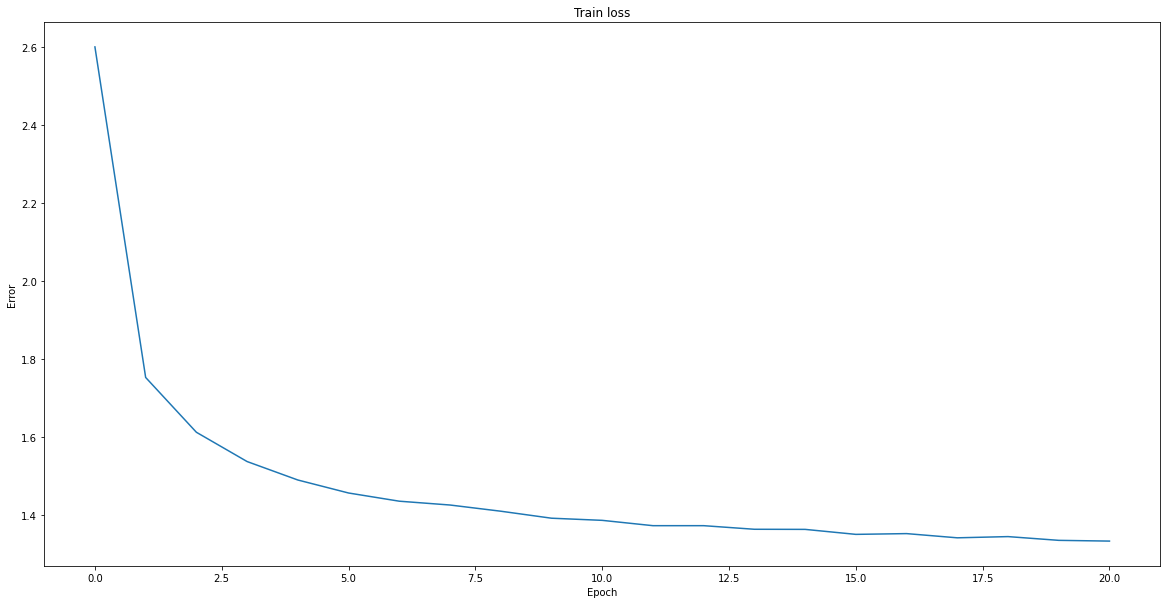

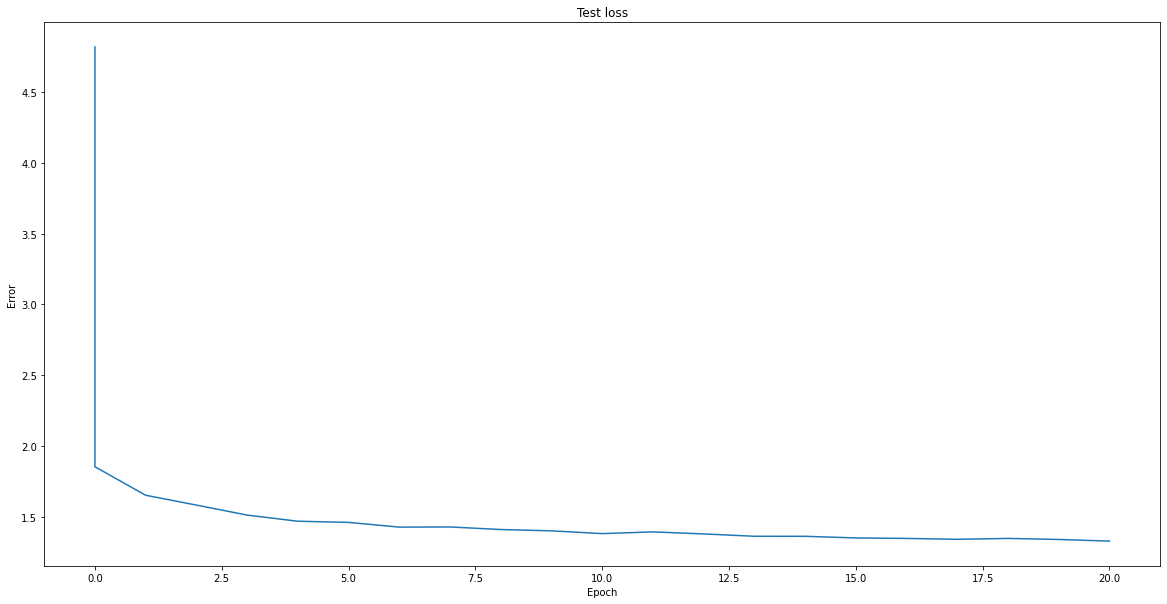

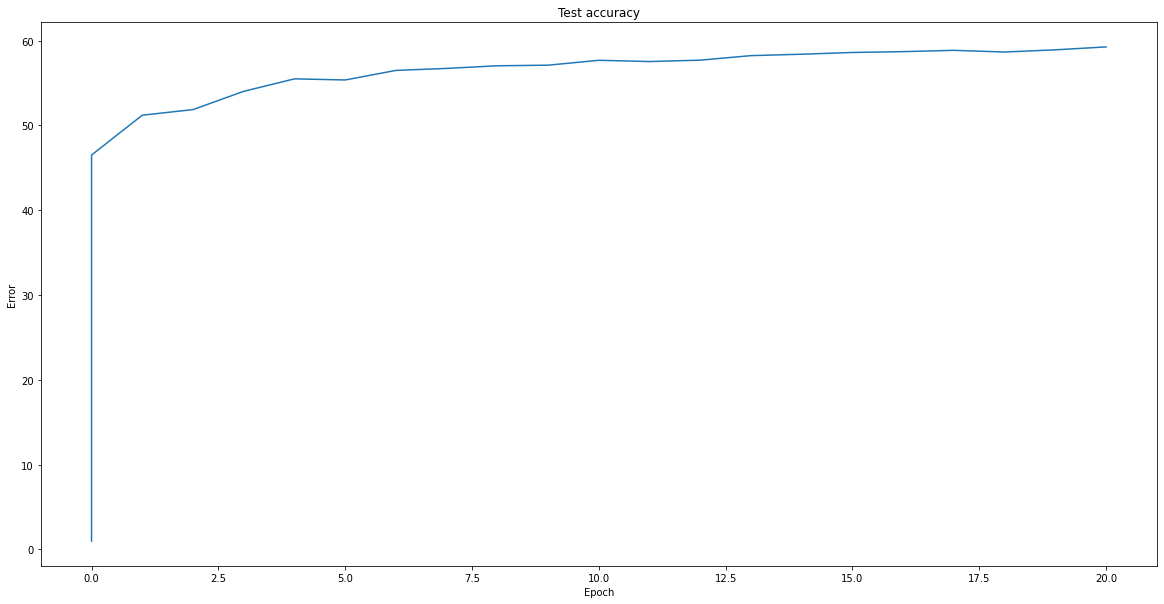

In [53]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log_lstm_lotr.pkl'


    data_train = LOTRDataset(DATA_PATH + 'LOTR_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = LOTRDataset(DATA_PATH + 'LOTR_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = LSTMLOTRNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'lstm_lotr_checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'lstm_lotr_checkpoints/%03d.pt' % epoch)
            seed_words = 'Frodo and Sam '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'lstm_lotr_checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

lstm_final_model, vocab, device = main()

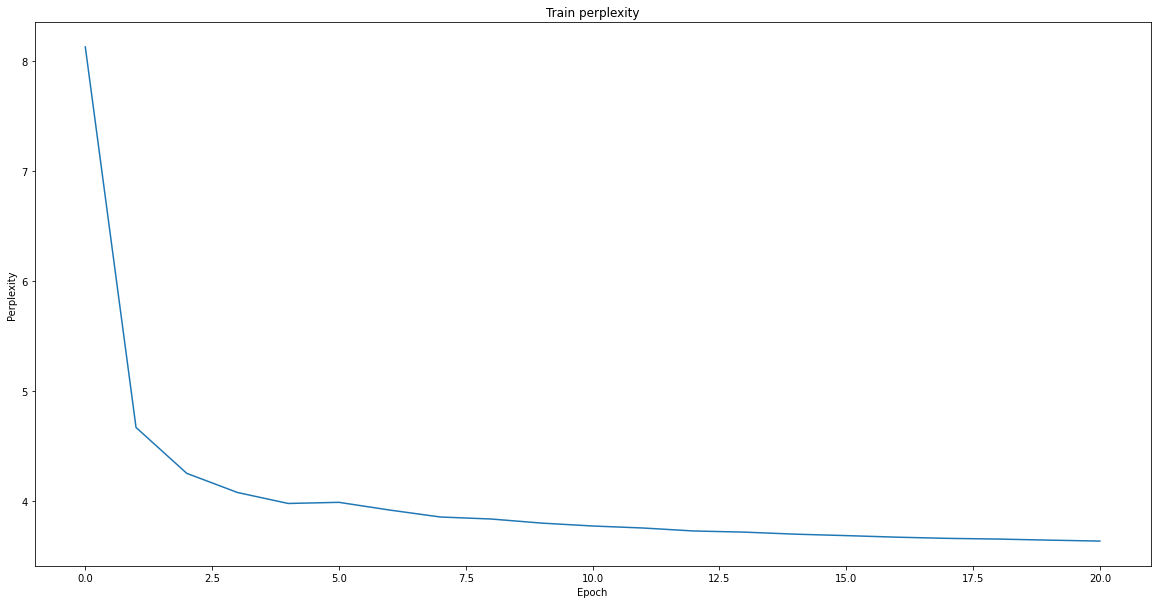

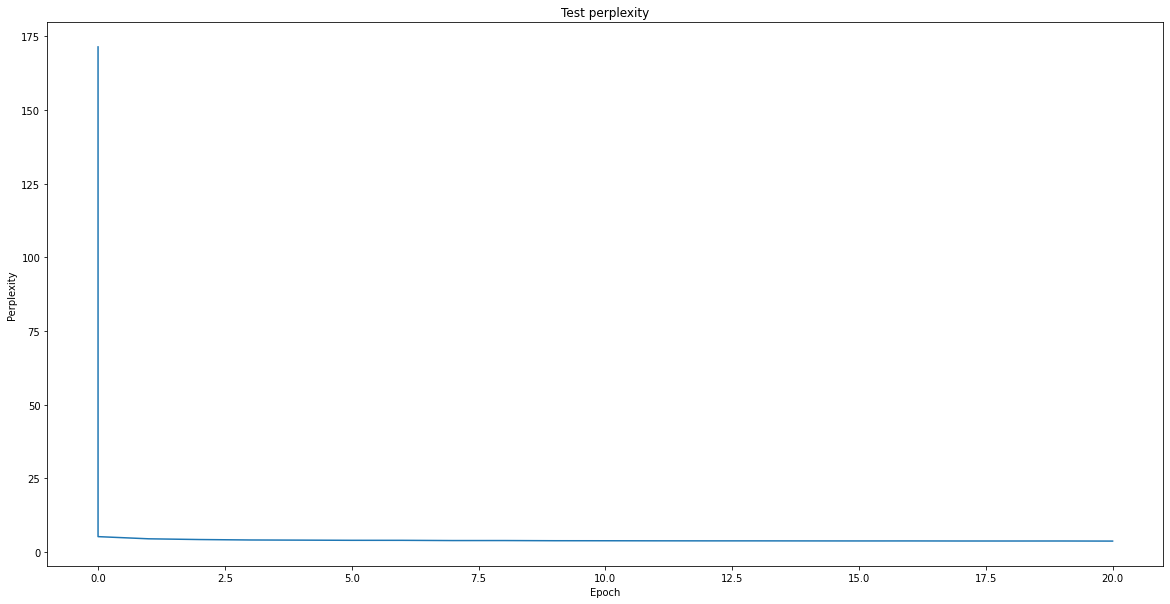

Train Perplexity:  3.636538658496678
Test Perplexity:  3.674796354151027


In [54]:
LOG_PATH = DATA_PATH + 'logs/log_lstm.pkl'
train_loss, test_loss, test_accuracy = pt_util.read_log(LOG_PATH, ([], [], []))
epochs, plogn = zip(*train_loss)
train_perplexity = np.exp(plogn)
pt_util.plot(epochs, train_perplexity, 'Train perplexity', 'Epoch', 'Perplexity')
epochs, plogn = zip(*test_loss)
test_perplexity = np.exp(plogn)
pt_util.plot(epochs, test_perplexity, 'Test perplexity', 'Epoch', 'Perplexity')
print("Train Perplexity: ", train_perplexity[-1])
print("Test Perplexity: ",test_perplexity[-1])

In [56]:
def eval_final_model(model, vocab, device):
    seed_words = 'Frodo and Sam'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(lstm_final_model, vocab, device)

generated with max	 Frodo and Sam was a stone of the wind of the wind of the wind of the wind was still and the wind was still and the wind was still and the wind was still and the wind was still and the wind was still and the wind w
generated with sample	 Frodo and Sam an every had to go and wondered and finder; and the fly water sharped under a tree in a noot storm of the firet of the land they took the thick frant and stood their light and heart him as he took an
generated with sample	 Frodo and Sammotioned and seemed to be finith as we got out and many finishing and that they came fortund. He could see mind we must.' 'Too,' said Fire, and they were on the white Swarines. And his faint was ready
generated with sample	 Frodo and Sam swared and then the King seemed to him when they stood in the beat of the pierce stone and both their lanel to be seen. At bearing him they had not seemed. A forbeat leave a yather that he had back i
generated with sample	 Frodo and Sam/lay called the roo

#Part 8.3: Training on Words

In [ ]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = data.split()
    word_count = {}
    voc2ind = {}
    index = 0

    for word in data:
        word_count[word] = word_count[word] + 1 if word in word_count else 0
    for word in data:
        if  word not in voc2ind and word_count[word] >= 5:
            voc2ind[word] = index
            index += 1
    voc2ind['<unknown>'] = index
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    ind2voc = {val: key for key, val in voc2ind.items()}

    eighty_percent = int(0.8 * len(data))
    train_text = data[:eighty_percent]
    test_text = data[eighty_percent:]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_word_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_word_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ' '.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] if word in self.voc2ind else self.voc2ind['<unknown>'] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)


In [62]:
import math

class HarryPotterDatasetWord(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDatasetWord, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.tokens = dataset['tokens']
        self.voc2ind = dataset['voc2ind']
        self.n = len(self.tokens) - (len(self.tokens) % batch_size)
        self.data_batches = torch.LongTensor([self.voc2ind[self.tokens[i]] if self.tokens[i] in self.voc2ind else self.voc2ind['<unknown>'] for i in range(self.n)]).view(batch_size, -1) 
        self.unique_seqs =  math.ceil((self.data_batches.shape[1] - 1) / self.sequence_length) * self.data_batches.shape[0]

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
         return self.unique_seqs
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # TODO
        batch = idx % self.batch_size
        sequence = idx // self.batch_size

        seq_begin = sequence * self.sequence_length
        seq_end = seq_begin + self.sequence_length + 1
        selection = self.data_batches[batch][seq_begin:min(self.data_batches.shape[1], seq_end)]
        return selection[:-1], selection[1:]

    def vocab_size(self):
        return len(self.vocab)

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([12593, 512]) = 25MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([12593, 512]) = 25MB
decoder.bias -> 	torch.Size([12593]) = 0MB

Restored all variables
No new variables
Restored /content/word_checkpoints3/002.pt
Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	<unknown> <unknown> in and the and the table


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the <unknown> <unknown> and <unknown> <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not of a he had be


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore 

  1%|          | 4/430 [00:00<00:30, 14.16it/s]

Train Epoch: 2 [0/110080 (0%)]	Loss: 5.813466


  3%|▎         | 14/430 [00:00<00:26, 15.71it/s]

Train Epoch: 2 [2560/110080 (2%)]	Loss: 6.097425


  6%|▌         | 24/430 [00:01<00:25, 15.87it/s]

Train Epoch: 2 [5120/110080 (5%)]	Loss: 6.056644


  8%|▊         | 34/430 [00:02<00:24, 15.94it/s]

Train Epoch: 2 [7680/110080 (7%)]	Loss: 5.967438


 10%|█         | 44/430 [00:02<00:24, 15.89it/s]

Train Epoch: 2 [10240/110080 (9%)]	Loss: 5.955099


 13%|█▎        | 54/430 [00:03<00:23, 15.77it/s]

Train Epoch: 2 [12800/110080 (12%)]	Loss: 5.836729


 15%|█▍        | 64/430 [00:04<00:23, 15.85it/s]

Train Epoch: 2 [15360/110080 (14%)]	Loss: 5.982327


 17%|█▋        | 74/430 [00:04<00:22, 15.99it/s]

Train Epoch: 2 [17920/110080 (16%)]	Loss: 5.720969


 20%|█▉        | 84/430 [00:05<00:21, 15.93it/s]

Train Epoch: 2 [20480/110080 (19%)]	Loss: 5.950133


 22%|██▏       | 94/430 [00:05<00:21, 15.85it/s]

Train Epoch: 2 [23040/110080 (21%)]	Loss: 5.710800


 24%|██▍       | 104/430 [00:06<00:20, 15.94it/s]

Train Epoch: 2 [25600/110080 (23%)]	Loss: 5.910296


 27%|██▋       | 114/430 [00:07<00:19, 15.96it/s]

Train Epoch: 2 [28160/110080 (26%)]	Loss: 5.941483


 29%|██▉       | 124/430 [00:07<00:19, 15.84it/s]

Train Epoch: 2 [30720/110080 (28%)]	Loss: 5.962245


 31%|███       | 134/430 [00:08<00:18, 15.89it/s]

Train Epoch: 2 [33280/110080 (30%)]	Loss: 5.922746


 33%|███▎      | 144/430 [00:09<00:17, 15.96it/s]

Train Epoch: 2 [35840/110080 (33%)]	Loss: 5.860058


 36%|███▌      | 154/430 [00:09<00:17, 15.87it/s]

Train Epoch: 2 [38400/110080 (35%)]	Loss: 5.773570


 38%|███▊      | 164/430 [00:10<00:16, 15.88it/s]

Train Epoch: 2 [40960/110080 (37%)]	Loss: 5.747935


 40%|████      | 174/430 [00:10<00:16, 15.84it/s]

Train Epoch: 2 [43520/110080 (40%)]	Loss: 5.839062


 43%|████▎     | 184/430 [00:11<00:15, 15.88it/s]

Train Epoch: 2 [46080/110080 (42%)]	Loss: 5.851354


 45%|████▌     | 194/430 [00:12<00:14, 15.82it/s]

Train Epoch: 2 [48640/110080 (44%)]	Loss: 5.820740


 47%|████▋     | 204/430 [00:12<00:14, 15.79it/s]

Train Epoch: 2 [51200/110080 (47%)]	Loss: 5.861805


 50%|████▉     | 214/430 [00:13<00:13, 15.85it/s]

Train Epoch: 2 [53760/110080 (49%)]	Loss: 5.785120


 52%|█████▏    | 224/430 [00:14<00:13, 15.84it/s]

Train Epoch: 2 [56320/110080 (51%)]	Loss: 5.833417


 54%|█████▍    | 234/430 [00:14<00:12, 15.80it/s]

Train Epoch: 2 [58880/110080 (53%)]	Loss: 5.852140


 57%|█████▋    | 244/430 [00:15<00:11, 15.93it/s]

Train Epoch: 2 [61440/110080 (56%)]	Loss: 5.890367


 59%|█████▉    | 254/430 [00:16<00:11, 15.91it/s]

Train Epoch: 2 [64000/110080 (58%)]	Loss: 5.840199


 61%|██████▏   | 264/430 [00:16<00:10, 15.89it/s]

Train Epoch: 2 [66560/110080 (60%)]	Loss: 5.848766


 64%|██████▎   | 274/430 [00:17<00:09, 15.75it/s]

Train Epoch: 2 [69120/110080 (63%)]	Loss: 5.832372


 66%|██████▌   | 284/430 [00:17<00:09, 15.77it/s]

Train Epoch: 2 [71680/110080 (65%)]	Loss: 5.702062


 68%|██████▊   | 294/430 [00:18<00:08, 15.62it/s]

Train Epoch: 2 [74240/110080 (67%)]	Loss: 5.861542


 71%|███████   | 304/430 [00:19<00:08, 15.67it/s]

Train Epoch: 2 [76800/110080 (70%)]	Loss: 5.792331


 73%|███████▎  | 314/430 [00:19<00:07, 15.78it/s]

Train Epoch: 2 [79360/110080 (72%)]	Loss: 5.769051


 75%|███████▌  | 324/430 [00:20<00:06, 15.84it/s]

Train Epoch: 2 [81920/110080 (74%)]	Loss: 5.815416


 78%|███████▊  | 334/430 [00:21<00:06, 15.82it/s]

Train Epoch: 2 [84480/110080 (77%)]	Loss: 5.766923


 80%|████████  | 344/430 [00:21<00:05, 15.65it/s]

Train Epoch: 2 [87040/110080 (79%)]	Loss: 5.745657


 82%|████████▏ | 354/430 [00:22<00:04, 15.80it/s]

Train Epoch: 2 [89600/110080 (81%)]	Loss: 5.783065


 85%|████████▍ | 364/430 [00:23<00:04, 15.85it/s]

Train Epoch: 2 [92160/110080 (84%)]	Loss: 5.796194


 87%|████████▋ | 374/430 [00:23<00:03, 15.82it/s]

Train Epoch: 2 [94720/110080 (86%)]	Loss: 5.843546


 89%|████████▉ | 384/430 [00:24<00:02, 15.77it/s]

Train Epoch: 2 [97280/110080 (88%)]	Loss: 5.736306


 92%|█████████▏| 394/430 [00:24<00:02, 15.85it/s]

Train Epoch: 2 [99840/110080 (91%)]	Loss: 5.811069


 94%|█████████▍| 404/430 [00:25<00:01, 15.61it/s]

Train Epoch: 2 [102400/110080 (93%)]	Loss: 5.868298


 96%|█████████▋| 414/430 [00:26<00:01, 15.73it/s]

Train Epoch: 2 [104960/110080 (95%)]	Loss: 5.850592


 99%|█████████▊| 424/430 [00:26<00:00, 15.81it/s]

Train Epoch: 2 [107520/110080 (98%)]	Loss: 5.870916


100%|██████████| 430/430 [00:27<00:00, 15.80it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	<unknown> <unknown> and and the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and and <unknown> <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not he the he had have


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said said Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> to he had <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to the said Harry looking as to be


Input	behind whenever they had entered a building ...
GT	whenever they had entered a building ... 

  1%|          | 3/430 [00:00<00:43,  9.91it/s]

Train Epoch: 3 [0/110080 (0%)]	Loss: 5.728090


  3%|▎         | 14/430 [00:01<00:27, 15.03it/s]

Train Epoch: 3 [2560/110080 (2%)]	Loss: 5.730227


  6%|▌         | 24/430 [00:01<00:26, 15.49it/s]

Train Epoch: 3 [5120/110080 (5%)]	Loss: 5.819359


  8%|▊         | 34/430 [00:02<00:25, 15.66it/s]

Train Epoch: 3 [7680/110080 (7%)]	Loss: 5.772737


 10%|█         | 44/430 [00:02<00:24, 15.80it/s]

Train Epoch: 3 [10240/110080 (9%)]	Loss: 5.794078


 13%|█▎        | 54/430 [00:03<00:23, 15.93it/s]

Train Epoch: 3 [12800/110080 (12%)]	Loss: 5.691719


 15%|█▍        | 64/430 [00:04<00:23, 15.77it/s]

Train Epoch: 3 [15360/110080 (14%)]	Loss: 5.850634


 17%|█▋        | 74/430 [00:04<00:22, 15.74it/s]

Train Epoch: 3 [17920/110080 (16%)]	Loss: 5.592506


 20%|█▉        | 84/430 [00:05<00:22, 15.71it/s]

Train Epoch: 3 [20480/110080 (19%)]	Loss: 5.837360


 22%|██▏       | 94/430 [00:06<00:21, 15.65it/s]

Train Epoch: 3 [23040/110080 (21%)]	Loss: 5.596560


 24%|██▍       | 104/430 [00:06<00:20, 15.72it/s]

Train Epoch: 3 [25600/110080 (23%)]	Loss: 5.798900


 27%|██▋       | 114/430 [00:07<00:20, 15.79it/s]

Train Epoch: 3 [28160/110080 (26%)]	Loss: 5.833402


 29%|██▉       | 124/430 [00:08<00:19, 15.87it/s]

Train Epoch: 3 [30720/110080 (28%)]	Loss: 5.863941


 31%|███       | 134/430 [00:08<00:18, 15.78it/s]

Train Epoch: 3 [33280/110080 (30%)]	Loss: 5.810205


 33%|███▎      | 144/430 [00:09<00:18, 15.74it/s]

Train Epoch: 3 [35840/110080 (33%)]	Loss: 5.754932


 36%|███▌      | 154/430 [00:09<00:17, 15.83it/s]

Train Epoch: 3 [38400/110080 (35%)]	Loss: 5.678794


 38%|███▊      | 164/430 [00:10<00:16, 15.90it/s]

Train Epoch: 3 [40960/110080 (37%)]	Loss: 5.669638


 40%|████      | 174/430 [00:11<00:16, 15.84it/s]

Train Epoch: 3 [43520/110080 (40%)]	Loss: 5.752131


 43%|████▎     | 184/430 [00:11<00:15, 15.69it/s]

Train Epoch: 3 [46080/110080 (42%)]	Loss: 5.765440


 45%|████▌     | 194/430 [00:12<00:15, 15.67it/s]

Train Epoch: 3 [48640/110080 (44%)]	Loss: 5.748998


 47%|████▋     | 204/430 [00:13<00:14, 15.75it/s]

Train Epoch: 3 [51200/110080 (47%)]	Loss: 5.775789


 50%|████▉     | 214/430 [00:13<00:13, 15.78it/s]

Train Epoch: 3 [53760/110080 (49%)]	Loss: 5.706458


 52%|█████▏    | 224/430 [00:14<00:13, 15.80it/s]

Train Epoch: 3 [56320/110080 (51%)]	Loss: 5.758136


 54%|█████▍    | 234/430 [00:15<00:12, 15.70it/s]

Train Epoch: 3 [58880/110080 (53%)]	Loss: 5.789329


 57%|█████▋    | 244/430 [00:15<00:11, 15.79it/s]

Train Epoch: 3 [61440/110080 (56%)]	Loss: 5.818634


 59%|█████▉    | 254/430 [00:16<00:11, 15.69it/s]

Train Epoch: 3 [64000/110080 (58%)]	Loss: 5.759359


 61%|██████▏   | 264/430 [00:16<00:10, 15.74it/s]

Train Epoch: 3 [66560/110080 (60%)]	Loss: 5.791297


 64%|██████▎   | 274/430 [00:17<00:09, 15.76it/s]

Train Epoch: 3 [69120/110080 (63%)]	Loss: 5.758263


 66%|██████▌   | 284/430 [00:18<00:09, 15.73it/s]

Train Epoch: 3 [71680/110080 (65%)]	Loss: 5.640487


 68%|██████▊   | 294/430 [00:18<00:08, 15.73it/s]

Train Epoch: 3 [74240/110080 (67%)]	Loss: 5.783022


 71%|███████   | 304/430 [00:19<00:07, 15.84it/s]

Train Epoch: 3 [76800/110080 (70%)]	Loss: 5.746456


 73%|███████▎  | 314/430 [00:20<00:07, 15.74it/s]

Train Epoch: 3 [79360/110080 (72%)]	Loss: 5.715201


 75%|███████▌  | 324/430 [00:20<00:06, 15.60it/s]

Train Epoch: 3 [81920/110080 (74%)]	Loss: 5.758504


 78%|███████▊  | 334/430 [00:21<00:06, 15.67it/s]

Train Epoch: 3 [84480/110080 (77%)]	Loss: 5.718136


 80%|████████  | 344/430 [00:21<00:05, 15.76it/s]

Train Epoch: 3 [87040/110080 (79%)]	Loss: 5.690932


 82%|████████▏ | 354/430 [00:22<00:04, 15.74it/s]

Train Epoch: 3 [89600/110080 (81%)]	Loss: 5.729544


 85%|████████▍ | 364/430 [00:23<00:04, 15.70it/s]

Train Epoch: 3 [92160/110080 (84%)]	Loss: 5.747797


 87%|████████▋ | 374/430 [00:23<00:03, 15.78it/s]

Train Epoch: 3 [94720/110080 (86%)]	Loss: 5.793280


 89%|████████▉ | 384/430 [00:24<00:02, 15.82it/s]

Train Epoch: 3 [97280/110080 (88%)]	Loss: 5.697405


 92%|█████████▏| 394/430 [00:25<00:02, 15.73it/s]

Train Epoch: 3 [99840/110080 (91%)]	Loss: 5.767933


 94%|█████████▍| 404/430 [00:25<00:01, 15.81it/s]

Train Epoch: 3 [102400/110080 (93%)]	Loss: 5.823302


 96%|█████████▋| 414/430 [00:26<00:01, 15.70it/s]

Train Epoch: 3 [104960/110080 (95%)]	Loss: 5.806420


 99%|█████████▊| 424/430 [00:27<00:00, 15.76it/s]

Train Epoch: 3 [107520/110080 (98%)]	Loss: 5.827128


100%|██████████| 430/430 [00:27<00:00, 15.65it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	<unknown> <unknown> and and the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and <unknown> the <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not of the he had have


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said <unknown> Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> <unknown> he <unknown> <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to the said Harry looking as to the


Input	behind whenever they had entered a building ...
GT	whenever they had ente

  0%|          | 1/430 [00:00<01:18,  5.50it/s]

Train Epoch: 4 [0/110080 (0%)]	Loss: 5.696105


  3%|▎         | 14/430 [00:01<00:27, 15.03it/s]

Train Epoch: 4 [2560/110080 (2%)]	Loss: 5.705116


  6%|▌         | 24/430 [00:01<00:25, 15.68it/s]

Train Epoch: 4 [5120/110080 (5%)]	Loss: 5.778862


  8%|▊         | 34/430 [00:02<00:24, 15.85it/s]

Train Epoch: 4 [7680/110080 (7%)]	Loss: 5.739263


 10%|█         | 44/430 [00:02<00:24, 15.78it/s]

Train Epoch: 4 [10240/110080 (9%)]	Loss: 5.755074


 13%|█▎        | 54/430 [00:03<00:23, 15.74it/s]

Train Epoch: 4 [12800/110080 (12%)]	Loss: 5.655763


 15%|█▍        | 64/430 [00:04<00:23, 15.82it/s]

Train Epoch: 4 [15360/110080 (14%)]	Loss: 5.809090


 17%|█▋        | 74/430 [00:04<00:22, 15.78it/s]

Train Epoch: 4 [17920/110080 (16%)]	Loss: 5.562420


 20%|█▉        | 84/430 [00:05<00:21, 15.84it/s]

Train Epoch: 4 [20480/110080 (19%)]	Loss: 5.805119


 22%|██▏       | 94/430 [00:06<00:21, 15.63it/s]

Train Epoch: 4 [23040/110080 (21%)]	Loss: 5.566506


 24%|██▍       | 104/430 [00:06<00:20, 15.79it/s]

Train Epoch: 4 [25600/110080 (23%)]	Loss: 5.768712


 27%|██▋       | 114/430 [00:07<00:20, 15.58it/s]

Train Epoch: 4 [28160/110080 (26%)]	Loss: 5.800652


 29%|██▉       | 124/430 [00:08<00:19, 15.78it/s]

Train Epoch: 4 [30720/110080 (28%)]	Loss: 5.841422


 31%|███       | 134/430 [00:08<00:18, 15.89it/s]

Train Epoch: 4 [33280/110080 (30%)]	Loss: 5.785846


 33%|███▎      | 144/430 [00:09<00:18, 15.74it/s]

Train Epoch: 4 [35840/110080 (33%)]	Loss: 5.731445


 36%|███▌      | 154/430 [00:09<00:17, 15.83it/s]

Train Epoch: 4 [38400/110080 (35%)]	Loss: 5.653939


 38%|███▊      | 164/430 [00:10<00:16, 15.72it/s]

Train Epoch: 4 [40960/110080 (37%)]	Loss: 5.642566


 40%|████      | 174/430 [00:11<00:16, 15.79it/s]

Train Epoch: 4 [43520/110080 (40%)]	Loss: 5.733215


 43%|████▎     | 184/430 [00:11<00:15, 15.80it/s]

Train Epoch: 4 [46080/110080 (42%)]	Loss: 5.737909


 45%|████▌     | 194/430 [00:12<00:14, 15.80it/s]

Train Epoch: 4 [48640/110080 (44%)]	Loss: 5.719548


 47%|████▋     | 204/430 [00:13<00:14, 15.76it/s]

Train Epoch: 4 [51200/110080 (47%)]	Loss: 5.747143


 50%|████▉     | 214/430 [00:13<00:13, 15.69it/s]

Train Epoch: 4 [53760/110080 (49%)]	Loss: 5.687323


 52%|█████▏    | 224/430 [00:14<00:13, 15.76it/s]

Train Epoch: 4 [56320/110080 (51%)]	Loss: 5.736659


 54%|█████▍    | 234/430 [00:14<00:12, 15.79it/s]

Train Epoch: 4 [58880/110080 (53%)]	Loss: 5.767593


 57%|█████▋    | 244/430 [00:15<00:11, 15.94it/s]

Train Epoch: 4 [61440/110080 (56%)]	Loss: 5.793385


 59%|█████▉    | 254/430 [00:16<00:11, 15.76it/s]

Train Epoch: 4 [64000/110080 (58%)]	Loss: 5.730791


 61%|██████▏   | 264/430 [00:16<00:10, 15.77it/s]

Train Epoch: 4 [66560/110080 (60%)]	Loss: 5.764143


 64%|██████▎   | 274/430 [00:17<00:09, 15.79it/s]

Train Epoch: 4 [69120/110080 (63%)]	Loss: 5.737229


 66%|██████▌   | 284/430 [00:18<00:09, 15.82it/s]

Train Epoch: 4 [71680/110080 (65%)]	Loss: 5.616444


 68%|██████▊   | 294/430 [00:18<00:08, 15.75it/s]

Train Epoch: 4 [74240/110080 (67%)]	Loss: 5.755343


 71%|███████   | 304/430 [00:19<00:07, 15.84it/s]

Train Epoch: 4 [76800/110080 (70%)]	Loss: 5.714510


 73%|███████▎  | 314/430 [00:20<00:07, 15.74it/s]

Train Epoch: 4 [79360/110080 (72%)]	Loss: 5.690610


 75%|███████▌  | 324/430 [00:20<00:06, 15.75it/s]

Train Epoch: 4 [81920/110080 (74%)]	Loss: 5.733197


 78%|███████▊  | 334/430 [00:21<00:06, 15.81it/s]

Train Epoch: 4 [84480/110080 (77%)]	Loss: 5.699615


 80%|████████  | 344/430 [00:21<00:05, 15.68it/s]

Train Epoch: 4 [87040/110080 (79%)]	Loss: 5.671167


 82%|████████▏ | 354/430 [00:22<00:04, 15.80it/s]

Train Epoch: 4 [89600/110080 (81%)]	Loss: 5.710382


 85%|████████▍ | 364/430 [00:23<00:04, 15.75it/s]

Train Epoch: 4 [92160/110080 (84%)]	Loss: 5.726609


 87%|████████▋ | 374/430 [00:23<00:03, 15.74it/s]

Train Epoch: 4 [94720/110080 (86%)]	Loss: 5.771960


 89%|████████▉ | 384/430 [00:24<00:02, 15.71it/s]

Train Epoch: 4 [97280/110080 (88%)]	Loss: 5.675682


 92%|█████████▏| 394/430 [00:25<00:02, 15.63it/s]

Train Epoch: 4 [99840/110080 (91%)]	Loss: 5.757649


 94%|█████████▍| 404/430 [00:25<00:01, 15.75it/s]

Train Epoch: 4 [102400/110080 (93%)]	Loss: 5.807678


 96%|█████████▋| 414/430 [00:26<00:01, 15.76it/s]

Train Epoch: 4 [104960/110080 (95%)]	Loss: 5.787315


 99%|█████████▊| 424/430 [00:27<00:00, 15.63it/s]

Train Epoch: 4 [107520/110080 (98%)]	Loss: 5.810114


100%|██████████| 430/430 [00:27<00:00, 15.65it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	<unknown> <unknown> and and the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and of <unknown> <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not he a he had have


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said <unknown> Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> <unknown> he <unknown> <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to the said Harry looking as to the


Input	behind whenever they had entered a building ...
GT	whenever they had entered

  0%|          | 1/430 [00:00<01:20,  5.33it/s]

Train Epoch: 5 [0/110080 (0%)]	Loss: 5.676785


  3%|▎         | 14/430 [00:01<00:27, 14.92it/s]

Train Epoch: 5 [2560/110080 (2%)]	Loss: 5.689850


  6%|▌         | 24/430 [00:01<00:26, 15.41it/s]

Train Epoch: 5 [5120/110080 (5%)]	Loss: 5.756008


  8%|▊         | 34/430 [00:02<00:25, 15.71it/s]

Train Epoch: 5 [7680/110080 (7%)]	Loss: 5.727611


 10%|█         | 44/430 [00:02<00:24, 15.84it/s]

Train Epoch: 5 [10240/110080 (9%)]	Loss: 5.739648


 13%|█▎        | 54/430 [00:03<00:23, 15.67it/s]

Train Epoch: 5 [12800/110080 (12%)]	Loss: 5.644143


 15%|█▍        | 64/430 [00:04<00:23, 15.79it/s]

Train Epoch: 5 [15360/110080 (14%)]	Loss: 5.795255


 17%|█▋        | 74/430 [00:04<00:22, 15.75it/s]

Train Epoch: 5 [17920/110080 (16%)]	Loss: 5.551042


 20%|█▉        | 84/430 [00:05<00:21, 15.90it/s]

Train Epoch: 5 [20480/110080 (19%)]	Loss: 5.788705


 22%|██▏       | 94/430 [00:06<00:21, 15.69it/s]

Train Epoch: 5 [23040/110080 (21%)]	Loss: 5.545423


 24%|██▍       | 104/430 [00:06<00:20, 15.83it/s]

Train Epoch: 5 [25600/110080 (23%)]	Loss: 5.752066


 27%|██▋       | 114/430 [00:07<00:20, 15.71it/s]

Train Epoch: 5 [28160/110080 (26%)]	Loss: 5.784166


 29%|██▉       | 124/430 [00:08<00:19, 15.75it/s]

Train Epoch: 5 [30720/110080 (28%)]	Loss: 5.830836


 31%|███       | 134/430 [00:08<00:18, 15.70it/s]

Train Epoch: 5 [33280/110080 (30%)]	Loss: 5.768701


 33%|███▎      | 144/430 [00:09<00:18, 15.71it/s]

Train Epoch: 5 [35840/110080 (33%)]	Loss: 5.717150


 36%|███▌      | 154/430 [00:09<00:17, 15.77it/s]

Train Epoch: 5 [38400/110080 (35%)]	Loss: 5.636312


 38%|███▊      | 164/430 [00:10<00:16, 15.87it/s]

Train Epoch: 5 [40960/110080 (37%)]	Loss: 5.624840


 40%|████      | 174/430 [00:11<00:16, 15.64it/s]

Train Epoch: 5 [43520/110080 (40%)]	Loss: 5.723839


 43%|████▎     | 184/430 [00:11<00:15, 15.69it/s]

Train Epoch: 5 [46080/110080 (42%)]	Loss: 5.724776


 45%|████▌     | 194/430 [00:12<00:15, 15.71it/s]

Train Epoch: 5 [48640/110080 (44%)]	Loss: 5.707110


 47%|████▋     | 204/430 [00:13<00:14, 15.75it/s]

Train Epoch: 5 [51200/110080 (47%)]	Loss: 5.732274


 50%|████▉     | 214/430 [00:13<00:13, 15.71it/s]

Train Epoch: 5 [53760/110080 (49%)]	Loss: 5.678473


 52%|█████▏    | 224/430 [00:14<00:13, 15.74it/s]

Train Epoch: 5 [56320/110080 (51%)]	Loss: 5.727544


 54%|█████▍    | 234/430 [00:15<00:12, 15.73it/s]

Train Epoch: 5 [58880/110080 (53%)]	Loss: 5.757752


 57%|█████▋    | 244/430 [00:15<00:11, 15.74it/s]

Train Epoch: 5 [61440/110080 (56%)]	Loss: 5.782081


 59%|█████▉    | 254/430 [00:16<00:11, 15.78it/s]

Train Epoch: 5 [64000/110080 (58%)]	Loss: 5.718567


 61%|██████▏   | 264/430 [00:16<00:10, 15.80it/s]

Train Epoch: 5 [66560/110080 (60%)]	Loss: 5.750641


 64%|██████▎   | 274/430 [00:17<00:09, 15.76it/s]

Train Epoch: 5 [69120/110080 (63%)]	Loss: 5.727921


 66%|██████▌   | 284/430 [00:18<00:09, 15.83it/s]

Train Epoch: 5 [71680/110080 (65%)]	Loss: 5.606030


 68%|██████▊   | 294/430 [00:18<00:08, 15.81it/s]

Train Epoch: 5 [74240/110080 (67%)]	Loss: 5.746746


 71%|███████   | 304/430 [00:19<00:07, 15.80it/s]

Train Epoch: 5 [76800/110080 (70%)]	Loss: 5.708630


 73%|███████▎  | 314/430 [00:20<00:07, 15.80it/s]

Train Epoch: 5 [79360/110080 (72%)]	Loss: 5.683146


 75%|███████▌  | 324/430 [00:20<00:06, 15.82it/s]

Train Epoch: 5 [81920/110080 (74%)]	Loss: 5.721463


 78%|███████▊  | 334/430 [00:21<00:06, 15.85it/s]

Train Epoch: 5 [84480/110080 (77%)]	Loss: 5.690168


 80%|████████  | 344/430 [00:21<00:05, 15.73it/s]

Train Epoch: 5 [87040/110080 (79%)]	Loss: 5.659324


 82%|████████▏ | 354/430 [00:22<00:04, 15.69it/s]

Train Epoch: 5 [89600/110080 (81%)]	Loss: 5.694704


 85%|████████▍ | 364/430 [00:23<00:04, 15.79it/s]

Train Epoch: 5 [92160/110080 (84%)]	Loss: 5.711846


 87%|████████▋ | 374/430 [00:23<00:03, 15.74it/s]

Train Epoch: 5 [94720/110080 (86%)]	Loss: 5.760122


 89%|████████▉ | 384/430 [00:24<00:02, 15.69it/s]

Train Epoch: 5 [97280/110080 (88%)]	Loss: 5.661539


 92%|█████████▏| 394/430 [00:25<00:02, 15.82it/s]

Train Epoch: 5 [99840/110080 (91%)]	Loss: 5.744015


 94%|█████████▍| 404/430 [00:25<00:01, 15.80it/s]

Train Epoch: 5 [102400/110080 (93%)]	Loss: 5.794481


 96%|█████████▋| 414/430 [00:26<00:01, 15.66it/s]

Train Epoch: 5 [104960/110080 (95%)]	Loss: 5.784890


 99%|█████████▊| 424/430 [00:27<00:00, 15.58it/s]

Train Epoch: 5 [107520/110080 (98%)]	Loss: 5.800669


100%|██████████| 430/430 [00:27<00:00, 15.64it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	to <unknown> and and the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and of <unknown> <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not he a he had have


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said said Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> <unknown> he <unknown> <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to <unknown> said Harry looking as to <unknown>


Input	behind whenever they had entered a building ...
GT	whenever they had entered

  0%|          | 1/430 [00:00<01:16,  5.62it/s]

Train Epoch: 6 [0/110080 (0%)]	Loss: 5.667319


  3%|▎         | 14/430 [00:01<00:27, 15.16it/s]

Train Epoch: 6 [2560/110080 (2%)]	Loss: 5.679719


  6%|▌         | 24/430 [00:01<00:26, 15.52it/s]

Train Epoch: 6 [5120/110080 (5%)]	Loss: 5.748704


  8%|▊         | 34/430 [00:02<00:25, 15.74it/s]

Train Epoch: 6 [7680/110080 (7%)]	Loss: 5.721725


 10%|█         | 44/430 [00:02<00:24, 15.82it/s]

Train Epoch: 6 [10240/110080 (9%)]	Loss: 5.729290


 13%|█▎        | 54/430 [00:03<00:23, 15.72it/s]

Train Epoch: 6 [12800/110080 (12%)]	Loss: 5.635108


 15%|█▍        | 64/430 [00:04<00:23, 15.88it/s]

Train Epoch: 6 [15360/110080 (14%)]	Loss: 5.785694


 17%|█▋        | 74/430 [00:04<00:22, 15.60it/s]

Train Epoch: 6 [17920/110080 (16%)]	Loss: 5.541084


 20%|█▉        | 84/430 [00:05<00:21, 15.87it/s]

Train Epoch: 6 [20480/110080 (19%)]	Loss: 5.776812


 22%|██▏       | 94/430 [00:06<00:21, 15.66it/s]

Train Epoch: 6 [23040/110080 (21%)]	Loss: 5.533338


 24%|██▍       | 104/430 [00:06<00:20, 15.86it/s]

Train Epoch: 6 [25600/110080 (23%)]	Loss: 5.743236


 27%|██▋       | 114/430 [00:07<00:19, 15.82it/s]

Train Epoch: 6 [28160/110080 (26%)]	Loss: 5.771482


 29%|██▉       | 124/430 [00:08<00:19, 15.80it/s]

Train Epoch: 6 [30720/110080 (28%)]	Loss: 5.823905


 31%|███       | 134/430 [00:08<00:18, 15.73it/s]

Train Epoch: 6 [33280/110080 (30%)]	Loss: 5.758530


 33%|███▎      | 144/430 [00:09<00:18, 15.78it/s]

Train Epoch: 6 [35840/110080 (33%)]	Loss: 5.706598


 36%|███▌      | 154/430 [00:09<00:17, 15.74it/s]

Train Epoch: 6 [38400/110080 (35%)]	Loss: 5.628325


 38%|███▊      | 164/430 [00:10<00:16, 15.80it/s]

Train Epoch: 6 [40960/110080 (37%)]	Loss: 5.612862


 40%|████      | 174/430 [00:11<00:16, 15.80it/s]

Train Epoch: 6 [43520/110080 (40%)]	Loss: 5.716262


 43%|████▎     | 184/430 [00:11<00:15, 15.64it/s]

Train Epoch: 6 [46080/110080 (42%)]	Loss: 5.714928


 45%|████▌     | 194/430 [00:12<00:15, 15.62it/s]

Train Epoch: 6 [48640/110080 (44%)]	Loss: 5.699139


 47%|████▋     | 204/430 [00:13<00:14, 15.84it/s]

Train Epoch: 6 [51200/110080 (47%)]	Loss: 5.723596


 50%|████▉     | 214/430 [00:13<00:13, 15.67it/s]

Train Epoch: 6 [53760/110080 (49%)]	Loss: 5.667765


 52%|█████▏    | 224/430 [00:14<00:13, 15.81it/s]

Train Epoch: 6 [56320/110080 (51%)]	Loss: 5.719488


 54%|█████▍    | 234/430 [00:15<00:12, 15.76it/s]

Train Epoch: 6 [58880/110080 (53%)]	Loss: 5.745684


 57%|█████▋    | 244/430 [00:15<00:11, 15.83it/s]

Train Epoch: 6 [61440/110080 (56%)]	Loss: 5.772820


 59%|█████▉    | 254/430 [00:16<00:11, 15.74it/s]

Train Epoch: 6 [64000/110080 (58%)]	Loss: 5.711200


 61%|██████▏   | 264/430 [00:16<00:10, 15.82it/s]

Train Epoch: 6 [66560/110080 (60%)]	Loss: 5.738731


 64%|██████▎   | 274/430 [00:17<00:09, 15.85it/s]

Train Epoch: 6 [69120/110080 (63%)]	Loss: 5.718760


 66%|██████▌   | 284/430 [00:18<00:09, 15.87it/s]

Train Epoch: 6 [71680/110080 (65%)]	Loss: 5.595448


 68%|██████▊   | 294/430 [00:18<00:08, 15.79it/s]

Train Epoch: 6 [74240/110080 (67%)]	Loss: 5.739523


 71%|███████   | 304/430 [00:19<00:08, 15.63it/s]

Train Epoch: 6 [76800/110080 (70%)]	Loss: 5.702818


 73%|███████▎  | 314/430 [00:20<00:07, 15.81it/s]

Train Epoch: 6 [79360/110080 (72%)]	Loss: 5.674806


 75%|███████▌  | 324/430 [00:20<00:06, 15.80it/s]

Train Epoch: 6 [81920/110080 (74%)]	Loss: 5.713199


 78%|███████▊  | 334/430 [00:21<00:06, 15.83it/s]

Train Epoch: 6 [84480/110080 (77%)]	Loss: 5.680015


 80%|████████  | 344/430 [00:21<00:05, 15.56it/s]

Train Epoch: 6 [87040/110080 (79%)]	Loss: 5.650576


 82%|████████▏ | 354/430 [00:22<00:04, 15.79it/s]

Train Epoch: 6 [89600/110080 (81%)]	Loss: 5.687216


 85%|████████▍ | 364/430 [00:23<00:04, 15.72it/s]

Train Epoch: 6 [92160/110080 (84%)]	Loss: 5.702064


 87%|████████▋ | 374/430 [00:23<00:03, 15.63it/s]

Train Epoch: 6 [94720/110080 (86%)]	Loss: 5.751607


 89%|████████▉ | 384/430 [00:24<00:02, 15.64it/s]

Train Epoch: 6 [97280/110080 (88%)]	Loss: 5.653611


 92%|█████████▏| 394/430 [00:25<00:02, 15.77it/s]

Train Epoch: 6 [99840/110080 (91%)]	Loss: 5.735421


 94%|█████████▍| 404/430 [00:25<00:01, 15.80it/s]

Train Epoch: 6 [102400/110080 (93%)]	Loss: 5.784862


 96%|█████████▋| 414/430 [00:26<00:01, 15.78it/s]

Train Epoch: 6 [104960/110080 (95%)]	Loss: 5.779720


 99%|█████████▊| 424/430 [00:27<00:00, 15.76it/s]

Train Epoch: 6 [107520/110080 (98%)]	Loss: 5.792338


100%|██████████| 430/430 [00:27<00:00, 15.64it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	to <unknown> and and the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and of <unknown> <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not he a he had be


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said said Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> <unknown> he <unknown> <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to <unknown> said Harry looking as to <unknown>


Input	behind whenever they had entered a building ...
GT	whenever they had entered a

  0%|          | 1/430 [00:00<01:16,  5.62it/s]

Train Epoch: 7 [0/110080 (0%)]	Loss: 5.659389


  3%|▎         | 14/430 [00:01<00:27, 15.21it/s]

Train Epoch: 7 [2560/110080 (2%)]	Loss: 5.670984


  6%|▌         | 24/430 [00:01<00:26, 15.61it/s]

Train Epoch: 7 [5120/110080 (5%)]	Loss: 5.741707


  8%|▊         | 34/430 [00:02<00:25, 15.82it/s]

Train Epoch: 7 [7680/110080 (7%)]	Loss: 5.714691


 10%|█         | 44/430 [00:02<00:24, 15.64it/s]

Train Epoch: 7 [10240/110080 (9%)]	Loss: 5.724593


 13%|█▎        | 54/430 [00:03<00:23, 15.69it/s]

Train Epoch: 7 [12800/110080 (12%)]	Loss: 5.627841


 15%|█▍        | 64/430 [00:04<00:23, 15.77it/s]

Train Epoch: 7 [15360/110080 (14%)]	Loss: 5.779099


 17%|█▋        | 74/430 [00:04<00:22, 15.74it/s]

Train Epoch: 7 [17920/110080 (16%)]	Loss: 5.534954


 20%|█▉        | 84/430 [00:05<00:22, 15.65it/s]

Train Epoch: 7 [20480/110080 (19%)]	Loss: 5.768098


 22%|██▏       | 94/430 [00:06<00:21, 15.75it/s]

Train Epoch: 7 [23040/110080 (21%)]	Loss: 5.525749


 24%|██▍       | 104/430 [00:06<00:20, 15.72it/s]

Train Epoch: 7 [25600/110080 (23%)]	Loss: 5.735783


 27%|██▋       | 114/430 [00:07<00:20, 15.70it/s]

Train Epoch: 7 [28160/110080 (26%)]	Loss: 5.760699


 29%|██▉       | 124/430 [00:08<00:19, 15.72it/s]

Train Epoch: 7 [30720/110080 (28%)]	Loss: 5.816906


 31%|███       | 134/430 [00:08<00:18, 15.73it/s]

Train Epoch: 7 [33280/110080 (30%)]	Loss: 5.750842


 33%|███▎      | 144/430 [00:09<00:18, 15.84it/s]

Train Epoch: 7 [35840/110080 (33%)]	Loss: 5.699779


 36%|███▌      | 154/430 [00:09<00:17, 15.73it/s]

Train Epoch: 7 [38400/110080 (35%)]	Loss: 5.622111


 38%|███▊      | 164/430 [00:10<00:16, 15.70it/s]

Train Epoch: 7 [40960/110080 (37%)]	Loss: 5.604112


 40%|████      | 174/430 [00:11<00:16, 15.71it/s]

Train Epoch: 7 [43520/110080 (40%)]	Loss: 5.709349


 43%|████▎     | 184/430 [00:11<00:15, 15.73it/s]

Train Epoch: 7 [46080/110080 (42%)]	Loss: 5.707325


 45%|████▌     | 194/430 [00:12<00:15, 15.67it/s]

Train Epoch: 7 [48640/110080 (44%)]	Loss: 5.689306


 47%|████▋     | 204/430 [00:13<00:14, 15.77it/s]

Train Epoch: 7 [51200/110080 (47%)]	Loss: 5.714884


 50%|████▉     | 214/430 [00:13<00:13, 15.72it/s]

Train Epoch: 7 [53760/110080 (49%)]	Loss: 5.659947


 52%|█████▏    | 224/430 [00:14<00:13, 15.71it/s]

Train Epoch: 7 [56320/110080 (51%)]	Loss: 5.711884


 54%|█████▍    | 234/430 [00:14<00:12, 15.73it/s]

Train Epoch: 7 [58880/110080 (53%)]	Loss: 5.736851


 57%|█████▋    | 244/430 [00:15<00:11, 15.63it/s]

Train Epoch: 7 [61440/110080 (56%)]	Loss: 5.764159


 59%|█████▉    | 254/430 [00:16<00:11, 15.81it/s]

Train Epoch: 7 [64000/110080 (58%)]	Loss: 5.704998


 61%|██████▏   | 264/430 [00:16<00:10, 15.74it/s]

Train Epoch: 7 [66560/110080 (60%)]	Loss: 5.731021


 64%|██████▎   | 274/430 [00:17<00:09, 15.74it/s]

Train Epoch: 7 [69120/110080 (63%)]	Loss: 5.711639


 66%|██████▌   | 284/430 [00:18<00:09, 15.70it/s]

Train Epoch: 7 [71680/110080 (65%)]	Loss: 5.587561


 68%|██████▊   | 294/430 [00:18<00:08, 15.67it/s]

Train Epoch: 7 [74240/110080 (67%)]	Loss: 5.732695


 71%|███████   | 304/430 [00:19<00:08, 15.71it/s]

Train Epoch: 7 [76800/110080 (70%)]	Loss: 5.695692


 73%|███████▎  | 314/430 [00:20<00:07, 15.67it/s]

Train Epoch: 7 [79360/110080 (72%)]	Loss: 5.667305


 75%|███████▌  | 324/430 [00:20<00:06, 15.86it/s]

Train Epoch: 7 [81920/110080 (74%)]	Loss: 5.705343


 78%|███████▊  | 334/430 [00:21<00:06, 15.75it/s]

Train Epoch: 7 [84480/110080 (77%)]	Loss: 5.673265


 80%|████████  | 344/430 [00:21<00:05, 15.78it/s]

Train Epoch: 7 [87040/110080 (79%)]	Loss: 5.643709


 82%|████████▏ | 354/430 [00:22<00:04, 15.71it/s]

Train Epoch: 7 [89600/110080 (81%)]	Loss: 5.681115


 85%|████████▍ | 364/430 [00:23<00:04, 15.72it/s]

Train Epoch: 7 [92160/110080 (84%)]	Loss: 5.693969


 87%|████████▋ | 374/430 [00:23<00:03, 15.77it/s]

Train Epoch: 7 [94720/110080 (86%)]	Loss: 5.744516


 89%|████████▉ | 384/430 [00:24<00:02, 15.65it/s]

Train Epoch: 7 [97280/110080 (88%)]	Loss: 5.646888


 92%|█████████▏| 394/430 [00:25<00:02, 15.80it/s]

Train Epoch: 7 [99840/110080 (91%)]	Loss: 5.728277


 94%|█████████▍| 404/430 [00:25<00:01, 15.69it/s]

Train Epoch: 7 [102400/110080 (93%)]	Loss: 5.777034


 96%|█████████▋| 414/430 [00:26<00:01, 15.66it/s]

Train Epoch: 7 [104960/110080 (95%)]	Loss: 5.773432


 99%|█████████▊| 424/430 [00:27<00:00, 15.81it/s]

Train Epoch: 7 [107520/110080 (98%)]	Loss: 5.785318


100%|██████████| 430/430 [00:27<00:00, 15.64it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	to <unknown> and and the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and of <unknown> <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not he a he had be


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said said Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> to he <unknown> <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to <unknown> <unknown> Harry looking as to <unknown>


Input	behind whenever they had entered a building ...
GT	whenever they had entered a b

  0%|          | 1/430 [00:00<01:16,  5.60it/s]

Train Epoch: 8 [0/110080 (0%)]	Loss: 5.652579


  3%|▎         | 14/430 [00:01<00:27, 15.11it/s]

Train Epoch: 8 [2560/110080 (2%)]	Loss: 5.663844


  6%|▌         | 24/430 [00:01<00:25, 15.67it/s]

Train Epoch: 8 [5120/110080 (5%)]	Loss: 5.735098


  8%|▊         | 34/430 [00:02<00:25, 15.79it/s]

Train Epoch: 8 [7680/110080 (7%)]	Loss: 5.707071


 10%|█         | 44/430 [00:02<00:24, 15.84it/s]

Train Epoch: 8 [10240/110080 (9%)]	Loss: 5.720408


 13%|█▎        | 54/430 [00:03<00:23, 15.94it/s]

Train Epoch: 8 [12800/110080 (12%)]	Loss: 5.621709


 15%|█▍        | 64/430 [00:04<00:23, 15.79it/s]

Train Epoch: 8 [15360/110080 (14%)]	Loss: 5.773164


 17%|█▋        | 74/430 [00:04<00:22, 15.81it/s]

Train Epoch: 8 [17920/110080 (16%)]	Loss: 5.529680


 20%|█▉        | 84/430 [00:05<00:21, 15.74it/s]

Train Epoch: 8 [20480/110080 (19%)]	Loss: 5.761492


 22%|██▏       | 94/430 [00:06<00:21, 15.92it/s]

Train Epoch: 8 [23040/110080 (21%)]	Loss: 5.519001


 24%|██▍       | 104/430 [00:06<00:20, 15.79it/s]

Train Epoch: 8 [25600/110080 (23%)]	Loss: 5.728297


 27%|██▋       | 114/430 [00:07<00:20, 15.75it/s]

Train Epoch: 8 [28160/110080 (26%)]	Loss: 5.752179


 29%|██▉       | 124/430 [00:08<00:19, 15.71it/s]

Train Epoch: 8 [30720/110080 (28%)]	Loss: 5.812261


 31%|███       | 134/430 [00:08<00:18, 15.82it/s]

Train Epoch: 8 [33280/110080 (30%)]	Loss: 5.743727


 33%|███▎      | 144/430 [00:09<00:18, 15.71it/s]

Train Epoch: 8 [35840/110080 (33%)]	Loss: 5.694014


 36%|███▌      | 154/430 [00:09<00:17, 15.89it/s]

Train Epoch: 8 [38400/110080 (35%)]	Loss: 5.617365


 38%|███▊      | 164/430 [00:10<00:16, 15.87it/s]

Train Epoch: 8 [40960/110080 (37%)]	Loss: 5.596899


 40%|████      | 174/430 [00:11<00:16, 15.69it/s]

Train Epoch: 8 [43520/110080 (40%)]	Loss: 5.703486


 43%|████▎     | 184/430 [00:11<00:15, 15.76it/s]

Train Epoch: 8 [46080/110080 (42%)]	Loss: 5.701303


 45%|████▌     | 194/430 [00:12<00:14, 15.79it/s]

Train Epoch: 8 [48640/110080 (44%)]	Loss: 5.682271


 47%|████▋     | 204/430 [00:13<00:14, 15.68it/s]

Train Epoch: 8 [51200/110080 (47%)]	Loss: 5.707716


 50%|████▉     | 214/430 [00:13<00:13, 15.80it/s]

Train Epoch: 8 [53760/110080 (49%)]	Loss: 5.652654


 52%|█████▏    | 224/430 [00:14<00:13, 15.79it/s]

Train Epoch: 8 [56320/110080 (51%)]	Loss: 5.704891


 54%|█████▍    | 234/430 [00:14<00:12, 15.85it/s]

Train Epoch: 8 [58880/110080 (53%)]	Loss: 5.730947


 57%|█████▋    | 244/430 [00:15<00:11, 15.80it/s]

Train Epoch: 8 [61440/110080 (56%)]	Loss: 5.756998


 59%|█████▉    | 254/430 [00:16<00:11, 15.88it/s]

Train Epoch: 8 [64000/110080 (58%)]	Loss: 5.698856


 61%|██████▏   | 264/430 [00:16<00:10, 15.81it/s]

Train Epoch: 8 [66560/110080 (60%)]	Loss: 5.725358


 64%|██████▎   | 274/430 [00:17<00:09, 15.62it/s]

Train Epoch: 8 [69120/110080 (63%)]	Loss: 5.705749


 66%|██████▌   | 284/430 [00:18<00:09, 15.75it/s]

Train Epoch: 8 [71680/110080 (65%)]	Loss: 5.580923


 68%|██████▊   | 294/430 [00:18<00:08, 15.73it/s]

Train Epoch: 8 [74240/110080 (67%)]	Loss: 5.726172


 71%|███████   | 304/430 [00:19<00:08, 15.74it/s]

Train Epoch: 8 [76800/110080 (70%)]	Loss: 5.690059


 73%|███████▎  | 314/430 [00:20<00:07, 15.83it/s]

Train Epoch: 8 [79360/110080 (72%)]	Loss: 5.662507


 75%|███████▌  | 324/430 [00:20<00:06, 15.69it/s]

Train Epoch: 8 [81920/110080 (74%)]	Loss: 5.698512


 78%|███████▊  | 334/430 [00:21<00:06, 15.74it/s]

Train Epoch: 8 [84480/110080 (77%)]	Loss: 5.667174


 80%|████████  | 344/430 [00:21<00:05, 15.68it/s]

Train Epoch: 8 [87040/110080 (79%)]	Loss: 5.638050


 82%|████████▏ | 354/430 [00:22<00:04, 15.68it/s]

Train Epoch: 8 [89600/110080 (81%)]	Loss: 5.675377


 85%|████████▍ | 364/430 [00:23<00:04, 15.79it/s]

Train Epoch: 8 [92160/110080 (84%)]	Loss: 5.686143


 87%|████████▋ | 374/430 [00:23<00:03, 15.80it/s]

Train Epoch: 8 [94720/110080 (86%)]	Loss: 5.738492


 89%|████████▉ | 384/430 [00:24<00:02, 15.61it/s]

Train Epoch: 8 [97280/110080 (88%)]	Loss: 5.640752


 92%|█████████▏| 394/430 [00:25<00:02, 15.72it/s]

Train Epoch: 8 [99840/110080 (91%)]	Loss: 5.721581


 94%|█████████▍| 404/430 [00:25<00:01, 15.71it/s]

Train Epoch: 8 [102400/110080 (93%)]	Loss: 5.770234


 96%|█████████▋| 414/430 [00:26<00:01, 15.59it/s]

Train Epoch: 8 [104960/110080 (95%)]	Loss: 5.767884


 99%|█████████▊| 424/430 [00:27<00:00, 15.81it/s]

Train Epoch: 8 [107520/110080 (98%)]	Loss: 5.779534


100%|██████████| 430/430 [00:27<00:00, 15.66it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	to <unknown> and and the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and of <unknown> <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not he a he had have


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said said Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> to he <unknown> <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to <unknown> <unknown> Harry looking as to <unknown>


Input	behind whenever they had entered a building ...
GT	whenever they had entered a

  0%|          | 1/430 [00:00<01:18,  5.48it/s]

Train Epoch: 9 [0/110080 (0%)]	Loss: 5.646832


  3%|▎         | 14/430 [00:01<00:27, 15.18it/s]

Train Epoch: 9 [2560/110080 (2%)]	Loss: 5.657516


  6%|▌         | 24/430 [00:01<00:25, 15.69it/s]

Train Epoch: 9 [5120/110080 (5%)]	Loss: 5.729388


  8%|▊         | 34/430 [00:02<00:25, 15.65it/s]

Train Epoch: 9 [7680/110080 (7%)]	Loss: 5.699875


 10%|█         | 44/430 [00:02<00:24, 15.70it/s]

Train Epoch: 9 [10240/110080 (9%)]	Loss: 5.716188


 13%|█▎        | 54/430 [00:03<00:23, 15.77it/s]

Train Epoch: 9 [12800/110080 (12%)]	Loss: 5.616460


 15%|█▍        | 64/430 [00:04<00:23, 15.73it/s]

Train Epoch: 9 [15360/110080 (14%)]	Loss: 5.767880


 17%|█▋        | 74/430 [00:04<00:22, 15.87it/s]

Train Epoch: 9 [17920/110080 (16%)]	Loss: 5.524937


 20%|█▉        | 84/430 [00:05<00:21, 15.79it/s]

Train Epoch: 9 [20480/110080 (19%)]	Loss: 5.755599


 22%|██▏       | 94/430 [00:06<00:21, 15.80it/s]

Train Epoch: 9 [23040/110080 (21%)]	Loss: 5.512759


 24%|██▍       | 104/430 [00:06<00:20, 15.82it/s]

Train Epoch: 9 [25600/110080 (23%)]	Loss: 5.722480


 27%|██▋       | 114/430 [00:07<00:19, 15.83it/s]

Train Epoch: 9 [28160/110080 (26%)]	Loss: 5.745077


 29%|██▉       | 124/430 [00:08<00:19, 15.83it/s]

Train Epoch: 9 [30720/110080 (28%)]	Loss: 5.808823


 31%|███       | 134/430 [00:08<00:18, 15.72it/s]

Train Epoch: 9 [33280/110080 (30%)]	Loss: 5.737896


 33%|███▎      | 144/430 [00:09<00:18, 15.72it/s]

Train Epoch: 9 [35840/110080 (33%)]	Loss: 5.689280


 36%|███▌      | 154/430 [00:09<00:17, 15.80it/s]

Train Epoch: 9 [38400/110080 (35%)]	Loss: 5.611781


 38%|███▊      | 164/430 [00:10<00:16, 15.70it/s]

Train Epoch: 9 [40960/110080 (37%)]	Loss: 5.590951


 40%|████      | 174/430 [00:11<00:16, 15.78it/s]

Train Epoch: 9 [43520/110080 (40%)]	Loss: 5.698070


 43%|████▎     | 184/430 [00:11<00:15, 15.74it/s]

Train Epoch: 9 [46080/110080 (42%)]	Loss: 5.695767


 45%|████▌     | 194/430 [00:12<00:14, 15.80it/s]

Train Epoch: 9 [48640/110080 (44%)]	Loss: 5.676453


 47%|████▋     | 204/430 [00:13<00:14, 15.72it/s]

Train Epoch: 9 [51200/110080 (47%)]	Loss: 5.701395


 50%|████▉     | 214/430 [00:13<00:13, 15.79it/s]

Train Epoch: 9 [53760/110080 (49%)]	Loss: 5.645837


 52%|█████▏    | 224/430 [00:14<00:13, 15.79it/s]

Train Epoch: 9 [56320/110080 (51%)]	Loss: 5.698942


 54%|█████▍    | 234/430 [00:14<00:12, 15.74it/s]

Train Epoch: 9 [58880/110080 (53%)]	Loss: 5.725428


 57%|█████▋    | 244/430 [00:15<00:11, 15.72it/s]

Train Epoch: 9 [61440/110080 (56%)]	Loss: 5.750796


 59%|█████▉    | 254/430 [00:16<00:11, 15.83it/s]

Train Epoch: 9 [64000/110080 (58%)]	Loss: 5.693557


 61%|██████▏   | 264/430 [00:16<00:10, 15.86it/s]

Train Epoch: 9 [66560/110080 (60%)]	Loss: 5.719637


 64%|██████▎   | 274/430 [00:17<00:09, 15.77it/s]

Train Epoch: 9 [69120/110080 (63%)]	Loss: 5.700804


 66%|██████▌   | 284/430 [00:18<00:09, 15.74it/s]

Train Epoch: 9 [71680/110080 (65%)]	Loss: 5.574785


 68%|██████▊   | 294/430 [00:18<00:08, 15.80it/s]

Train Epoch: 9 [74240/110080 (67%)]	Loss: 5.721241


 71%|███████   | 304/430 [00:19<00:07, 15.80it/s]

Train Epoch: 9 [76800/110080 (70%)]	Loss: 5.684598


 73%|███████▎  | 314/430 [00:20<00:07, 15.62it/s]

Train Epoch: 9 [79360/110080 (72%)]	Loss: 5.658038


 75%|███████▌  | 324/430 [00:20<00:06, 15.71it/s]

Train Epoch: 9 [81920/110080 (74%)]	Loss: 5.693126


 78%|███████▊  | 334/430 [00:21<00:06, 15.77it/s]

Train Epoch: 9 [84480/110080 (77%)]	Loss: 5.662550


 80%|████████  | 344/430 [00:21<00:05, 15.83it/s]

Train Epoch: 9 [87040/110080 (79%)]	Loss: 5.633265


 82%|████████▏ | 354/430 [00:22<00:04, 15.78it/s]

Train Epoch: 9 [89600/110080 (81%)]	Loss: 5.670200


 85%|████████▍ | 364/430 [00:23<00:04, 15.61it/s]

Train Epoch: 9 [92160/110080 (84%)]	Loss: 5.678977


 87%|████████▋ | 374/430 [00:23<00:03, 15.63it/s]

Train Epoch: 9 [94720/110080 (86%)]	Loss: 5.733170


 89%|████████▉ | 384/430 [00:24<00:02, 15.65it/s]

Train Epoch: 9 [97280/110080 (88%)]	Loss: 5.635638


 92%|█████████▏| 394/430 [00:25<00:02, 15.66it/s]

Train Epoch: 9 [99840/110080 (91%)]	Loss: 5.715720


 94%|█████████▍| 404/430 [00:25<00:01, 15.66it/s]

Train Epoch: 9 [102400/110080 (93%)]	Loss: 5.764929


 96%|█████████▋| 414/430 [00:26<00:01, 15.81it/s]

Train Epoch: 9 [104960/110080 (95%)]	Loss: 5.763256


 99%|█████████▊| 424/430 [00:27<00:00, 15.78it/s]

Train Epoch: 9 [107520/110080 (98%)]	Loss: 5.774711


100%|██████████| 430/430 [00:27<00:00, 15.64it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	to <unknown> and and the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and of <unknown> <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not he a he had have


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said said Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> to he <unknown> <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to <unknown> <unknown> Harry looking to to <unknown>


Input	behind whenever they had entered a building ...
GT	whenever they had entered a

  1%|          | 3/430 [00:00<00:39, 10.78it/s]

Train Epoch: 10 [0/110080 (0%)]	Loss: 5.641750


  3%|▎         | 14/430 [00:01<00:27, 15.22it/s]

Train Epoch: 10 [2560/110080 (2%)]	Loss: 5.651688


  6%|▌         | 24/430 [00:01<00:26, 15.61it/s]

Train Epoch: 10 [5120/110080 (5%)]	Loss: 5.724917


  8%|▊         | 34/430 [00:02<00:25, 15.73it/s]

Train Epoch: 10 [7680/110080 (7%)]	Loss: 5.694323


 10%|█         | 44/430 [00:02<00:24, 15.74it/s]

Train Epoch: 10 [10240/110080 (9%)]	Loss: 5.712435


 13%|█▎        | 54/430 [00:03<00:23, 15.80it/s]

Train Epoch: 10 [12800/110080 (12%)]	Loss: 5.611952


 15%|█▍        | 64/430 [00:04<00:23, 15.75it/s]

Train Epoch: 10 [15360/110080 (14%)]	Loss: 5.763319


 17%|█▋        | 74/430 [00:04<00:22, 15.88it/s]

Train Epoch: 10 [17920/110080 (16%)]	Loss: 5.520552


 20%|█▉        | 84/430 [00:05<00:22, 15.72it/s]

Train Epoch: 10 [20480/110080 (19%)]	Loss: 5.750354


 22%|██▏       | 94/430 [00:06<00:21, 15.73it/s]

Train Epoch: 10 [23040/110080 (21%)]	Loss: 5.507165


 24%|██▍       | 104/430 [00:06<00:20, 15.82it/s]

Train Epoch: 10 [25600/110080 (23%)]	Loss: 5.718290


 27%|██▋       | 114/430 [00:07<00:19, 15.89it/s]

Train Epoch: 10 [28160/110080 (26%)]	Loss: 5.738686


 29%|██▉       | 124/430 [00:08<00:19, 15.77it/s]

Train Epoch: 10 [30720/110080 (28%)]	Loss: 5.805751


 31%|███       | 134/430 [00:08<00:18, 15.76it/s]

Train Epoch: 10 [33280/110080 (30%)]	Loss: 5.733414


 33%|███▎      | 144/430 [00:09<00:18, 15.72it/s]

Train Epoch: 10 [35840/110080 (33%)]	Loss: 5.685466


 36%|███▌      | 154/430 [00:09<00:17, 15.76it/s]

Train Epoch: 10 [38400/110080 (35%)]	Loss: 5.607143


 38%|███▊      | 164/430 [00:10<00:16, 15.74it/s]

Train Epoch: 10 [40960/110080 (37%)]	Loss: 5.585358


 40%|████      | 174/430 [00:11<00:16, 15.74it/s]

Train Epoch: 10 [43520/110080 (40%)]	Loss: 5.693475


 43%|████▎     | 184/430 [00:11<00:15, 15.86it/s]

Train Epoch: 10 [46080/110080 (42%)]	Loss: 5.690884


 45%|████▌     | 194/430 [00:12<00:14, 15.91it/s]

Train Epoch: 10 [48640/110080 (44%)]	Loss: 5.670515


 47%|████▋     | 204/430 [00:13<00:14, 15.72it/s]

Train Epoch: 10 [51200/110080 (47%)]	Loss: 5.695890


 50%|████▉     | 214/430 [00:13<00:13, 15.66it/s]

Train Epoch: 10 [53760/110080 (49%)]	Loss: 5.640624


 52%|█████▏    | 224/430 [00:14<00:13, 15.70it/s]

Train Epoch: 10 [56320/110080 (51%)]	Loss: 5.693513


 54%|█████▍    | 234/430 [00:14<00:12, 15.86it/s]

Train Epoch: 10 [58880/110080 (53%)]	Loss: 5.720892


 57%|█████▋    | 244/430 [00:15<00:11, 15.79it/s]

Train Epoch: 10 [61440/110080 (56%)]	Loss: 5.745324


 59%|█████▉    | 254/430 [00:16<00:11, 15.75it/s]

Train Epoch: 10 [64000/110080 (58%)]	Loss: 5.688752


 61%|██████▏   | 264/430 [00:16<00:10, 15.81it/s]

Train Epoch: 10 [66560/110080 (60%)]	Loss: 5.715064


 64%|██████▎   | 274/430 [00:17<00:09, 15.69it/s]

Train Epoch: 10 [69120/110080 (63%)]	Loss: 5.696675


 66%|██████▌   | 284/430 [00:18<00:09, 15.65it/s]

Train Epoch: 10 [71680/110080 (65%)]	Loss: 5.569424


 68%|██████▊   | 294/430 [00:18<00:08, 15.79it/s]

Train Epoch: 10 [74240/110080 (67%)]	Loss: 5.716050


 71%|███████   | 304/430 [00:19<00:07, 15.77it/s]

Train Epoch: 10 [76800/110080 (70%)]	Loss: 5.679938


 73%|███████▎  | 314/430 [00:20<00:07, 15.72it/s]

Train Epoch: 10 [79360/110080 (72%)]	Loss: 5.654521


 75%|███████▌  | 324/430 [00:20<00:06, 15.68it/s]

Train Epoch: 10 [81920/110080 (74%)]	Loss: 5.687760


 78%|███████▊  | 334/430 [00:21<00:06, 15.71it/s]

Train Epoch: 10 [84480/110080 (77%)]	Loss: 5.658302


 80%|████████  | 344/430 [00:21<00:05, 15.67it/s]

Train Epoch: 10 [87040/110080 (79%)]	Loss: 5.628654


 82%|████████▏ | 354/430 [00:22<00:04, 15.72it/s]

Train Epoch: 10 [89600/110080 (81%)]	Loss: 5.665320


 85%|████████▍ | 364/430 [00:23<00:04, 15.73it/s]

Train Epoch: 10 [92160/110080 (84%)]	Loss: 5.673057


 87%|████████▋ | 374/430 [00:23<00:03, 15.70it/s]

Train Epoch: 10 [94720/110080 (86%)]	Loss: 5.728614


 89%|████████▉ | 384/430 [00:24<00:02, 15.73it/s]

Train Epoch: 10 [97280/110080 (88%)]	Loss: 5.630623


 92%|█████████▏| 394/430 [00:25<00:02, 15.79it/s]

Train Epoch: 10 [99840/110080 (91%)]	Loss: 5.710745


 94%|█████████▍| 404/430 [00:25<00:01, 15.83it/s]

Train Epoch: 10 [102400/110080 (93%)]	Loss: 5.760233


 96%|█████████▋| 414/430 [00:26<00:01, 15.70it/s]

Train Epoch: 10 [104960/110080 (95%)]	Loss: 5.758868


 99%|█████████▊| 424/430 [00:27<00:00, 15.77it/s]

Train Epoch: 10 [107520/110080 (98%)]	Loss: 5.770617


100%|██████████| 430/430 [00:27<00:00, 15.65it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	to <unknown> and <unknown> the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and of <unknown> <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not he a he had have


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said <unknown> Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> to he <unknown> <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to <unknown> <unknown> Harry looking to to <unknown>


Input	behind whenever they had entered a building ...
GT	whenever they ha

  0%|          | 1/430 [00:00<01:18,  5.48it/s]

Train Epoch: 11 [0/110080 (0%)]	Loss: 5.637457


  3%|▎         | 14/430 [00:01<00:27, 14.91it/s]

Train Epoch: 11 [2560/110080 (2%)]	Loss: 5.647014


  6%|▌         | 24/430 [00:01<00:26, 15.47it/s]

Train Epoch: 11 [5120/110080 (5%)]	Loss: 5.720437


  8%|▊         | 34/430 [00:02<00:25, 15.70it/s]

Train Epoch: 11 [7680/110080 (7%)]	Loss: 5.689057


 10%|█         | 44/430 [00:02<00:24, 15.69it/s]

Train Epoch: 11 [10240/110080 (9%)]	Loss: 5.709218


 13%|█▎        | 54/430 [00:03<00:23, 15.92it/s]

Train Epoch: 11 [12800/110080 (12%)]	Loss: 5.607762


 15%|█▍        | 64/430 [00:04<00:23, 15.75it/s]

Train Epoch: 11 [15360/110080 (14%)]	Loss: 5.759544


 17%|█▋        | 74/430 [00:04<00:22, 15.84it/s]

Train Epoch: 11 [17920/110080 (16%)]	Loss: 5.516657


 20%|█▉        | 84/430 [00:05<00:21, 15.84it/s]

Train Epoch: 11 [20480/110080 (19%)]	Loss: 5.746034


 22%|██▏       | 94/430 [00:06<00:21, 15.79it/s]

Train Epoch: 11 [23040/110080 (21%)]	Loss: 5.502249


 24%|██▍       | 104/430 [00:06<00:20, 15.77it/s]

Train Epoch: 11 [25600/110080 (23%)]	Loss: 5.714042


 27%|██▋       | 114/430 [00:07<00:19, 15.84it/s]

Train Epoch: 11 [28160/110080 (26%)]	Loss: 5.733274


 29%|██▉       | 124/430 [00:08<00:19, 15.92it/s]

Train Epoch: 11 [30720/110080 (28%)]	Loss: 5.803622


 31%|███       | 134/430 [00:08<00:18, 15.81it/s]

Train Epoch: 11 [33280/110080 (30%)]	Loss: 5.729032


 33%|███▎      | 144/430 [00:09<00:18, 15.74it/s]

Train Epoch: 11 [35840/110080 (33%)]	Loss: 5.682045


 36%|███▌      | 154/430 [00:09<00:17, 15.83it/s]

Train Epoch: 11 [38400/110080 (35%)]	Loss: 5.603291


 38%|███▊      | 164/430 [00:10<00:16, 15.82it/s]

Train Epoch: 11 [40960/110080 (37%)]	Loss: 5.579934


 40%|████      | 174/430 [00:11<00:16, 15.82it/s]

Train Epoch: 11 [43520/110080 (40%)]	Loss: 5.689538


 43%|████▎     | 184/430 [00:11<00:15, 15.81it/s]

Train Epoch: 11 [46080/110080 (42%)]	Loss: 5.686221


 45%|████▌     | 194/430 [00:12<00:14, 15.74it/s]

Train Epoch: 11 [48640/110080 (44%)]	Loss: 5.665467


 47%|████▋     | 204/430 [00:13<00:14, 15.71it/s]

Train Epoch: 11 [51200/110080 (47%)]	Loss: 5.691258


 50%|████▉     | 214/430 [00:13<00:13, 15.78it/s]

Train Epoch: 11 [53760/110080 (49%)]	Loss: 5.635693


 52%|█████▏    | 224/430 [00:14<00:13, 15.66it/s]

Train Epoch: 11 [56320/110080 (51%)]	Loss: 5.689698


 54%|█████▍    | 234/430 [00:14<00:12, 15.58it/s]

Train Epoch: 11 [58880/110080 (53%)]	Loss: 5.716527


 57%|█████▋    | 244/430 [00:15<00:11, 15.87it/s]

Train Epoch: 11 [61440/110080 (56%)]	Loss: 5.740969


 59%|█████▉    | 254/430 [00:16<00:11, 15.74it/s]

Train Epoch: 11 [64000/110080 (58%)]	Loss: 5.685149


 61%|██████▏   | 264/430 [00:16<00:10, 15.73it/s]

Train Epoch: 11 [66560/110080 (60%)]	Loss: 5.711063


 64%|██████▎   | 274/430 [00:17<00:09, 15.74it/s]

Train Epoch: 11 [69120/110080 (63%)]	Loss: 5.692496


 66%|██████▌   | 284/430 [00:18<00:09, 15.67it/s]

Train Epoch: 11 [71680/110080 (65%)]	Loss: 5.564661


 68%|██████▊   | 294/430 [00:18<00:08, 15.82it/s]

Train Epoch: 11 [74240/110080 (67%)]	Loss: 5.711566


 71%|███████   | 304/430 [00:19<00:08, 15.68it/s]

Train Epoch: 11 [76800/110080 (70%)]	Loss: 5.675832


 73%|███████▎  | 314/430 [00:20<00:07, 15.66it/s]

Train Epoch: 11 [79360/110080 (72%)]	Loss: 5.651152


 75%|███████▌  | 324/430 [00:20<00:06, 15.68it/s]

Train Epoch: 11 [81920/110080 (74%)]	Loss: 5.683566


 78%|███████▊  | 334/430 [00:21<00:06, 15.70it/s]

Train Epoch: 11 [84480/110080 (77%)]	Loss: 5.654648


 80%|████████  | 344/430 [00:21<00:05, 15.72it/s]

Train Epoch: 11 [87040/110080 (79%)]	Loss: 5.624860


 82%|████████▏ | 354/430 [00:22<00:04, 15.71it/s]

Train Epoch: 11 [89600/110080 (81%)]	Loss: 5.661006


 85%|████████▍ | 364/430 [00:23<00:04, 15.75it/s]

Train Epoch: 11 [92160/110080 (84%)]	Loss: 5.667533


 87%|████████▋ | 374/430 [00:23<00:03, 15.70it/s]

Train Epoch: 11 [94720/110080 (86%)]	Loss: 5.725235


 89%|████████▉ | 384/430 [00:24<00:02, 15.79it/s]

Train Epoch: 11 [97280/110080 (88%)]	Loss: 5.625981


 92%|█████████▏| 394/430 [00:25<00:02, 15.72it/s]

Train Epoch: 11 [99840/110080 (91%)]	Loss: 5.705425


 94%|█████████▍| 404/430 [00:25<00:01, 15.85it/s]

Train Epoch: 11 [102400/110080 (93%)]	Loss: 5.756206


 96%|█████████▋| 414/430 [00:26<00:01, 15.77it/s]

Train Epoch: 11 [104960/110080 (95%)]	Loss: 5.754988


 99%|█████████▊| 424/430 [00:27<00:00, 15.82it/s]

Train Epoch: 11 [107520/110080 (98%)]	Loss: 5.767179


100%|██████████| 430/430 [00:27<00:00, 15.65it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	to <unknown> and <unknown> the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and of <unknown> <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not he a he had have


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said <unknown> Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> to he <unknown> <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to <unknown> <unknown> Harry looking to to <unknown>


Input	behind whenever they had entered a building ...
GT	whenever they ha

  0%|          | 1/430 [00:00<01:18,  5.45it/s]

Train Epoch: 12 [0/110080 (0%)]	Loss: 5.633079


  3%|▎         | 14/430 [00:01<00:27, 15.20it/s]

Train Epoch: 12 [2560/110080 (2%)]	Loss: 5.643282


  6%|▌         | 24/430 [00:01<00:25, 15.66it/s]

Train Epoch: 12 [5120/110080 (5%)]	Loss: 5.716511


  8%|▊         | 34/430 [00:02<00:25, 15.83it/s]

Train Epoch: 12 [7680/110080 (7%)]	Loss: 5.684071


 10%|█         | 44/430 [00:02<00:24, 15.74it/s]

Train Epoch: 12 [10240/110080 (9%)]	Loss: 5.706487


 13%|█▎        | 54/430 [00:03<00:23, 15.76it/s]

Train Epoch: 12 [12800/110080 (12%)]	Loss: 5.604183


 15%|█▍        | 64/430 [00:04<00:23, 15.73it/s]

Train Epoch: 12 [15360/110080 (14%)]	Loss: 5.756385


 17%|█▋        | 74/430 [00:04<00:22, 15.70it/s]

Train Epoch: 12 [17920/110080 (16%)]	Loss: 5.513052


 20%|█▉        | 84/430 [00:05<00:21, 15.79it/s]

Train Epoch: 12 [20480/110080 (19%)]	Loss: 5.741882


 22%|██▏       | 94/430 [00:06<00:21, 15.72it/s]

Train Epoch: 12 [23040/110080 (21%)]	Loss: 5.497811


 24%|██▍       | 104/430 [00:06<00:20, 15.67it/s]

Train Epoch: 12 [25600/110080 (23%)]	Loss: 5.709954


 27%|██▋       | 114/430 [00:07<00:20, 15.74it/s]

Train Epoch: 12 [28160/110080 (26%)]	Loss: 5.728192


 29%|██▉       | 124/430 [00:08<00:19, 15.69it/s]

Train Epoch: 12 [30720/110080 (28%)]	Loss: 5.801036


 31%|███       | 134/430 [00:08<00:18, 15.67it/s]

Train Epoch: 12 [33280/110080 (30%)]	Loss: 5.725059


 33%|███▎      | 144/430 [00:09<00:18, 15.73it/s]

Train Epoch: 12 [35840/110080 (33%)]	Loss: 5.679673


 36%|███▌      | 154/430 [00:09<00:17, 15.80it/s]

Train Epoch: 12 [38400/110080 (35%)]	Loss: 5.599377


 38%|███▊      | 164/430 [00:10<00:17, 15.56it/s]

Train Epoch: 12 [40960/110080 (37%)]	Loss: 5.575356


 40%|████      | 174/430 [00:11<00:16, 15.82it/s]

Train Epoch: 12 [43520/110080 (40%)]	Loss: 5.686144


 43%|████▎     | 184/430 [00:11<00:15, 15.77it/s]

Train Epoch: 12 [46080/110080 (42%)]	Loss: 5.682394


 45%|████▌     | 194/430 [00:12<00:14, 15.79it/s]

Train Epoch: 12 [48640/110080 (44%)]	Loss: 5.661824


 47%|████▋     | 204/430 [00:13<00:14, 15.71it/s]

Train Epoch: 12 [51200/110080 (47%)]	Loss: 5.686876


 50%|████▉     | 214/430 [00:13<00:13, 15.65it/s]

Train Epoch: 12 [53760/110080 (49%)]	Loss: 5.631511


 52%|█████▏    | 224/430 [00:14<00:13, 15.75it/s]

Train Epoch: 12 [56320/110080 (51%)]	Loss: 5.685823


 54%|█████▍    | 234/430 [00:14<00:12, 15.83it/s]

Train Epoch: 12 [58880/110080 (53%)]	Loss: 5.712968


 57%|█████▋    | 244/430 [00:15<00:11, 15.76it/s]

Train Epoch: 12 [61440/110080 (56%)]	Loss: 5.737362


 59%|█████▉    | 254/430 [00:16<00:11, 15.77it/s]

Train Epoch: 12 [64000/110080 (58%)]	Loss: 5.681462


 61%|██████▏   | 264/430 [00:16<00:10, 15.74it/s]

Train Epoch: 12 [66560/110080 (60%)]	Loss: 5.707968


 64%|██████▎   | 274/430 [00:17<00:09, 15.83it/s]

Train Epoch: 12 [69120/110080 (63%)]	Loss: 5.688735


 66%|██████▌   | 284/430 [00:18<00:09, 15.77it/s]

Train Epoch: 12 [71680/110080 (65%)]	Loss: 5.560927


 68%|██████▊   | 294/430 [00:18<00:08, 15.75it/s]

Train Epoch: 12 [74240/110080 (67%)]	Loss: 5.707515


 71%|███████   | 304/430 [00:19<00:07, 15.84it/s]

Train Epoch: 12 [76800/110080 (70%)]	Loss: 5.671651


 73%|███████▎  | 314/430 [00:20<00:07, 15.79it/s]

Train Epoch: 12 [79360/110080 (72%)]	Loss: 5.648293


 75%|███████▌  | 324/430 [00:20<00:06, 15.80it/s]

Train Epoch: 12 [81920/110080 (74%)]	Loss: 5.679822


 78%|███████▊  | 334/430 [00:21<00:06, 15.69it/s]

Train Epoch: 12 [84480/110080 (77%)]	Loss: 5.651985


 80%|████████  | 344/430 [00:21<00:05, 15.76it/s]

Train Epoch: 12 [87040/110080 (79%)]	Loss: 5.621370


 82%|████████▏ | 354/430 [00:22<00:04, 15.69it/s]

Train Epoch: 12 [89600/110080 (81%)]	Loss: 5.657011


 85%|████████▍ | 364/430 [00:23<00:04, 15.69it/s]

Train Epoch: 12 [92160/110080 (84%)]	Loss: 5.663670


 87%|████████▋ | 374/430 [00:23<00:03, 15.74it/s]

Train Epoch: 12 [94720/110080 (86%)]	Loss: 5.722375


 89%|████████▉ | 384/430 [00:24<00:02, 15.83it/s]

Train Epoch: 12 [97280/110080 (88%)]	Loss: 5.621690


 92%|█████████▏| 394/430 [00:25<00:02, 15.73it/s]

Train Epoch: 12 [99840/110080 (91%)]	Loss: 5.701782


 94%|█████████▍| 404/430 [00:25<00:01, 15.70it/s]

Train Epoch: 12 [102400/110080 (93%)]	Loss: 5.753150


 96%|█████████▋| 414/430 [00:26<00:01, 15.78it/s]

Train Epoch: 12 [104960/110080 (95%)]	Loss: 5.751353


 99%|█████████▊| 424/430 [00:27<00:00, 15.72it/s]

Train Epoch: 12 [107520/110080 (98%)]	Loss: 5.763416


100%|██████████| 430/430 [00:27<00:00, 15.65it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	to <unknown> and <unknown> the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and of <unknown> <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not he <unknown> he had have


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said said Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> to he <unknown> <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to <unknown> <unknown> Harry looking to to <unknown>


Input	behind whenever they had entered a building ...
GT	whenever they

  0%|          | 1/430 [00:00<01:21,  5.24it/s]

Train Epoch: 13 [0/110080 (0%)]	Loss: 5.629385


  3%|▎         | 14/430 [00:01<00:27, 14.90it/s]

Train Epoch: 13 [2560/110080 (2%)]	Loss: 5.640129


  6%|▌         | 24/430 [00:01<00:26, 15.42it/s]

Train Epoch: 13 [5120/110080 (5%)]	Loss: 5.713052


  8%|▊         | 34/430 [00:02<00:25, 15.41it/s]

Train Epoch: 13 [7680/110080 (7%)]	Loss: 5.679533


 10%|█         | 44/430 [00:02<00:24, 15.70it/s]

Train Epoch: 13 [10240/110080 (9%)]	Loss: 5.704417


 13%|█▎        | 54/430 [00:03<00:23, 15.76it/s]

Train Epoch: 13 [12800/110080 (12%)]	Loss: 5.600999


 15%|█▍        | 64/430 [00:04<00:23, 15.84it/s]

Train Epoch: 13 [15360/110080 (14%)]	Loss: 5.753905


 17%|█▋        | 74/430 [00:04<00:22, 15.81it/s]

Train Epoch: 13 [17920/110080 (16%)]	Loss: 5.509610


 20%|█▉        | 84/430 [00:05<00:21, 15.87it/s]

Train Epoch: 13 [20480/110080 (19%)]	Loss: 5.738185


 22%|██▏       | 94/430 [00:06<00:21, 15.81it/s]

Train Epoch: 13 [23040/110080 (21%)]	Loss: 5.494100


 24%|██▍       | 104/430 [00:06<00:20, 15.85it/s]

Train Epoch: 13 [25600/110080 (23%)]	Loss: 5.706930


 27%|██▋       | 114/430 [00:07<00:19, 15.86it/s]

Train Epoch: 13 [28160/110080 (26%)]	Loss: 5.723985


 29%|██▉       | 124/430 [00:08<00:19, 15.79it/s]

Train Epoch: 13 [30720/110080 (28%)]	Loss: 5.798578


 31%|███       | 134/430 [00:08<00:18, 15.77it/s]

Train Epoch: 13 [33280/110080 (30%)]	Loss: 5.721270


 33%|███▎      | 144/430 [00:09<00:18, 15.82it/s]

Train Epoch: 13 [35840/110080 (33%)]	Loss: 5.676601


 36%|███▌      | 154/430 [00:09<00:17, 15.68it/s]

Train Epoch: 13 [38400/110080 (35%)]	Loss: 5.595823


 38%|███▊      | 164/430 [00:10<00:17, 15.63it/s]

Train Epoch: 13 [40960/110080 (37%)]	Loss: 5.571512


 40%|████      | 174/430 [00:11<00:16, 15.73it/s]

Train Epoch: 13 [43520/110080 (40%)]	Loss: 5.682544


 43%|████▎     | 184/430 [00:11<00:15, 15.72it/s]

Train Epoch: 13 [46080/110080 (42%)]	Loss: 5.679253


 45%|████▌     | 194/430 [00:12<00:15, 15.65it/s]

Train Epoch: 13 [48640/110080 (44%)]	Loss: 5.659122


 47%|████▋     | 204/430 [00:13<00:14, 15.78it/s]

Train Epoch: 13 [51200/110080 (47%)]	Loss: 5.683152


 50%|████▉     | 214/430 [00:13<00:13, 15.74it/s]

Train Epoch: 13 [53760/110080 (49%)]	Loss: 5.627736


 52%|█████▏    | 224/430 [00:14<00:13, 15.79it/s]

Train Epoch: 13 [56320/110080 (51%)]	Loss: 5.682815


 54%|█████▍    | 234/430 [00:15<00:12, 15.78it/s]

Train Epoch: 13 [58880/110080 (53%)]	Loss: 5.709927


 57%|█████▋    | 244/430 [00:15<00:11, 15.77it/s]

Train Epoch: 13 [61440/110080 (56%)]	Loss: 5.734339


 59%|█████▉    | 254/430 [00:16<00:11, 15.79it/s]

Train Epoch: 13 [64000/110080 (58%)]	Loss: 5.678130


 61%|██████▏   | 264/430 [00:16<00:10, 15.76it/s]

Train Epoch: 13 [66560/110080 (60%)]	Loss: 5.705042


 64%|██████▎   | 274/430 [00:17<00:09, 15.79it/s]

Train Epoch: 13 [69120/110080 (63%)]	Loss: 5.685390


 66%|██████▌   | 284/430 [00:18<00:09, 15.52it/s]

Train Epoch: 13 [71680/110080 (65%)]	Loss: 5.557421


 68%|██████▊   | 294/430 [00:18<00:08, 15.81it/s]

Train Epoch: 13 [74240/110080 (67%)]	Loss: 5.703774


 71%|███████   | 304/430 [00:19<00:08, 15.65it/s]

Train Epoch: 13 [76800/110080 (70%)]	Loss: 5.668333


 73%|███████▎  | 314/430 [00:20<00:07, 15.79it/s]

Train Epoch: 13 [79360/110080 (72%)]	Loss: 5.645773


 75%|███████▌  | 324/430 [00:20<00:06, 15.81it/s]

Train Epoch: 13 [81920/110080 (74%)]	Loss: 5.676754


 78%|███████▊  | 334/430 [00:21<00:06, 15.79it/s]

Train Epoch: 13 [84480/110080 (77%)]	Loss: 5.649604


 80%|████████  | 344/430 [00:22<00:05, 15.82it/s]

Train Epoch: 13 [87040/110080 (79%)]	Loss: 5.618152


 82%|████████▏ | 354/430 [00:22<00:04, 15.72it/s]

Train Epoch: 13 [89600/110080 (81%)]	Loss: 5.653655


 85%|████████▍ | 364/430 [00:23<00:04, 15.73it/s]

Train Epoch: 13 [92160/110080 (84%)]	Loss: 5.660510


 87%|████████▋ | 374/430 [00:23<00:03, 15.70it/s]

Train Epoch: 13 [94720/110080 (86%)]	Loss: 5.720227


 89%|████████▉ | 384/430 [00:24<00:02, 15.74it/s]

Train Epoch: 13 [97280/110080 (88%)]	Loss: 5.617971


 92%|█████████▏| 394/430 [00:25<00:02, 15.76it/s]

Train Epoch: 13 [99840/110080 (91%)]	Loss: 5.698036


 94%|█████████▍| 404/430 [00:25<00:01, 15.78it/s]

Train Epoch: 13 [102400/110080 (93%)]	Loss: 5.750815


 96%|█████████▋| 414/430 [00:26<00:01, 15.79it/s]

Train Epoch: 13 [104960/110080 (95%)]	Loss: 5.748156


 99%|█████████▊| 424/430 [00:27<00:00, 15.78it/s]

Train Epoch: 13 [107520/110080 (98%)]	Loss: 5.760341


100%|██████████| 430/430 [00:27<00:00, 15.63it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	to <unknown> and <unknown> the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and of <unknown> <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not he <unknown> he had have


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said said Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> to he <unknown> <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to <unknown> <unknown> Harry looking to to <unknown>


Input	behind whenever they had entered a building ...
GT	whenever they

  0%|          | 1/430 [00:00<01:20,  5.30it/s]

Train Epoch: 14 [0/110080 (0%)]	Loss: 5.625862


  3%|▎         | 14/430 [00:01<00:27, 14.94it/s]

Train Epoch: 14 [2560/110080 (2%)]	Loss: 5.637399


  6%|▌         | 24/430 [00:01<00:25, 15.63it/s]

Train Epoch: 14 [5120/110080 (5%)]	Loss: 5.710210


  8%|▊         | 34/430 [00:02<00:25, 15.73it/s]

Train Epoch: 14 [7680/110080 (7%)]	Loss: 5.675830


 10%|█         | 44/430 [00:02<00:24, 15.84it/s]

Train Epoch: 14 [10240/110080 (9%)]	Loss: 5.702133


 13%|█▎        | 54/430 [00:03<00:23, 15.75it/s]

Train Epoch: 14 [12800/110080 (12%)]	Loss: 5.598123


 15%|█▍        | 64/430 [00:04<00:23, 15.86it/s]

Train Epoch: 14 [15360/110080 (14%)]	Loss: 5.751752


 17%|█▋        | 74/430 [00:04<00:22, 15.79it/s]

Train Epoch: 14 [17920/110080 (16%)]	Loss: 5.506872


 20%|█▉        | 84/430 [00:05<00:21, 15.83it/s]

Train Epoch: 14 [20480/110080 (19%)]	Loss: 5.735293


 22%|██▏       | 94/430 [00:06<00:21, 15.74it/s]

Train Epoch: 14 [23040/110080 (21%)]	Loss: 5.490683


 24%|██▍       | 104/430 [00:06<00:20, 15.76it/s]

Train Epoch: 14 [25600/110080 (23%)]	Loss: 5.704374


 27%|██▋       | 114/430 [00:07<00:20, 15.78it/s]

Train Epoch: 14 [28160/110080 (26%)]	Loss: 5.720437


 29%|██▉       | 124/430 [00:08<00:19, 15.59it/s]

Train Epoch: 14 [30720/110080 (28%)]	Loss: 5.796365


 31%|███       | 134/430 [00:08<00:18, 15.71it/s]

Train Epoch: 14 [33280/110080 (30%)]	Loss: 5.718346


 33%|███▎      | 144/430 [00:09<00:18, 15.74it/s]

Train Epoch: 14 [35840/110080 (33%)]	Loss: 5.673744


 36%|███▌      | 154/430 [00:09<00:17, 15.77it/s]

Train Epoch: 14 [38400/110080 (35%)]	Loss: 5.591931


 38%|███▊      | 164/430 [00:10<00:16, 15.82it/s]

Train Epoch: 14 [40960/110080 (37%)]	Loss: 5.568358


 40%|████      | 174/430 [00:11<00:16, 15.66it/s]

Train Epoch: 14 [43520/110080 (40%)]	Loss: 5.679992


 43%|████▎     | 184/430 [00:11<00:15, 15.80it/s]

Train Epoch: 14 [46080/110080 (42%)]	Loss: 5.676342


 45%|████▌     | 194/430 [00:12<00:14, 15.74it/s]

Train Epoch: 14 [48640/110080 (44%)]	Loss: 5.656475


 47%|████▋     | 204/430 [00:13<00:14, 15.54it/s]

Train Epoch: 14 [51200/110080 (47%)]	Loss: 5.679600


 50%|████▉     | 214/430 [00:13<00:13, 15.84it/s]

Train Epoch: 14 [53760/110080 (49%)]	Loss: 5.624888


 52%|█████▏    | 224/430 [00:14<00:13, 15.68it/s]

Train Epoch: 14 [56320/110080 (51%)]	Loss: 5.680629


 54%|█████▍    | 234/430 [00:15<00:12, 15.86it/s]

Train Epoch: 14 [58880/110080 (53%)]	Loss: 5.707080


 57%|█████▋    | 244/430 [00:15<00:11, 15.82it/s]

Train Epoch: 14 [61440/110080 (56%)]	Loss: 5.731941


 59%|█████▉    | 254/430 [00:16<00:11, 15.76it/s]

Train Epoch: 14 [64000/110080 (58%)]	Loss: 5.675509


 61%|██████▏   | 264/430 [00:16<00:10, 15.67it/s]

Train Epoch: 14 [66560/110080 (60%)]	Loss: 5.702175


 64%|██████▎   | 274/430 [00:17<00:09, 15.68it/s]

Train Epoch: 14 [69120/110080 (63%)]	Loss: 5.682464


 66%|██████▌   | 284/430 [00:18<00:09, 15.82it/s]

Train Epoch: 14 [71680/110080 (65%)]	Loss: 5.554441


 68%|██████▊   | 294/430 [00:18<00:08, 15.70it/s]

Train Epoch: 14 [74240/110080 (67%)]	Loss: 5.700115


 71%|███████   | 304/430 [00:19<00:07, 15.75it/s]

Train Epoch: 14 [76800/110080 (70%)]	Loss: 5.665486


 73%|███████▎  | 314/430 [00:20<00:07, 15.66it/s]

Train Epoch: 14 [79360/110080 (72%)]	Loss: 5.643440


 75%|███████▌  | 324/430 [00:20<00:06, 15.86it/s]

Train Epoch: 14 [81920/110080 (74%)]	Loss: 5.674307


 78%|███████▊  | 334/430 [00:21<00:06, 15.60it/s]

Train Epoch: 14 [84480/110080 (77%)]	Loss: 5.647445


 80%|████████  | 344/430 [00:22<00:05, 15.75it/s]

Train Epoch: 14 [87040/110080 (79%)]	Loss: 5.615557


 82%|████████▏ | 354/430 [00:22<00:04, 15.72it/s]

Train Epoch: 14 [89600/110080 (81%)]	Loss: 5.650729


 85%|████████▍ | 364/430 [00:23<00:04, 15.65it/s]

Train Epoch: 14 [92160/110080 (84%)]	Loss: 5.657786


 87%|████████▋ | 374/430 [00:23<00:03, 15.70it/s]

Train Epoch: 14 [94720/110080 (86%)]	Loss: 5.718289


 89%|████████▉ | 384/430 [00:24<00:02, 15.66it/s]

Train Epoch: 14 [97280/110080 (88%)]	Loss: 5.615031


 92%|█████████▏| 394/430 [00:25<00:02, 15.77it/s]

Train Epoch: 14 [99840/110080 (91%)]	Loss: 5.694755


 94%|█████████▍| 404/430 [00:25<00:01, 15.63it/s]

Train Epoch: 14 [102400/110080 (93%)]	Loss: 5.748760


 96%|█████████▋| 414/430 [00:26<00:01, 15.67it/s]

Train Epoch: 14 [104960/110080 (95%)]	Loss: 5.744740


 99%|█████████▊| 424/430 [00:27<00:00, 15.70it/s]

Train Epoch: 14 [107520/110080 (98%)]	Loss: 5.757571


100%|██████████| 430/430 [00:27<00:00, 15.62it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	to <unknown> and <unknown> the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and of <unknown> <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not of <unknown> he had have


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said said Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> to he <unknown> <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to <unknown> <unknown> Harry looking to to <unknown>


Input	behind whenever they had entered a building ...
GT	whenever they

  0%|          | 1/430 [00:00<01:13,  5.87it/s]

Train Epoch: 15 [0/110080 (0%)]	Loss: 5.622744


  3%|▎         | 14/430 [00:01<00:27, 14.97it/s]

Train Epoch: 15 [2560/110080 (2%)]	Loss: 5.634962


  6%|▌         | 24/430 [00:01<00:25, 15.65it/s]

Train Epoch: 15 [5120/110080 (5%)]	Loss: 5.708068


  8%|▊         | 34/430 [00:02<00:25, 15.70it/s]

Train Epoch: 15 [7680/110080 (7%)]	Loss: 5.672156


 10%|█         | 44/430 [00:02<00:24, 15.84it/s]

Train Epoch: 15 [10240/110080 (9%)]	Loss: 5.700385


 13%|█▎        | 54/430 [00:03<00:23, 15.75it/s]

Train Epoch: 15 [12800/110080 (12%)]	Loss: 5.595843


 15%|█▍        | 64/430 [00:04<00:23, 15.81it/s]

Train Epoch: 15 [15360/110080 (14%)]	Loss: 5.749169


 17%|█▋        | 74/430 [00:04<00:22, 15.74it/s]

Train Epoch: 15 [17920/110080 (16%)]	Loss: 5.504430


 20%|█▉        | 84/430 [00:05<00:21, 15.81it/s]

Train Epoch: 15 [20480/110080 (19%)]	Loss: 5.732663


 22%|██▏       | 94/430 [00:06<00:21, 15.82it/s]

Train Epoch: 15 [23040/110080 (21%)]	Loss: 5.488332


 24%|██▍       | 104/430 [00:06<00:20, 15.85it/s]

Train Epoch: 15 [25600/110080 (23%)]	Loss: 5.701342


 27%|██▋       | 114/430 [00:07<00:20, 15.70it/s]

Train Epoch: 15 [28160/110080 (26%)]	Loss: 5.717379


 29%|██▉       | 124/430 [00:08<00:19, 15.82it/s]

Train Epoch: 15 [30720/110080 (28%)]	Loss: 5.794613


 31%|███       | 134/430 [00:08<00:18, 15.80it/s]

Train Epoch: 15 [33280/110080 (30%)]	Loss: 5.715650


 33%|███▎      | 144/430 [00:09<00:18, 15.77it/s]

Train Epoch: 15 [35840/110080 (33%)]	Loss: 5.670751


 36%|███▌      | 154/430 [00:09<00:17, 15.64it/s]

Train Epoch: 15 [38400/110080 (35%)]	Loss: 5.588156


 38%|███▊      | 164/430 [00:10<00:16, 15.86it/s]

Train Epoch: 15 [40960/110080 (37%)]	Loss: 5.565767


 40%|████      | 174/430 [00:11<00:16, 15.80it/s]

Train Epoch: 15 [43520/110080 (40%)]	Loss: 5.677718


 43%|████▎     | 184/430 [00:11<00:15, 15.77it/s]

Train Epoch: 15 [46080/110080 (42%)]	Loss: 5.673769


 45%|████▌     | 194/430 [00:12<00:14, 15.74it/s]

Train Epoch: 15 [48640/110080 (44%)]	Loss: 5.653833


 47%|████▋     | 204/430 [00:13<00:14, 15.72it/s]

Train Epoch: 15 [51200/110080 (47%)]	Loss: 5.676480


 50%|████▉     | 214/430 [00:13<00:13, 15.79it/s]

Train Epoch: 15 [53760/110080 (49%)]	Loss: 5.622704


 52%|█████▏    | 224/430 [00:14<00:13, 15.69it/s]

Train Epoch: 15 [56320/110080 (51%)]	Loss: 5.678188


 54%|█████▍    | 234/430 [00:14<00:12, 15.81it/s]

Train Epoch: 15 [58880/110080 (53%)]	Loss: 5.704939


 57%|█████▋    | 244/430 [00:15<00:11, 15.77it/s]

Train Epoch: 15 [61440/110080 (56%)]	Loss: 5.729875


 59%|█████▉    | 254/430 [00:16<00:11, 15.81it/s]

Train Epoch: 15 [64000/110080 (58%)]	Loss: 5.673261


 61%|██████▏   | 264/430 [00:16<00:10, 15.58it/s]

Train Epoch: 15 [66560/110080 (60%)]	Loss: 5.699950


 64%|██████▎   | 274/430 [00:17<00:09, 15.73it/s]

Train Epoch: 15 [69120/110080 (63%)]	Loss: 5.680042


 66%|██████▌   | 284/430 [00:18<00:09, 15.91it/s]

Train Epoch: 15 [71680/110080 (65%)]	Loss: 5.551852


 68%|██████▊   | 294/430 [00:18<00:08, 15.74it/s]

Train Epoch: 15 [74240/110080 (67%)]	Loss: 5.697297


 71%|███████   | 304/430 [00:19<00:07, 15.85it/s]

Train Epoch: 15 [76800/110080 (70%)]	Loss: 5.663076


 73%|███████▎  | 314/430 [00:20<00:07, 15.68it/s]

Train Epoch: 15 [79360/110080 (72%)]	Loss: 5.641459


 75%|███████▌  | 324/430 [00:20<00:06, 15.71it/s]

Train Epoch: 15 [81920/110080 (74%)]	Loss: 5.672098


 78%|███████▊  | 334/430 [00:21<00:06, 15.75it/s]

Train Epoch: 15 [84480/110080 (77%)]	Loss: 5.645316


 80%|████████  | 344/430 [00:21<00:05, 15.67it/s]

Train Epoch: 15 [87040/110080 (79%)]	Loss: 5.613184


 82%|████████▏ | 354/430 [00:22<00:04, 15.67it/s]

Train Epoch: 15 [89600/110080 (81%)]	Loss: 5.648517


 85%|████████▍ | 364/430 [00:23<00:04, 15.82it/s]

Train Epoch: 15 [92160/110080 (84%)]	Loss: 5.656292


 87%|████████▋ | 374/430 [00:23<00:03, 15.72it/s]

Train Epoch: 15 [94720/110080 (86%)]	Loss: 5.716546


 89%|████████▉ | 384/430 [00:24<00:02, 15.81it/s]

Train Epoch: 15 [97280/110080 (88%)]	Loss: 5.612434


 92%|█████████▏| 394/430 [00:25<00:02, 15.63it/s]

Train Epoch: 15 [99840/110080 (91%)]	Loss: 5.692127


 94%|█████████▍| 404/430 [00:25<00:01, 15.69it/s]

Train Epoch: 15 [102400/110080 (93%)]	Loss: 5.746964


 96%|█████████▋| 414/430 [00:26<00:01, 15.77it/s]

Train Epoch: 15 [104960/110080 (95%)]	Loss: 5.742022


 99%|█████████▊| 424/430 [00:27<00:00, 15.70it/s]

Train Epoch: 15 [107520/110080 (98%)]	Loss: 5.754968


100%|██████████| 430/430 [00:27<00:00, 15.64it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	to <unknown> and <unknown> the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and of <unknown> <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not of <unknown> he had have


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said said Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> to he <unknown> <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to <unknown> <unknown> Harry looking to to <unknown>


Input	behind whenever they had entered a building ...
GT	whenever they

  0%|          | 1/430 [00:00<01:17,  5.52it/s]

Train Epoch: 16 [0/110080 (0%)]	Loss: 5.620349


  3%|▎         | 14/430 [00:01<00:27, 14.98it/s]

Train Epoch: 16 [2560/110080 (2%)]	Loss: 5.633262


  6%|▌         | 24/430 [00:01<00:26, 15.49it/s]

Train Epoch: 16 [5120/110080 (5%)]	Loss: 5.705707


  8%|▊         | 34/430 [00:02<00:25, 15.70it/s]

Train Epoch: 16 [7680/110080 (7%)]	Loss: 5.669678


 10%|█         | 44/430 [00:02<00:24, 15.58it/s]

Train Epoch: 16 [10240/110080 (9%)]	Loss: 5.698456


 13%|█▎        | 54/430 [00:03<00:24, 15.66it/s]

Train Epoch: 16 [12800/110080 (12%)]	Loss: 5.593513


 15%|█▍        | 64/430 [00:04<00:23, 15.74it/s]

Train Epoch: 16 [15360/110080 (14%)]	Loss: 5.746799


 17%|█▋        | 74/430 [00:04<00:22, 15.65it/s]

Train Epoch: 16 [17920/110080 (16%)]	Loss: 5.502542


 20%|█▉        | 84/430 [00:05<00:22, 15.71it/s]

Train Epoch: 16 [20480/110080 (19%)]	Loss: 5.730293


 22%|██▏       | 94/430 [00:06<00:21, 15.73it/s]

Train Epoch: 16 [23040/110080 (21%)]	Loss: 5.485941


 24%|██▍       | 104/430 [00:06<00:20, 15.72it/s]

Train Epoch: 16 [25600/110080 (23%)]	Loss: 5.699578


 27%|██▋       | 114/430 [00:07<00:20, 15.64it/s]

Train Epoch: 16 [28160/110080 (26%)]	Loss: 5.714736


 29%|██▉       | 124/430 [00:08<00:19, 15.74it/s]

Train Epoch: 16 [30720/110080 (28%)]	Loss: 5.792912


 31%|███       | 134/430 [00:08<00:18, 15.66it/s]

Train Epoch: 16 [33280/110080 (30%)]	Loss: 5.713546


 33%|███▎      | 144/430 [00:09<00:17, 15.93it/s]

Train Epoch: 16 [35840/110080 (33%)]	Loss: 5.668301


 36%|███▌      | 154/430 [00:09<00:17, 15.85it/s]

Train Epoch: 16 [38400/110080 (35%)]	Loss: 5.585638


 38%|███▊      | 164/430 [00:10<00:16, 15.75it/s]

Train Epoch: 16 [40960/110080 (37%)]	Loss: 5.563437


 40%|████      | 174/430 [00:11<00:16, 15.68it/s]

Train Epoch: 16 [43520/110080 (40%)]	Loss: 5.675656


 43%|████▎     | 184/430 [00:11<00:15, 15.75it/s]

Train Epoch: 16 [46080/110080 (42%)]	Loss: 5.671588


 45%|████▌     | 194/430 [00:12<00:14, 15.82it/s]

Train Epoch: 16 [48640/110080 (44%)]	Loss: 5.652443


 47%|████▋     | 204/430 [00:13<00:14, 15.76it/s]

Train Epoch: 16 [51200/110080 (47%)]	Loss: 5.674140


 50%|████▉     | 214/430 [00:13<00:13, 15.74it/s]

Train Epoch: 16 [53760/110080 (49%)]	Loss: 5.621189


 52%|█████▏    | 224/430 [00:14<00:13, 15.60it/s]

Train Epoch: 16 [56320/110080 (51%)]	Loss: 5.676147


 54%|█████▍    | 234/430 [00:15<00:12, 15.77it/s]

Train Epoch: 16 [58880/110080 (53%)]	Loss: 5.703243


 57%|█████▋    | 244/430 [00:15<00:11, 15.66it/s]

Train Epoch: 16 [61440/110080 (56%)]	Loss: 5.728147


 59%|█████▉    | 254/430 [00:16<00:11, 15.69it/s]

Train Epoch: 16 [64000/110080 (58%)]	Loss: 5.671372


 61%|██████▏   | 264/430 [00:16<00:10, 15.77it/s]

Train Epoch: 16 [66560/110080 (60%)]	Loss: 5.696632


 64%|██████▎   | 274/430 [00:17<00:10, 15.60it/s]

Train Epoch: 16 [69120/110080 (63%)]	Loss: 5.678278


 66%|██████▌   | 284/430 [00:18<00:09, 15.65it/s]

Train Epoch: 16 [71680/110080 (65%)]	Loss: 5.549755


 68%|██████▊   | 294/430 [00:18<00:08, 15.66it/s]

Train Epoch: 16 [74240/110080 (67%)]	Loss: 5.694743


 71%|███████   | 304/430 [00:19<00:07, 15.76it/s]

Train Epoch: 16 [76800/110080 (70%)]	Loss: 5.661071


 73%|███████▎  | 314/430 [00:20<00:07, 15.81it/s]

Train Epoch: 16 [79360/110080 (72%)]	Loss: 5.639651


 75%|███████▌  | 324/430 [00:20<00:06, 15.69it/s]

Train Epoch: 16 [81920/110080 (74%)]	Loss: 5.670121


 78%|███████▊  | 334/430 [00:21<00:06, 15.80it/s]

Train Epoch: 16 [84480/110080 (77%)]	Loss: 5.643758


 80%|████████  | 344/430 [00:21<00:05, 15.79it/s]

Train Epoch: 16 [87040/110080 (79%)]	Loss: 5.611561


 82%|████████▏ | 354/430 [00:22<00:04, 15.72it/s]

Train Epoch: 16 [89600/110080 (81%)]	Loss: 5.646414


 85%|████████▍ | 364/430 [00:23<00:04, 15.70it/s]

Train Epoch: 16 [92160/110080 (84%)]	Loss: 5.654361


 87%|████████▋ | 374/430 [00:23<00:03, 15.67it/s]

Train Epoch: 16 [94720/110080 (86%)]	Loss: 5.715278


 89%|████████▉ | 384/430 [00:24<00:02, 15.75it/s]

Train Epoch: 16 [97280/110080 (88%)]	Loss: 5.610250


 92%|█████████▏| 394/430 [00:25<00:02, 15.67it/s]

Train Epoch: 16 [99840/110080 (91%)]	Loss: 5.689893


 94%|█████████▍| 404/430 [00:25<00:01, 15.72it/s]

Train Epoch: 16 [102400/110080 (93%)]	Loss: 5.745813


 96%|█████████▋| 414/430 [00:26<00:01, 15.75it/s]

Train Epoch: 16 [104960/110080 (95%)]	Loss: 5.740332


 99%|█████████▊| 424/430 [00:27<00:00, 15.76it/s]

Train Epoch: 16 [107520/110080 (98%)]	Loss: 5.753416


100%|██████████| 430/430 [00:27<00:00, 15.64it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	to <unknown> and <unknown> the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and of <unknown> <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not he <unknown> he had have


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said said Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> <unknown> he <unknown> <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to <unknown> <unknown> Harry looking to to <unknown>


Input	behind whenever they had entered a building ...
GT	whenev

  0%|          | 1/430 [00:00<01:17,  5.56it/s]

Train Epoch: 17 [0/110080 (0%)]	Loss: 5.618911


  3%|▎         | 14/430 [00:01<00:27, 15.25it/s]

Train Epoch: 17 [2560/110080 (2%)]	Loss: 5.632086


  6%|▌         | 24/430 [00:01<00:26, 15.59it/s]

Train Epoch: 17 [5120/110080 (5%)]	Loss: 5.703607


  8%|▊         | 34/430 [00:02<00:25, 15.74it/s]

Train Epoch: 17 [7680/110080 (7%)]	Loss: 5.667863


 10%|█         | 44/430 [00:02<00:24, 15.85it/s]

Train Epoch: 17 [10240/110080 (9%)]	Loss: 5.696717


 13%|█▎        | 54/430 [00:03<00:23, 15.86it/s]

Train Epoch: 17 [12800/110080 (12%)]	Loss: 5.591933


 15%|█▍        | 64/430 [00:04<00:23, 15.79it/s]

Train Epoch: 17 [15360/110080 (14%)]	Loss: 5.745582


 17%|█▋        | 74/430 [00:04<00:22, 15.80it/s]

Train Epoch: 17 [17920/110080 (16%)]	Loss: 5.501079


 20%|█▉        | 84/430 [00:05<00:21, 15.81it/s]

Train Epoch: 17 [20480/110080 (19%)]	Loss: 5.727729


 22%|██▏       | 94/430 [00:06<00:21, 15.79it/s]

Train Epoch: 17 [23040/110080 (21%)]	Loss: 5.483953


 24%|██▍       | 104/430 [00:06<00:20, 15.69it/s]

Train Epoch: 17 [25600/110080 (23%)]	Loss: 5.697977


 27%|██▋       | 114/430 [00:07<00:20, 15.75it/s]

Train Epoch: 17 [28160/110080 (26%)]	Loss: 5.712609


 29%|██▉       | 124/430 [00:08<00:19, 15.81it/s]

Train Epoch: 17 [30720/110080 (28%)]	Loss: 5.790844


 31%|███       | 134/430 [00:08<00:18, 15.71it/s]

Train Epoch: 17 [33280/110080 (30%)]	Loss: 5.711503


 33%|███▎      | 144/430 [00:09<00:18, 15.76it/s]

Train Epoch: 17 [35840/110080 (33%)]	Loss: 5.666676


 36%|███▌      | 154/430 [00:09<00:17, 15.66it/s]

Train Epoch: 17 [38400/110080 (35%)]	Loss: 5.583593


 38%|███▊      | 164/430 [00:10<00:16, 15.79it/s]

Train Epoch: 17 [40960/110080 (37%)]	Loss: 5.561338


 40%|████      | 174/430 [00:11<00:16, 15.68it/s]

Train Epoch: 17 [43520/110080 (40%)]	Loss: 5.673658


 43%|████▎     | 184/430 [00:11<00:15, 15.71it/s]

Train Epoch: 17 [46080/110080 (42%)]	Loss: 5.669621


 45%|████▌     | 194/430 [00:12<00:14, 15.84it/s]

Train Epoch: 17 [48640/110080 (44%)]	Loss: 5.651269


 47%|████▋     | 204/430 [00:13<00:14, 15.67it/s]

Train Epoch: 17 [51200/110080 (47%)]	Loss: 5.672077


 50%|████▉     | 214/430 [00:13<00:13, 15.76it/s]

Train Epoch: 17 [53760/110080 (49%)]	Loss: 5.619620


 52%|█████▏    | 224/430 [00:14<00:13, 15.67it/s]

Train Epoch: 17 [56320/110080 (51%)]	Loss: 5.674876


 54%|█████▍    | 234/430 [00:14<00:12, 15.66it/s]

Train Epoch: 17 [58880/110080 (53%)]	Loss: 5.701546


 57%|█████▋    | 244/430 [00:15<00:11, 15.63it/s]

Train Epoch: 17 [61440/110080 (56%)]	Loss: 5.726086


 59%|█████▉    | 254/430 [00:16<00:11, 15.66it/s]

Train Epoch: 17 [64000/110080 (58%)]	Loss: 5.669232


 61%|██████▏   | 264/430 [00:16<00:10, 15.80it/s]

Train Epoch: 17 [66560/110080 (60%)]	Loss: 5.695375


 64%|██████▎   | 274/430 [00:17<00:10, 15.52it/s]

Train Epoch: 17 [69120/110080 (63%)]	Loss: 5.676386


 66%|██████▌   | 284/430 [00:18<00:09, 15.68it/s]

Train Epoch: 17 [71680/110080 (65%)]	Loss: 5.548115


 68%|██████▊   | 294/430 [00:18<00:08, 15.74it/s]

Train Epoch: 17 [74240/110080 (67%)]	Loss: 5.692675


 71%|███████   | 304/430 [00:19<00:07, 15.77it/s]

Train Epoch: 17 [76800/110080 (70%)]	Loss: 5.658825


 73%|███████▎  | 314/430 [00:20<00:07, 15.71it/s]

Train Epoch: 17 [79360/110080 (72%)]	Loss: 5.638630


 75%|███████▌  | 324/430 [00:20<00:06, 15.58it/s]

Train Epoch: 17 [81920/110080 (74%)]	Loss: 5.668551


 78%|███████▊  | 334/430 [00:21<00:06, 15.69it/s]

Train Epoch: 17 [84480/110080 (77%)]	Loss: 5.642236


 80%|████████  | 344/430 [00:21<00:05, 15.67it/s]

Train Epoch: 17 [87040/110080 (79%)]	Loss: 5.610010


 82%|████████▏ | 354/430 [00:22<00:04, 15.68it/s]

Train Epoch: 17 [89600/110080 (81%)]	Loss: 5.644694


 85%|████████▍ | 364/430 [00:23<00:04, 15.76it/s]

Train Epoch: 17 [92160/110080 (84%)]	Loss: 5.653445


 87%|████████▋ | 374/430 [00:23<00:03, 15.77it/s]

Train Epoch: 17 [94720/110080 (86%)]	Loss: 5.714092


 89%|████████▉ | 384/430 [00:24<00:02, 15.70it/s]

Train Epoch: 17 [97280/110080 (88%)]	Loss: 5.608569


 92%|█████████▏| 394/430 [00:25<00:02, 15.80it/s]

Train Epoch: 17 [99840/110080 (91%)]	Loss: 5.688200


 94%|█████████▍| 404/430 [00:25<00:01, 15.76it/s]

Train Epoch: 17 [102400/110080 (93%)]	Loss: 5.744954


 96%|█████████▋| 414/430 [00:26<00:01, 15.74it/s]

Train Epoch: 17 [104960/110080 (95%)]	Loss: 5.737793


 99%|█████████▊| 424/430 [00:27<00:00, 15.87it/s]

Train Epoch: 17 [107520/110080 (98%)]	Loss: 5.751351


100%|██████████| 430/430 [00:27<00:00, 15.64it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	to <unknown> and <unknown> the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and of the <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not he <unknown> he had have


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said said Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> <unknown> he <unknown> <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to <unknown> <unknown> Harry looking to to <unknown>


Input	behind whenever they had entered a building ...
GT	whenever the

  0%|          | 1/430 [00:00<01:24,  5.05it/s]

Train Epoch: 18 [0/110080 (0%)]	Loss: 5.617667


  3%|▎         | 14/430 [00:01<00:28, 14.71it/s]

Train Epoch: 18 [2560/110080 (2%)]	Loss: 5.630802


  6%|▌         | 24/430 [00:01<00:26, 15.41it/s]

Train Epoch: 18 [5120/110080 (5%)]	Loss: 5.702428


  8%|▊         | 34/430 [00:02<00:25, 15.63it/s]

Train Epoch: 18 [7680/110080 (7%)]	Loss: 5.665763


 10%|█         | 44/430 [00:02<00:24, 15.75it/s]

Train Epoch: 18 [10240/110080 (9%)]	Loss: 5.695832


 13%|█▎        | 54/430 [00:03<00:23, 15.73it/s]

Train Epoch: 18 [12800/110080 (12%)]	Loss: 5.590782


 15%|█▍        | 64/430 [00:04<00:23, 15.80it/s]

Train Epoch: 18 [15360/110080 (14%)]	Loss: 5.743490


 17%|█▋        | 74/430 [00:04<00:22, 15.79it/s]

Train Epoch: 18 [17920/110080 (16%)]	Loss: 5.499329


 20%|█▉        | 84/430 [00:05<00:21, 15.86it/s]

Train Epoch: 18 [20480/110080 (19%)]	Loss: 5.726149


 22%|██▏       | 94/430 [00:06<00:21, 15.77it/s]

Train Epoch: 18 [23040/110080 (21%)]	Loss: 5.482810


 24%|██▍       | 104/430 [00:06<00:20, 15.59it/s]

Train Epoch: 18 [25600/110080 (23%)]	Loss: 5.695757


 27%|██▋       | 114/430 [00:07<00:20, 15.76it/s]

Train Epoch: 18 [28160/110080 (26%)]	Loss: 5.710254


 29%|██▉       | 124/430 [00:08<00:19, 15.64it/s]

Train Epoch: 18 [30720/110080 (28%)]	Loss: 5.789634


 31%|███       | 134/430 [00:08<00:18, 15.76it/s]

Train Epoch: 18 [33280/110080 (30%)]	Loss: 5.710513


 33%|███▎      | 144/430 [00:09<00:18, 15.81it/s]

Train Epoch: 18 [35840/110080 (33%)]	Loss: 5.664154


 36%|███▌      | 154/430 [00:09<00:17, 15.78it/s]

Train Epoch: 18 [38400/110080 (35%)]	Loss: 5.581423


 38%|███▊      | 164/430 [00:10<00:17, 15.62it/s]

Train Epoch: 18 [40960/110080 (37%)]	Loss: 5.560004


 40%|████      | 174/430 [00:11<00:16, 15.70it/s]

Train Epoch: 18 [43520/110080 (40%)]	Loss: 5.672959


 43%|████▎     | 184/430 [00:11<00:15, 15.74it/s]

Train Epoch: 18 [46080/110080 (42%)]	Loss: 5.667589


 45%|████▌     | 194/430 [00:12<00:14, 15.81it/s]

Train Epoch: 18 [48640/110080 (44%)]	Loss: 5.650593


 47%|████▋     | 204/430 [00:13<00:14, 15.75it/s]

Train Epoch: 18 [51200/110080 (47%)]	Loss: 5.670196


 50%|████▉     | 214/430 [00:13<00:13, 15.75it/s]

Train Epoch: 18 [53760/110080 (49%)]	Loss: 5.618390


 52%|█████▏    | 224/430 [00:14<00:13, 15.78it/s]

Train Epoch: 18 [56320/110080 (51%)]	Loss: 5.673173


 54%|█████▍    | 234/430 [00:15<00:12, 15.76it/s]

Train Epoch: 18 [58880/110080 (53%)]	Loss: 5.701143


 57%|█████▋    | 244/430 [00:15<00:11, 15.91it/s]

Train Epoch: 18 [61440/110080 (56%)]	Loss: 5.725153


 59%|█████▉    | 254/430 [00:16<00:11, 15.73it/s]

Train Epoch: 18 [64000/110080 (58%)]	Loss: 5.667441


 61%|██████▏   | 264/430 [00:16<00:10, 15.73it/s]

Train Epoch: 18 [66560/110080 (60%)]	Loss: 5.693801


 64%|██████▎   | 274/430 [00:17<00:09, 15.74it/s]

Train Epoch: 18 [69120/110080 (63%)]	Loss: 5.674788


 66%|██████▌   | 284/430 [00:18<00:09, 15.65it/s]

Train Epoch: 18 [71680/110080 (65%)]	Loss: 5.546033


 68%|██████▊   | 294/430 [00:18<00:08, 15.72it/s]

Train Epoch: 18 [74240/110080 (67%)]	Loss: 5.690611


 71%|███████   | 304/430 [00:19<00:08, 15.73it/s]

Train Epoch: 18 [76800/110080 (70%)]	Loss: 5.657438


 73%|███████▎  | 314/430 [00:20<00:07, 15.65it/s]

Train Epoch: 18 [79360/110080 (72%)]	Loss: 5.637841


 75%|███████▌  | 324/430 [00:20<00:06, 15.79it/s]

Train Epoch: 18 [81920/110080 (74%)]	Loss: 5.666468


 78%|███████▊  | 334/430 [00:21<00:06, 15.65it/s]

Train Epoch: 18 [84480/110080 (77%)]	Loss: 5.640191


 80%|████████  | 344/430 [00:22<00:05, 15.71it/s]

Train Epoch: 18 [87040/110080 (79%)]	Loss: 5.609287


 82%|████████▏ | 354/430 [00:22<00:04, 15.75it/s]

Train Epoch: 18 [89600/110080 (81%)]	Loss: 5.643090


 85%|████████▍ | 364/430 [00:23<00:04, 15.75it/s]

Train Epoch: 18 [92160/110080 (84%)]	Loss: 5.652840


 87%|████████▋ | 374/430 [00:23<00:03, 15.74it/s]

Train Epoch: 18 [94720/110080 (86%)]	Loss: 5.712644


 89%|████████▉ | 384/430 [00:24<00:02, 15.84it/s]

Train Epoch: 18 [97280/110080 (88%)]	Loss: 5.607205


 92%|█████████▏| 394/430 [00:25<00:02, 15.70it/s]

Train Epoch: 18 [99840/110080 (91%)]	Loss: 5.686500


 94%|█████████▍| 404/430 [00:25<00:01, 15.78it/s]

Train Epoch: 18 [102400/110080 (93%)]	Loss: 5.744112


 96%|█████████▋| 414/430 [00:26<00:01, 15.74it/s]

Train Epoch: 18 [104960/110080 (95%)]	Loss: 5.736002


 99%|█████████▊| 424/430 [00:27<00:00, 15.68it/s]

Train Epoch: 18 [107520/110080 (98%)]	Loss: 5.749522


100%|██████████| 430/430 [00:27<00:00, 15.61it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	to <unknown> and <unknown> the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and of the <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not he <unknown> he had have


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said said Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> <unknown> he <unknown> <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to <unknown> <unknown> Harry looking to to <unknown>


Input	behind whenever they had entered a building ...
GT	whenever the

  0%|          | 1/430 [00:00<01:17,  5.51it/s]

Train Epoch: 19 [0/110080 (0%)]	Loss: 5.616362


  3%|▎         | 14/430 [00:01<00:28, 14.70it/s]

Train Epoch: 19 [2560/110080 (2%)]	Loss: 5.629309


  6%|▌         | 24/430 [00:01<00:26, 15.54it/s]

Train Epoch: 19 [5120/110080 (5%)]	Loss: 5.700333


  8%|▊         | 34/430 [00:02<00:25, 15.64it/s]

Train Epoch: 19 [7680/110080 (7%)]	Loss: 5.664878


 10%|█         | 44/430 [00:02<00:24, 15.69it/s]

Train Epoch: 19 [10240/110080 (9%)]	Loss: 5.694286


 13%|█▎        | 54/430 [00:03<00:24, 15.66it/s]

Train Epoch: 19 [12800/110080 (12%)]	Loss: 5.589191


 15%|█▍        | 64/430 [00:04<00:23, 15.79it/s]

Train Epoch: 19 [15360/110080 (14%)]	Loss: 5.741858


 17%|█▋        | 74/430 [00:04<00:22, 15.80it/s]

Train Epoch: 19 [17920/110080 (16%)]	Loss: 5.498015


 20%|█▉        | 84/430 [00:05<00:21, 15.82it/s]

Train Epoch: 19 [20480/110080 (19%)]	Loss: 5.724652


 22%|██▏       | 94/430 [00:06<00:21, 15.68it/s]

Train Epoch: 19 [23040/110080 (21%)]	Loss: 5.481390


 24%|██▍       | 104/430 [00:06<00:20, 15.81it/s]

Train Epoch: 19 [25600/110080 (23%)]	Loss: 5.693750


 27%|██▋       | 114/430 [00:07<00:20, 15.76it/s]

Train Epoch: 19 [28160/110080 (26%)]	Loss: 5.708188


 29%|██▉       | 124/430 [00:08<00:19, 15.81it/s]

Train Epoch: 19 [30720/110080 (28%)]	Loss: 5.787939


 31%|███       | 134/430 [00:08<00:18, 15.90it/s]

Train Epoch: 19 [33280/110080 (30%)]	Loss: 5.708994


 33%|███▎      | 144/430 [00:09<00:18, 15.81it/s]

Train Epoch: 19 [35840/110080 (33%)]	Loss: 5.662060


 36%|███▌      | 154/430 [00:09<00:17, 15.85it/s]

Train Epoch: 19 [38400/110080 (35%)]	Loss: 5.580411


 38%|███▊      | 164/430 [00:10<00:16, 15.77it/s]

Train Epoch: 19 [40960/110080 (37%)]	Loss: 5.558224


 40%|████      | 174/430 [00:11<00:16, 15.82it/s]

Train Epoch: 19 [43520/110080 (40%)]	Loss: 5.671674


 43%|████▎     | 184/430 [00:11<00:15, 15.91it/s]

Train Epoch: 19 [46080/110080 (42%)]	Loss: 5.666218


 45%|████▌     | 194/430 [00:12<00:15, 15.73it/s]

Train Epoch: 19 [48640/110080 (44%)]	Loss: 5.649459


 47%|████▋     | 204/430 [00:13<00:14, 15.70it/s]

Train Epoch: 19 [51200/110080 (47%)]	Loss: 5.668117


 50%|████▉     | 214/430 [00:13<00:13, 15.84it/s]

Train Epoch: 19 [53760/110080 (49%)]	Loss: 5.617355


 52%|█████▏    | 224/430 [00:14<00:13, 15.84it/s]

Train Epoch: 19 [56320/110080 (51%)]	Loss: 5.671745


 54%|█████▍    | 234/430 [00:15<00:12, 15.74it/s]

Train Epoch: 19 [58880/110080 (53%)]	Loss: 5.700461


 57%|█████▋    | 244/430 [00:15<00:11, 15.88it/s]

Train Epoch: 19 [61440/110080 (56%)]	Loss: 5.723758


 59%|█████▉    | 254/430 [00:16<00:11, 15.67it/s]

Train Epoch: 19 [64000/110080 (58%)]	Loss: 5.665878


 61%|██████▏   | 264/430 [00:16<00:10, 15.72it/s]

Train Epoch: 19 [66560/110080 (60%)]	Loss: 5.692629


 64%|██████▎   | 274/430 [00:17<00:09, 15.79it/s]

Train Epoch: 19 [69120/110080 (63%)]	Loss: 5.672997


 66%|██████▌   | 284/430 [00:18<00:09, 15.75it/s]

Train Epoch: 19 [71680/110080 (65%)]	Loss: 5.544997


 68%|██████▊   | 294/430 [00:18<00:08, 15.82it/s]

Train Epoch: 19 [74240/110080 (67%)]	Loss: 5.689154


 71%|███████   | 304/430 [00:19<00:08, 15.74it/s]

Train Epoch: 19 [76800/110080 (70%)]	Loss: 5.655880


 73%|███████▎  | 314/430 [00:20<00:07, 15.69it/s]

Train Epoch: 19 [79360/110080 (72%)]	Loss: 5.636743


 75%|███████▌  | 324/430 [00:20<00:06, 15.74it/s]

Train Epoch: 19 [81920/110080 (74%)]	Loss: 5.665524


 78%|███████▊  | 334/430 [00:21<00:06, 15.87it/s]

Train Epoch: 19 [84480/110080 (77%)]	Loss: 5.638645


 80%|████████  | 344/430 [00:21<00:05, 15.79it/s]

Train Epoch: 19 [87040/110080 (79%)]	Loss: 5.607962


 82%|████████▏ | 354/430 [00:22<00:04, 15.73it/s]

Train Epoch: 19 [89600/110080 (81%)]	Loss: 5.642239


 85%|████████▍ | 364/430 [00:23<00:04, 15.75it/s]

Train Epoch: 19 [92160/110080 (84%)]	Loss: 5.652123


 87%|████████▋ | 374/430 [00:23<00:03, 15.80it/s]

Train Epoch: 19 [94720/110080 (86%)]	Loss: 5.711498


 89%|████████▉ | 384/430 [00:24<00:02, 15.81it/s]

Train Epoch: 19 [97280/110080 (88%)]	Loss: 5.605841


 92%|█████████▏| 394/430 [00:25<00:02, 15.74it/s]

Train Epoch: 19 [99840/110080 (91%)]	Loss: 5.685214


 94%|█████████▍| 404/430 [00:25<00:01, 15.84it/s]

Train Epoch: 19 [102400/110080 (93%)]	Loss: 5.742858


 96%|█████████▋| 414/430 [00:26<00:01, 15.85it/s]

Train Epoch: 19 [104960/110080 (95%)]	Loss: 5.734596


 99%|█████████▊| 424/430 [00:27<00:00, 15.75it/s]

Train Epoch: 19 [107520/110080 (98%)]	Loss: 5.748322


100%|██████████| 430/430 [00:27<00:00, 15.64it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	to <unknown> and <unknown> the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and of the <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not he <unknown> he had have


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said said Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> <unknown> he <unknown> <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to <unknown> <unknown> Harry looking to to <unknown>


Input	behind whenever they had entered a building ...
GT	whenever the

  1%|          | 3/430 [00:00<00:42, 10.09it/s]

Train Epoch: 20 [0/110080 (0%)]	Loss: 5.615625


  3%|▎         | 14/430 [00:01<00:27, 15.03it/s]

Train Epoch: 20 [2560/110080 (2%)]	Loss: 5.629118


  6%|▌         | 24/430 [00:01<00:26, 15.61it/s]

Train Epoch: 20 [5120/110080 (5%)]	Loss: 5.699153


  8%|▊         | 34/430 [00:02<00:25, 15.71it/s]

Train Epoch: 20 [7680/110080 (7%)]	Loss: 5.663360


 10%|█         | 44/430 [00:02<00:24, 15.82it/s]

Train Epoch: 20 [10240/110080 (9%)]	Loss: 5.692878


 13%|█▎        | 54/430 [00:03<00:23, 15.87it/s]

Train Epoch: 20 [12800/110080 (12%)]	Loss: 5.588026


 15%|█▍        | 64/430 [00:04<00:23, 15.80it/s]

Train Epoch: 20 [15360/110080 (14%)]	Loss: 5.740672


 17%|█▋        | 74/430 [00:04<00:22, 15.75it/s]

Train Epoch: 20 [17920/110080 (16%)]	Loss: 5.496685


 20%|█▉        | 84/430 [00:05<00:22, 15.68it/s]

Train Epoch: 20 [20480/110080 (19%)]	Loss: 5.722599


 22%|██▏       | 94/430 [00:06<00:21, 15.78it/s]

Train Epoch: 20 [23040/110080 (21%)]	Loss: 5.480481


 24%|██▍       | 104/430 [00:06<00:20, 15.70it/s]

Train Epoch: 20 [25600/110080 (23%)]	Loss: 5.692562


 27%|██▋       | 114/430 [00:07<00:19, 15.84it/s]

Train Epoch: 20 [28160/110080 (26%)]	Loss: 5.706513


 29%|██▉       | 124/430 [00:08<00:19, 15.84it/s]

Train Epoch: 20 [30720/110080 (28%)]	Loss: 5.786449


 31%|███       | 134/430 [00:08<00:18, 15.87it/s]

Train Epoch: 20 [33280/110080 (30%)]	Loss: 5.708166


 33%|███▎      | 144/430 [00:09<00:18, 15.77it/s]

Train Epoch: 20 [35840/110080 (33%)]	Loss: 5.661010


 36%|███▌      | 154/430 [00:09<00:17, 15.76it/s]

Train Epoch: 20 [38400/110080 (35%)]	Loss: 5.578969


 38%|███▊      | 164/430 [00:10<00:16, 15.91it/s]

Train Epoch: 20 [40960/110080 (37%)]	Loss: 5.557234


 40%|████      | 174/430 [00:11<00:16, 15.75it/s]

Train Epoch: 20 [43520/110080 (40%)]	Loss: 5.670062


 43%|████▎     | 184/430 [00:11<00:15, 15.81it/s]

Train Epoch: 20 [46080/110080 (42%)]	Loss: 5.664836


 45%|████▌     | 194/430 [00:12<00:15, 15.69it/s]

Train Epoch: 20 [48640/110080 (44%)]	Loss: 5.648113


 47%|████▋     | 204/430 [00:13<00:14, 15.87it/s]

Train Epoch: 20 [51200/110080 (47%)]	Loss: 5.666648


 50%|████▉     | 214/430 [00:13<00:13, 15.72it/s]

Train Epoch: 20 [53760/110080 (49%)]	Loss: 5.616107


 52%|█████▏    | 224/430 [00:14<00:13, 15.68it/s]

Train Epoch: 20 [56320/110080 (51%)]	Loss: 5.671206


 54%|█████▍    | 234/430 [00:15<00:12, 15.75it/s]

Train Epoch: 20 [58880/110080 (53%)]	Loss: 5.699175


 57%|█████▋    | 244/430 [00:15<00:11, 15.79it/s]

Train Epoch: 20 [61440/110080 (56%)]	Loss: 5.722869


 59%|█████▉    | 254/430 [00:16<00:11, 15.66it/s]

Train Epoch: 20 [64000/110080 (58%)]	Loss: 5.664631


 61%|██████▏   | 264/430 [00:16<00:10, 15.64it/s]

Train Epoch: 20 [66560/110080 (60%)]	Loss: 5.690905


 64%|██████▎   | 274/430 [00:17<00:09, 15.76it/s]

Train Epoch: 20 [69120/110080 (63%)]	Loss: 5.671367


 66%|██████▌   | 284/430 [00:18<00:09, 15.75it/s]

Train Epoch: 20 [71680/110080 (65%)]	Loss: 5.543763


 68%|██████▊   | 294/430 [00:18<00:08, 15.69it/s]

Train Epoch: 20 [74240/110080 (67%)]	Loss: 5.687287


 71%|███████   | 304/430 [00:19<00:08, 15.70it/s]

Train Epoch: 20 [76800/110080 (70%)]	Loss: 5.654530


 73%|███████▎  | 314/430 [00:20<00:07, 15.77it/s]

Train Epoch: 20 [79360/110080 (72%)]	Loss: 5.635638


 75%|███████▌  | 324/430 [00:20<00:06, 15.76it/s]

Train Epoch: 20 [81920/110080 (74%)]	Loss: 5.663765


 78%|███████▊  | 334/430 [00:21<00:06, 15.64it/s]

Train Epoch: 20 [84480/110080 (77%)]	Loss: 5.637534


 80%|████████  | 344/430 [00:22<00:05, 15.75it/s]

Train Epoch: 20 [87040/110080 (79%)]	Loss: 5.607253


 82%|████████▏ | 354/430 [00:22<00:04, 15.72it/s]

Train Epoch: 20 [89600/110080 (81%)]	Loss: 5.640955


 85%|████████▍ | 364/430 [00:23<00:04, 15.77it/s]

Train Epoch: 20 [92160/110080 (84%)]	Loss: 5.650767


 87%|████████▋ | 374/430 [00:23<00:03, 15.81it/s]

Train Epoch: 20 [94720/110080 (86%)]	Loss: 5.710846


 89%|████████▉ | 384/430 [00:24<00:02, 15.82it/s]

Train Epoch: 20 [97280/110080 (88%)]	Loss: 5.604258


 92%|█████████▏| 394/430 [00:25<00:02, 15.70it/s]

Train Epoch: 20 [99840/110080 (91%)]	Loss: 5.683840


 94%|█████████▍| 404/430 [00:25<00:01, 15.74it/s]

Train Epoch: 20 [102400/110080 (93%)]	Loss: 5.741715


 96%|█████████▋| 414/430 [00:26<00:01, 15.81it/s]

Train Epoch: 20 [104960/110080 (95%)]	Loss: 5.733385


 99%|█████████▊| 424/430 [00:27<00:00, 15.69it/s]

Train Epoch: 20 [107520/110080 (98%)]	Loss: 5.747123


100%|██████████| 430/430 [00:27<00:00, 15.62it/s]


Input	him more Inferi creeping towards him around the
GT	more Inferi creeping towards him around the sides
pred	to <unknown> and <unknown> the and the <unknown>


Input	he saw his face, paler and <unknown> than
GT	saw his face, paler and <unknown> than ever
pred	had the wand and of the <unknown> <unknown>


Input	all he could think was that he must
GT	he could think was that he must somehow
pred	the had not he <unknown> he had have


Input	get Madam -' <unknown> said Dumbledore clearly. 'I
GT	Madam -' <unknown> said Dumbledore clearly. 'I need
pred	to <unknown> said said Harry <unknown> "I <unknown>


Input	'I saw you Apparate as I was pulling
GT	saw you Apparate as I was pulling my
pred	<unknown> the <unknown> <unknown> he <unknown> <unknown> the


Input	me support <unknown> said Harry, not listening to
GT	support <unknown> said Harry, not listening to her,
pred	to <unknown> <unknown> Harry looking to to <unknown>


Input	behind whenever they had entered a building ...
GT	whenever the

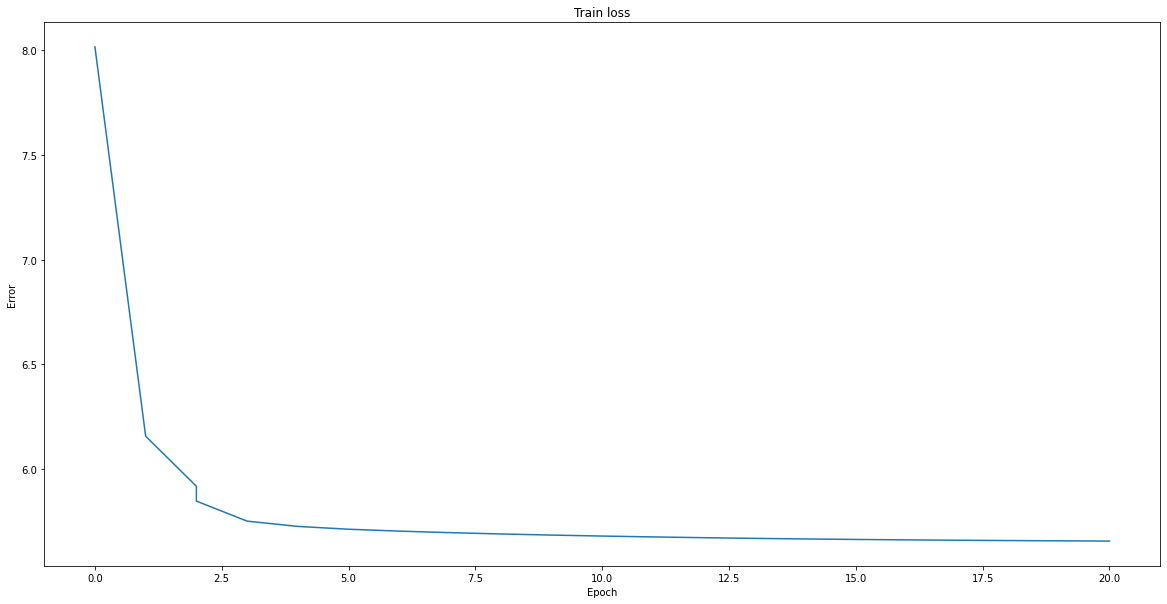

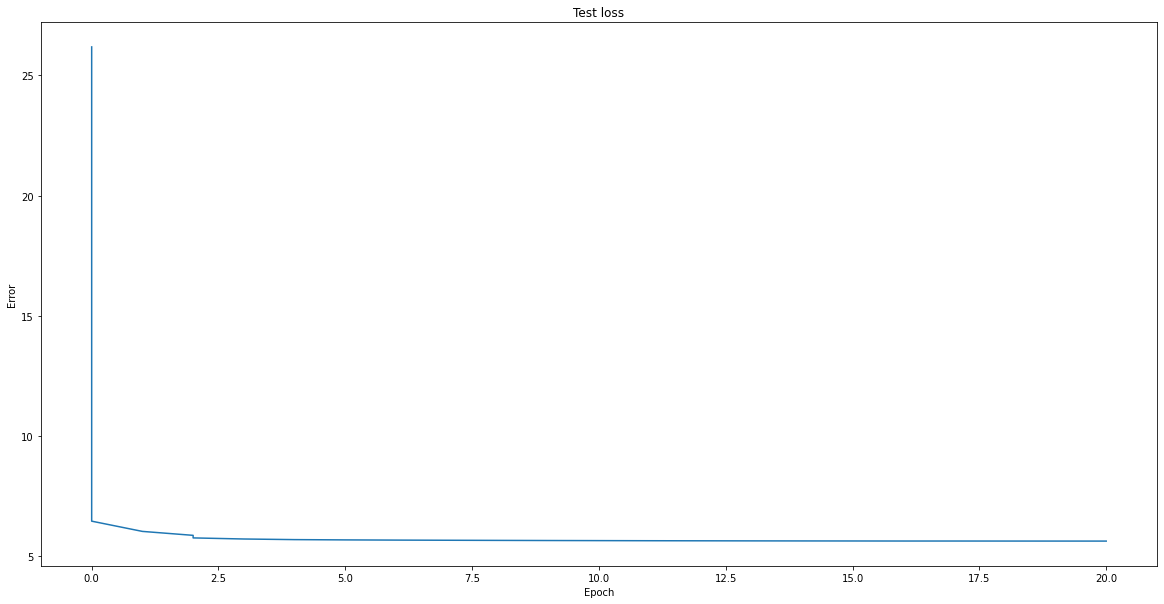

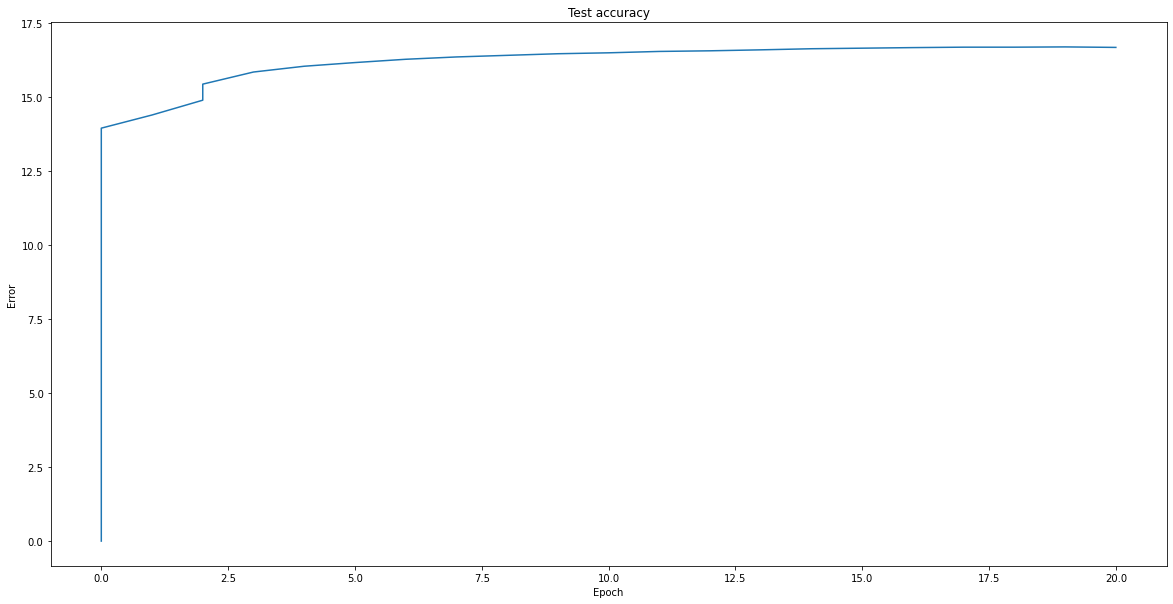

In [63]:
def main():
    SEQUENCE_LENGTH = 8
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log_word3.pkl'


    data_train = HarryPotterDatasetWord(DATA_PATH + 'harry_potter_word_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDatasetWord(DATA_PATH + 'harry_potter_word_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    print('train vocab size: ', data_train.vocab_size())
    print('test vocab size: ', data_test.vocab_size())

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'word_checkpoints3')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'word_checkpoints3/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'word_checkpoints3/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

word_final_model, vocab, device = main()

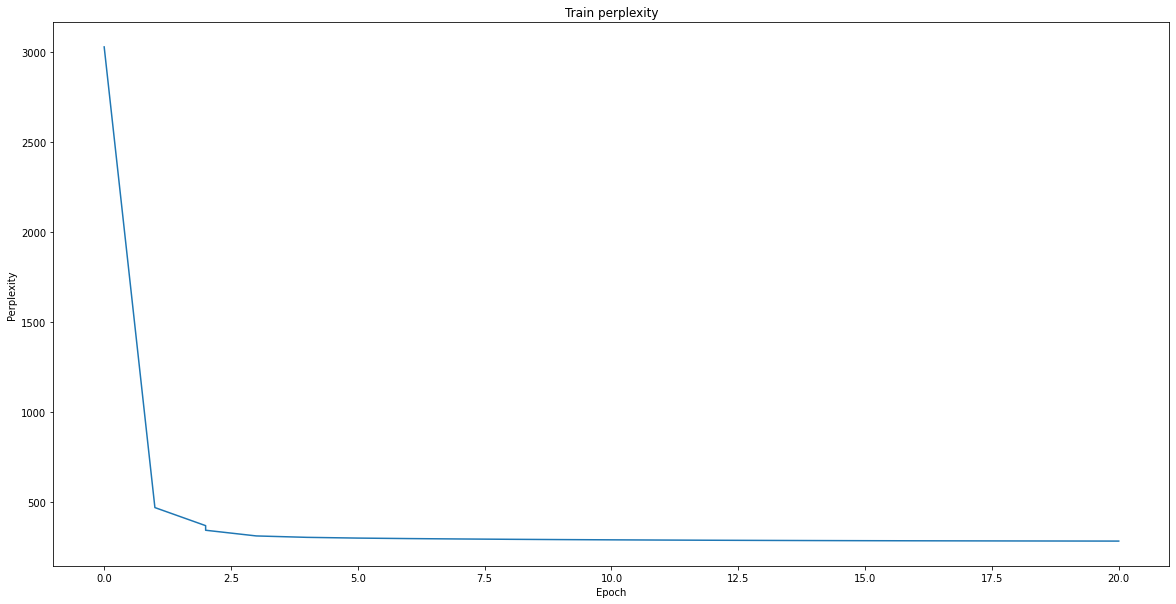

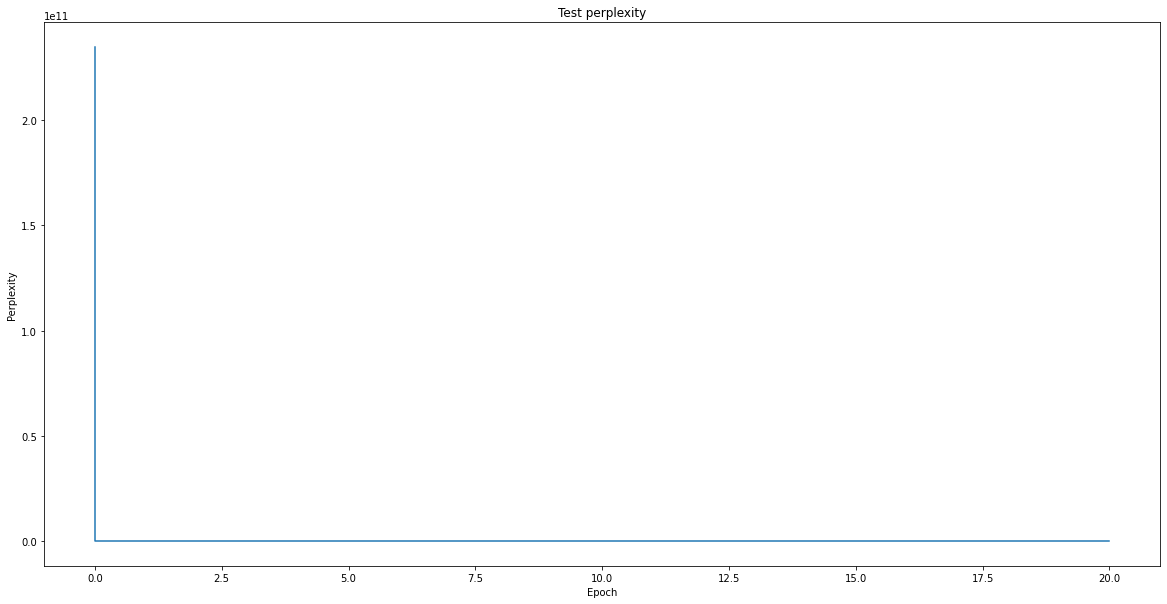

Train Perplexity:  285.8385712467711
Test Perplexity:  279.32753168624237


In [66]:
LOG_PATH = DATA_PATH + 'logs/log_word3.pkl'
train_loss, test_loss, test_accuracy = pt_util.read_log(LOG_PATH, ([], [], []))
epochs, plogn = zip(*train_loss)
train_perplexity = np.exp(plogn)
pt_util.plot(epochs, train_perplexity, 'Train perplexity', 'Epoch', 'Perplexity')
epochs, plogn = zip(*test_loss)
test_perplexity = np.exp(plogn)
pt_util.plot(epochs, test_perplexity, 'Test perplexity', 'Epoch', 'Perplexity')
print("Train Perplexity: ", train_perplexity[-1])
print("Test Perplexity: ",test_perplexity[-1])

In [67]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 8

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(word_final_model, vocab, device)

generated with max	 H a r r y <unknown> P o t t e r <unknown> a n d <unknown> t h e <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown> <unknown>
generated with sample	 H a r r y <unknown> P o t t e r <unknown> a n d <unknown> t h e "Oh, just however, it is another <unknown> he
generated with sample	 H a r r y <unknown> P o t t e r <unknown> a n d <unknown> t h e says <unknown> <unknown> <unknown> said Harry grinning. "So
generated with sample	 H a r r y <unknown> P o t t e r <unknown> a n d <unknown> t h e lightly up with a <unknown> but on the
generated with sample	 H a r r y <unknown> P o t t e r <unknown> a n d <unknown> t h e smiling down from the floor. Harry wished he
generated with sample	 H a r r y <unknown> P o t t e r <unknown> a n d <unknown> t h e Hagrid was looking for Harry. He didn't look
generated with sample	 H a r r y <unknown> P o t t e r <unknown> a n d <unknown> t h e sip of Uncle <unknown> <unknown> <unknown> <unknown> <unknown>
generated with s

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    